## Packages

In [6]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import random
from pyomo.environ import *
from numpy import flatnonzero as find
from pypower.api import case9, ext2int, bustypes, makeBdc, rundcpf, ppoption, rundcopf
from pypower.idx_bus import BUS_TYPE, REF, VA, PD, LAM_P, LAM_Q, MU_VMAX, MU_VMIN
from pypower.idx_gen import PG, MU_PMAX, MU_PMIN, MU_QMAX, MU_QMIN, PMAX, PMIN, GEN_BUS
from pypower.idx_brch import PF, PT, QF, QT, RATE_A, MU_SF, MU_ST
from pypower.idx_cost import COST
import matplotlib.pyplot as plt

## Power network parameters

In [7]:
# Run PyPower case to get initial condition
ppc = case9()
ppopt = ppoption(VERBOSE=0)
pp_dcopf = rundcopf(ppc, ppopt)
pp_bus = pp_dcopf["bus"]
pp_branch = pp_dcopf["branch"]
pp_gen = pp_dcopf["gen"]


Converged in 0.03 seconds
Objective Function Value = 5216.03 $/hr
|     System Summary                                                           |

How many?                How much?              P (MW)            Q (MVAr)
---------------------    -------------------  -------------  -----------------
Buses              9     Total Gen Capacity     820.0           0.0 to 0.0
Generators         3     On-line Capacity       820.0           0.0 to 0.0
Committed Gens     3     Generation (actual)    315.0               0.0
Loads              3     Load                   315.0               0.0
  Fixed            3       Fixed                315.0               0.0
  Dispatchable     0       Dispatchable           0.0 of 0.0        0.0
Shunts             0     Shunt (inj)              0.0               0.0
Branches           9     Losses (I^2 * Z)         0.00              0.00
Transformers       0     Branch Charging (inj)     -                0.0
Inter-ties         0     Total Inter-tie F

In [8]:
## convert to internal indexing
ppc = ext2int(ppc)
baseMVA, bus, gen, branch, gencost = \
    ppc["baseMVA"], ppc["bus"], ppc["gen"], ppc["branch"], ppc["gencost"]

## get bus index lists of each type of bus
ref, pv, pq = bustypes(bus, gen)
pvpq = np.matrix(np.r_[pv, pq])

## generator info
gbus = gen[:, GEN_BUS].astype(int)    ## what buses are they at?
refgen = find(gbus == ref)

## build B matrices and phase shift injections
B, Bf, _, _ = makeBdc(baseMVA, bus, branch)
B = B.todense()
Bf = Bf.todense()

# Problem dimensions
NG = gen.shape[0] # Number of generators
NB = bus.shape[0] # Number of buses
NBr = branch.shape[0] # Number of lines
NL = 3 # Number of loads
NW = 1 # Number of wind farms

# Map generator to bus
CG = np.zeros((NB,NG))
CG[gbus,range(3)] = 1

# Map load to bus
CL = np.zeros((NB,NL))
CL[4,0] = 1
CL[6,1] = 1
CL[8,2] = 1

# Map wind farm to bus
CW = np.zeros((NB,1))
CW[5,0] = 1

# Generator capacity limit p.u.
Pmax = gen[:, PMAX]/baseMVA
Pmin = gen[:, PMIN]/baseMVA

# Line flow limit p.u.
Lmax = branch[:, RATE_A]/baseMVA
Lmin = - branch[:, RATE_A]/baseMVA

# Quadratic cost coefficients
# Convert to p.u.
CG2 = gencost[:, COST]*baseMVA**2
CG1 = gencost[:, COST+1]*baseMVA
CG0 = gencost[:, COST+2]

# Cost coefficient for wind power
CW1 = 0
CW0 = 100

# Cost coefficients for generation reserve
CRG_up = 10*np.ones((NG,1))*baseMVA
CRG_down = 10*np.ones((NG,1))*baseMVA

# Cost coefficients for load reserve
CRL_up = 9.8*np.ones((NL,1))*baseMVA
CRL_down = 9.8*np.ones((NL,1))*baseMVA

# Uncontrollable load
PL_total = np.array([90,100,125])
PL = PL_total/baseMVA

# Generator and demand set points
# Power in p.u., Va in rad
Pg0 = pp_gen[:, PG]/baseMVA
Pd0 = pp_bus[:, PD]/baseMVA
Pinj0 = (np.matmul(CG, Pg0) - Pd0)
Va0 = pp_bus[:, VA]/180*np.pi

## Cost function

In [9]:
def cost(model,CG0,CG1,CG2,CRG_up,CRG_down,CRL_up,CRL_down,NG,NL):
    r_pg = np.zeros(NG)
    r_rg_up = np.zeros(NG)
    r_rg_down = np.zeros(NG)
    gen_cost = np.zeros(NG)
    gen_r_cost = np.zeros(NG)

    for i in range(NG):
        r_pg[i] = model.PG[i]()
        r_rg_up[i] = model.RG_up[i]()
        r_rg_down[i] = model.RG_down[i]()
        gen_cost[i] = CG0[i] + CG1[i]*r_pg[i] + CG2[i]*r_pg[i]**2
        gen_r_cost[i] = CRG_up[i]*r_rg_up[i] + CRG_down[i]*r_rg_down[i]

    total_cost = np.sum(gen_cost + gen_r_cost)

    return gen_cost,gen_r_cost,total_cost

## Read results

In [10]:
case_name = "case9_without_DR_v6"
nsample = 453
nhours = 24
figdir = "Figures/"+case_name+"/"

file = open("Results/models_%s_%d" %(case_name, nsample), "rb")
models = pickle.load(file)
file.close()

# Read PB data
file = open("Results/PB_alls_%s_%d" %(case_name, nsample), "rb")
PB_alls = pickle.load(file)
file.close()

# Read Pmis_wind data
file = open("Results/P_mis_winds_%s_%d" %(case_name, nsample), "rb")
Pmis_winds = pickle.load(file)
file.close()

## Reserve plots

### RG boxplot

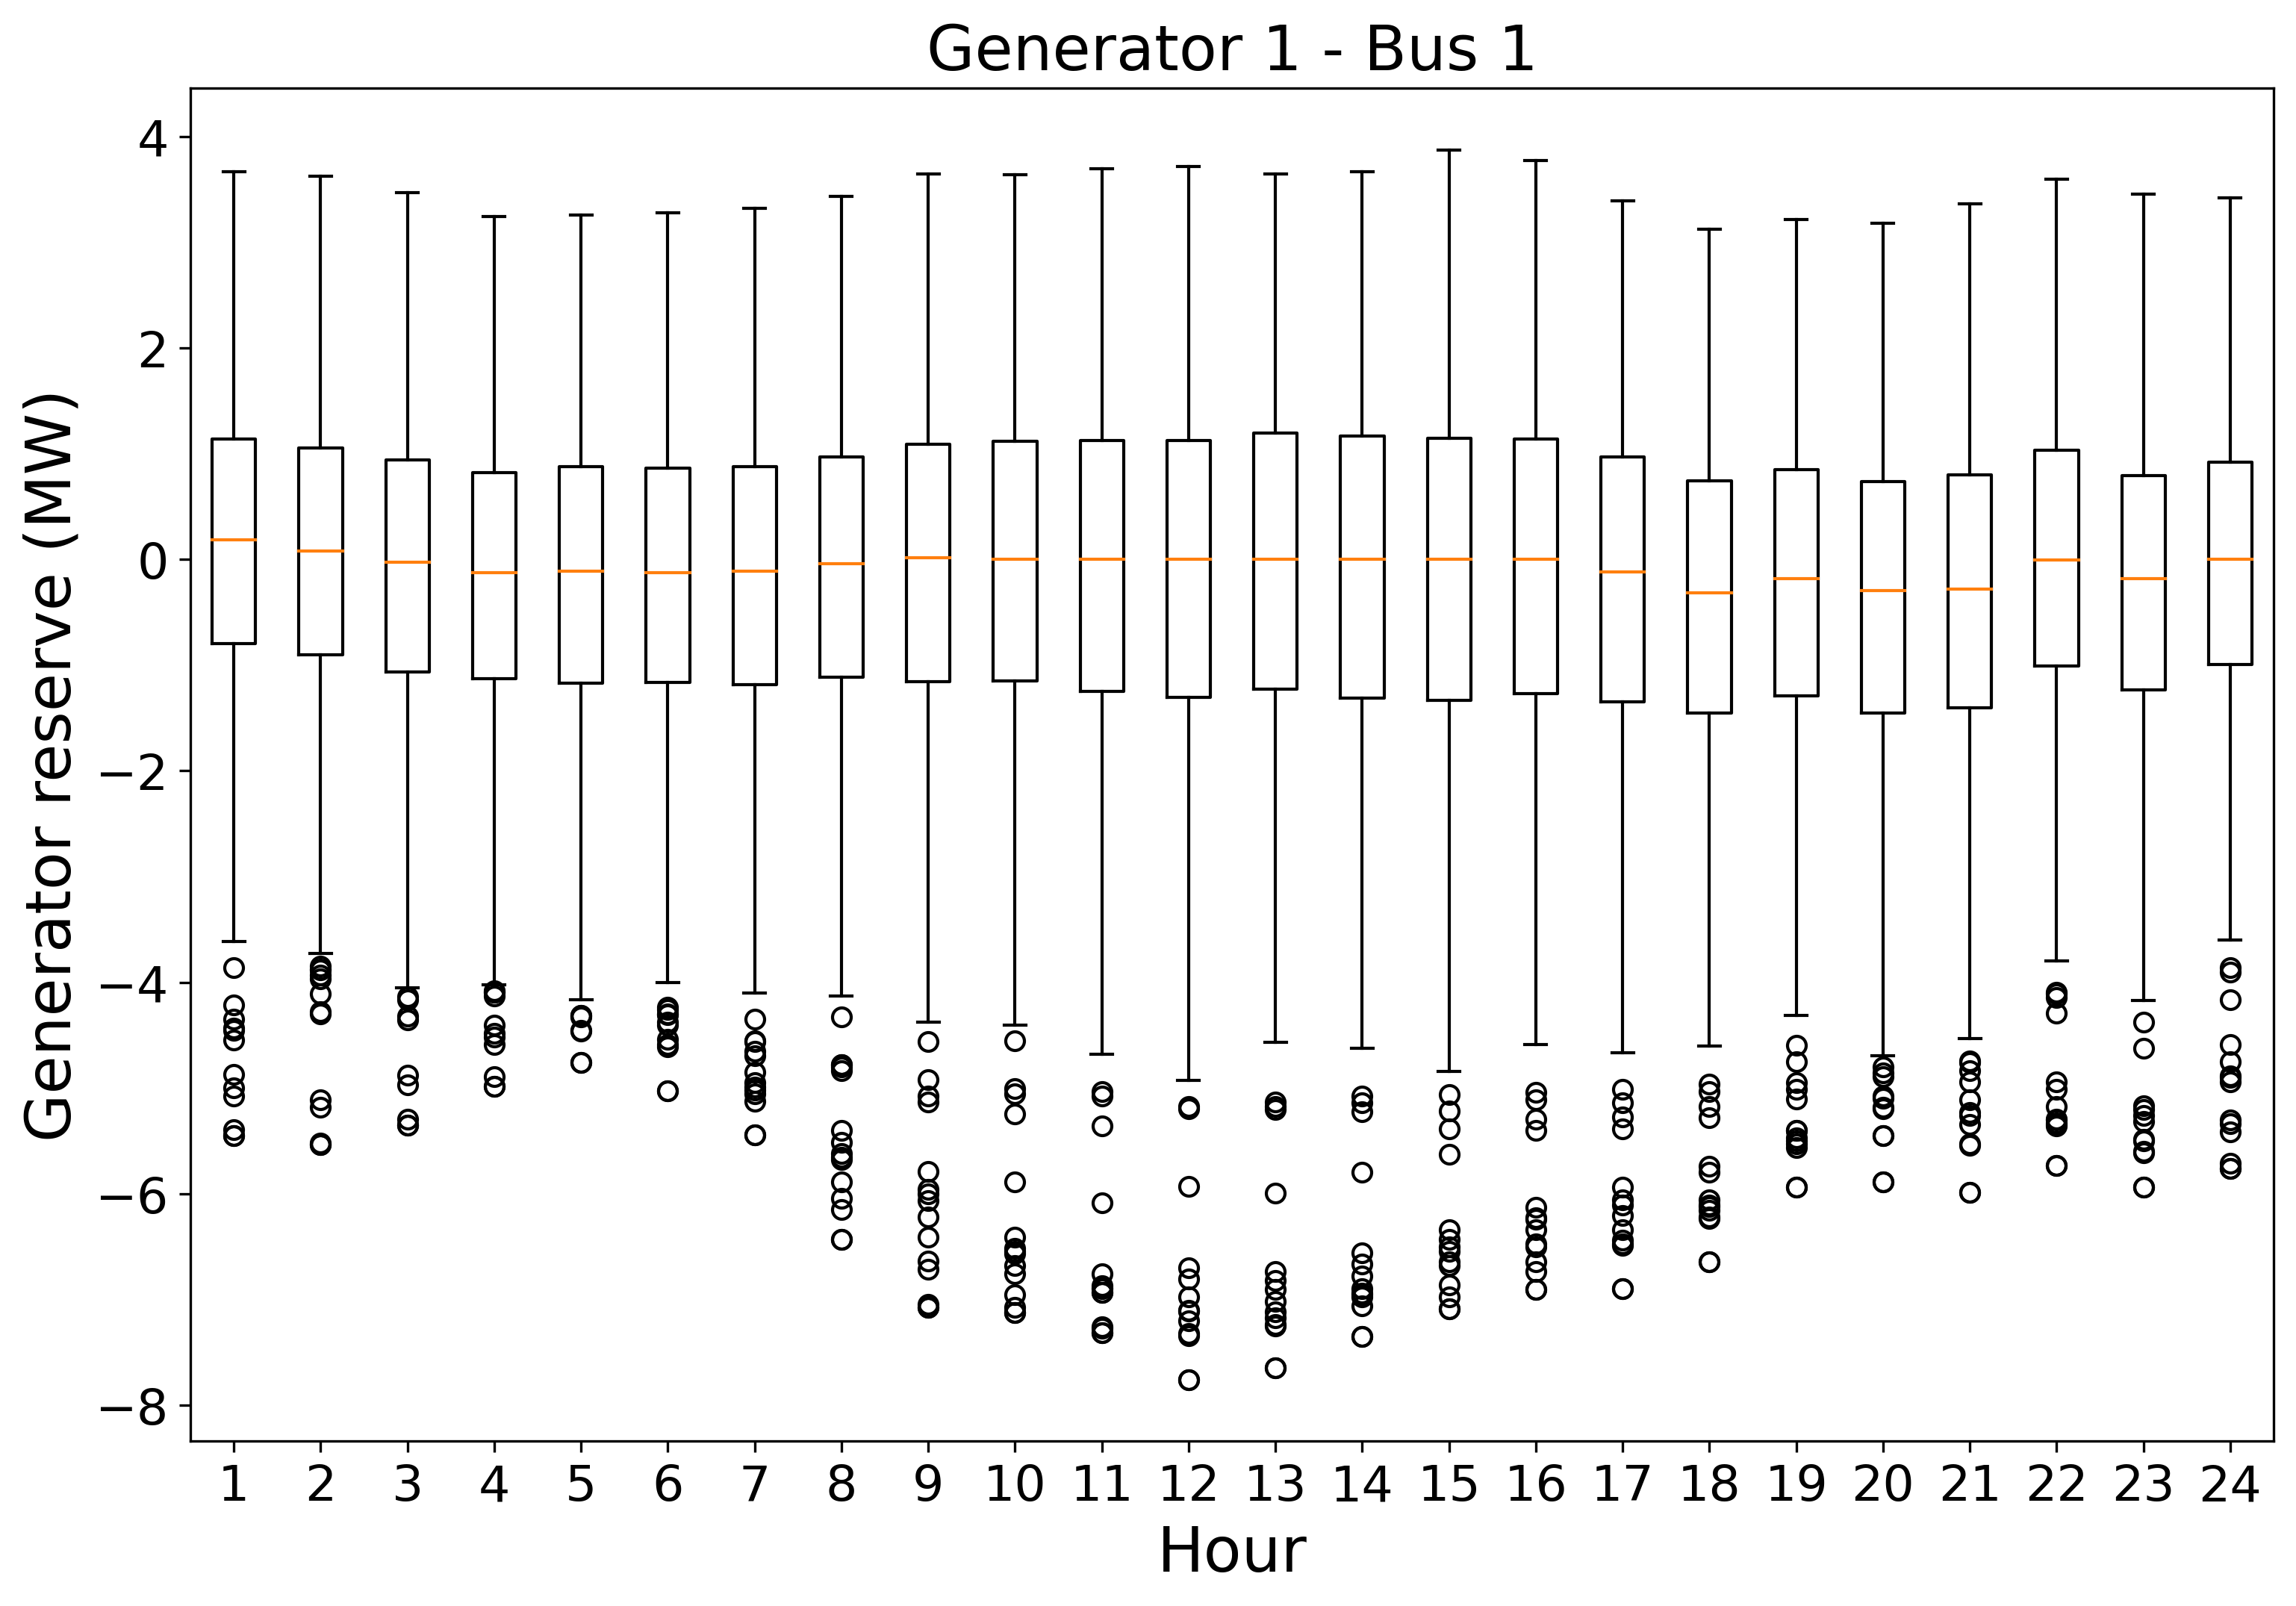

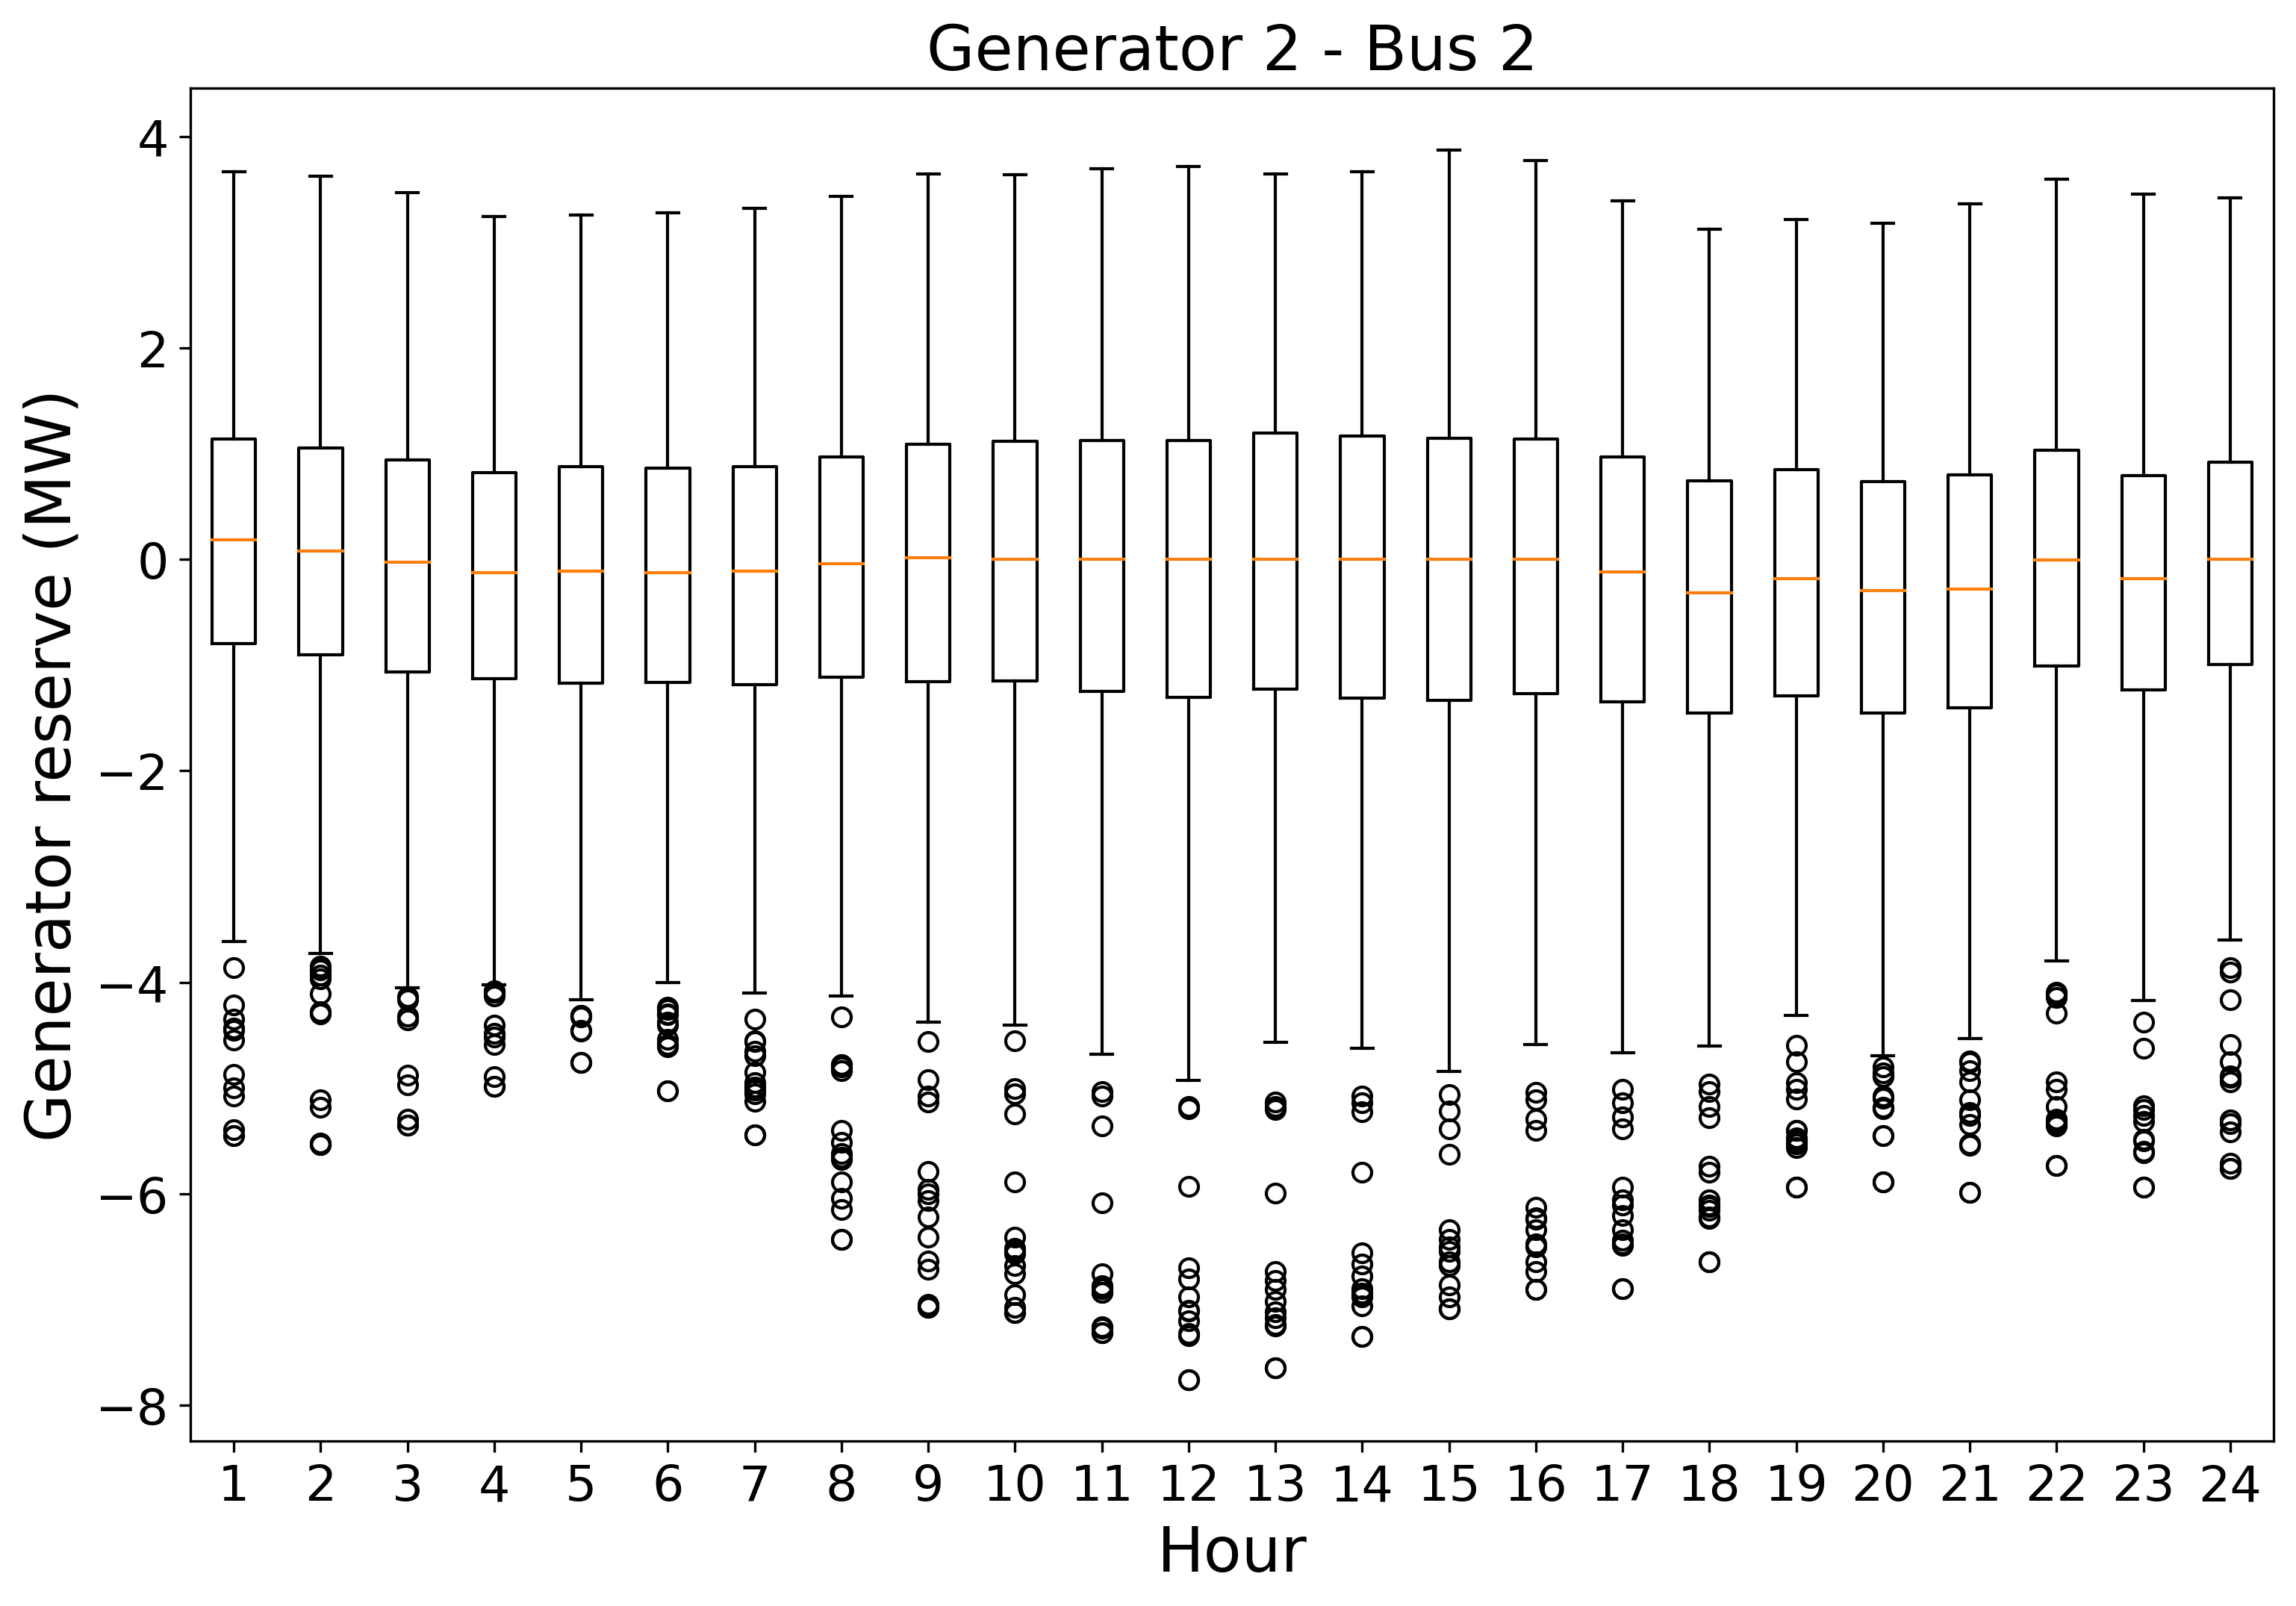

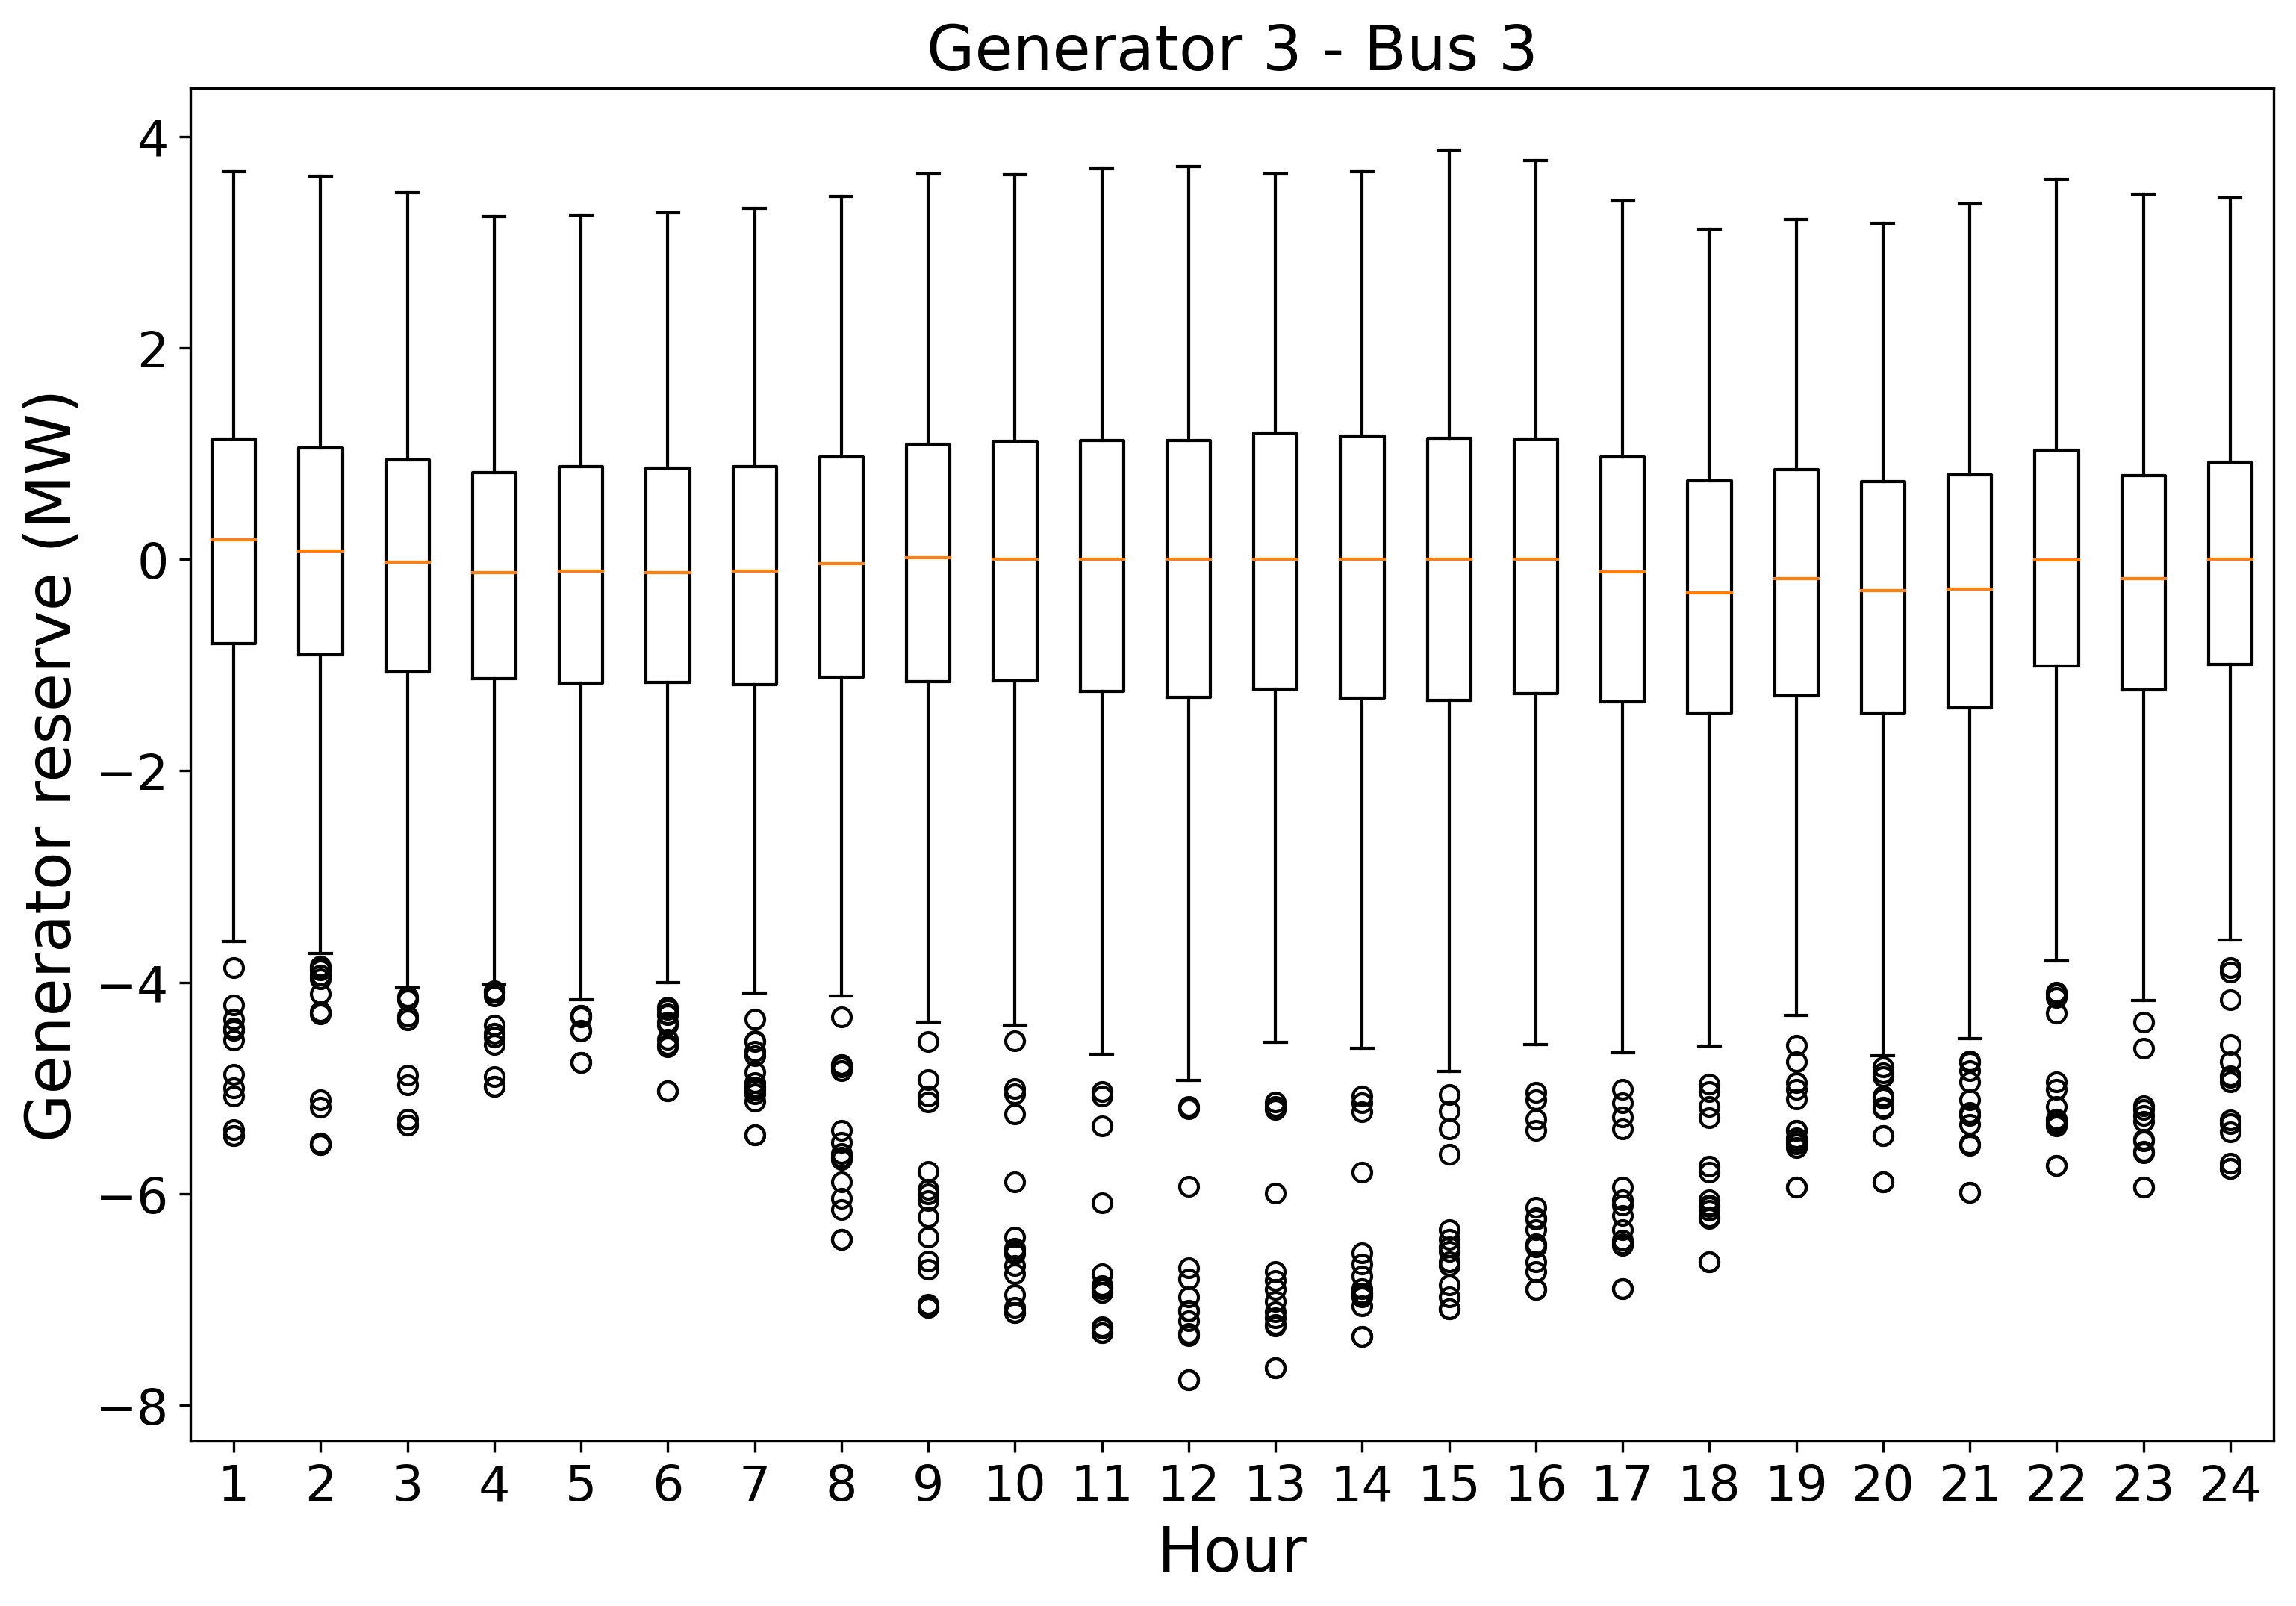

In [11]:
# Read RG data
RG_all_hour = np.zeros((NG, nhours, nsample))

for h in range(nhours):
    model = models[h]
    RG_all = model.RG[:,:]()
    RG_all = np.array(RG_all).reshape(NG, nsample)*baseMVA

    for i in range(NG):
        RG_one = RG_all[i, :]
        RG_all_hour[i, h, :] = RG_one

# RG boxplot
gen_bus = [1, 2, 3]

for i in range(NG):
    fig = plt.figure(figsize=(12,8), dpi=300)
    RG_plot = RG_all_hour[i, :, :].tolist()
    plt.boxplot(RG_plot)
    plt.title("Generator %d - Bus %d" %((i+1), gen_bus[i]), fontsize=20)
    plt.xlabel("Hour", fontsize=20)
    plt.ylabel("Generator reserve (MW)", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    fig_name = figdir+"RG_%i.png" %i
    fig.savefig(fig_name, dpi=300)
    plt.show()

### RG up and down bar plot

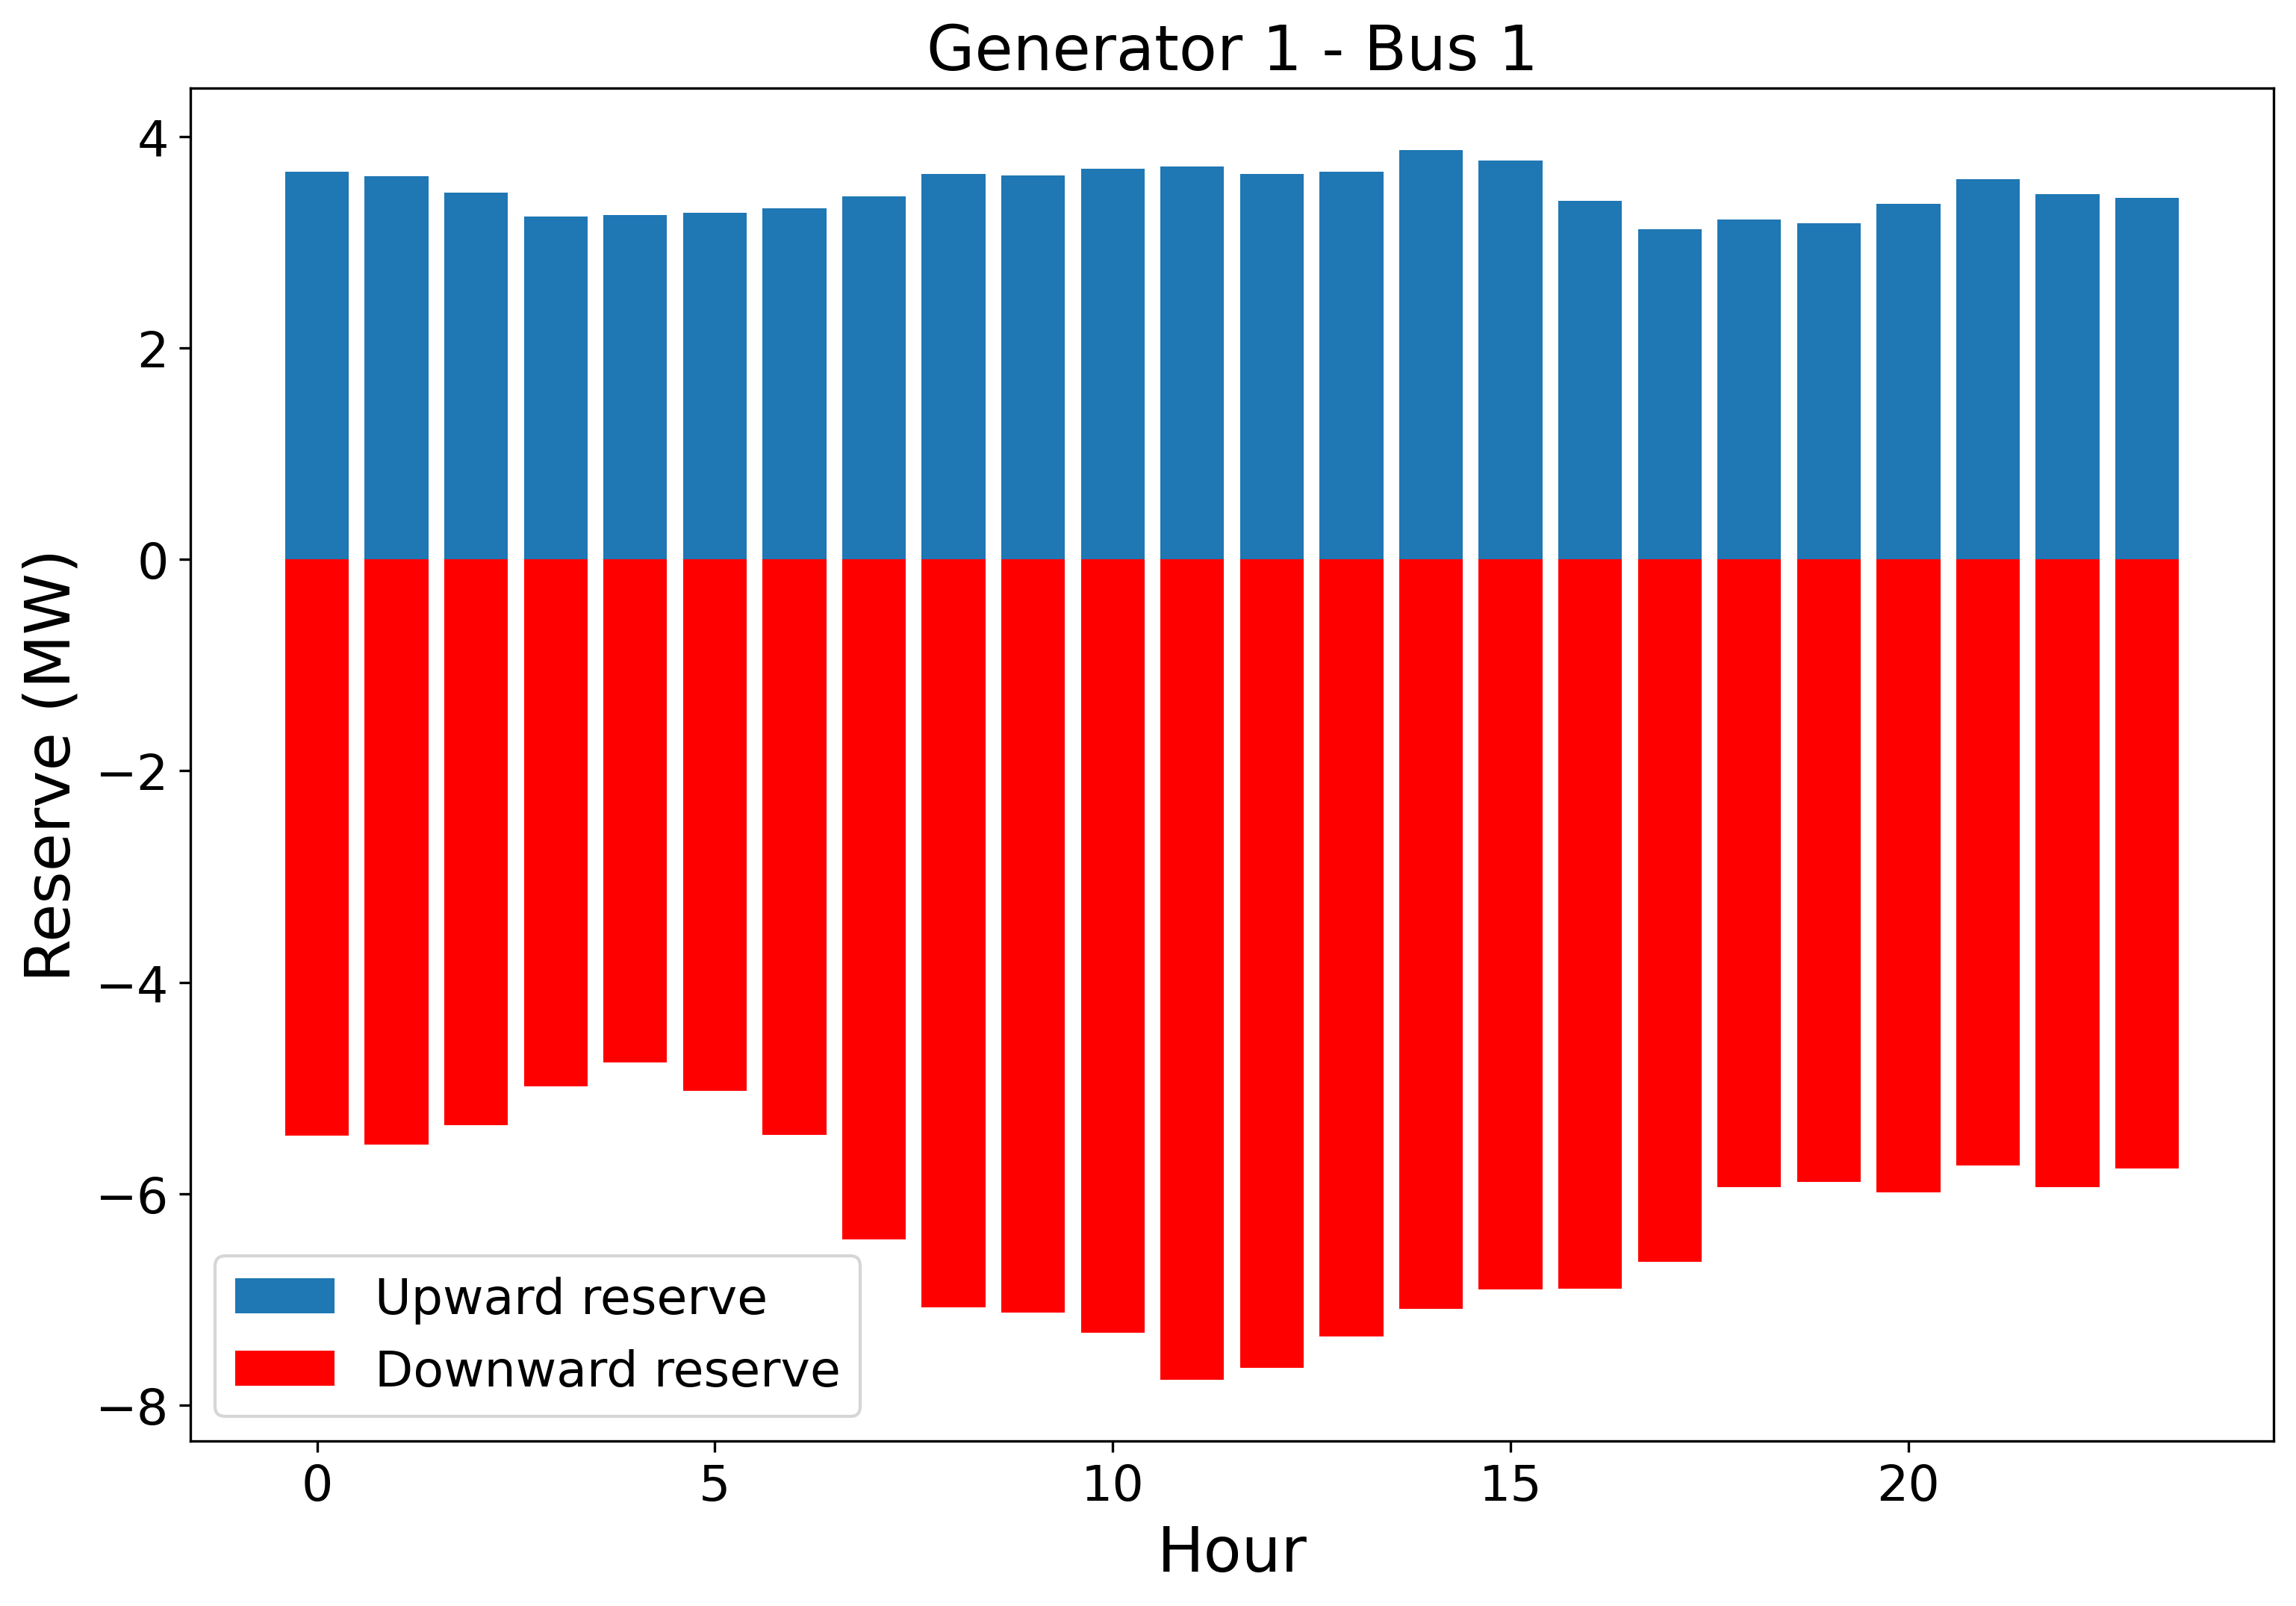

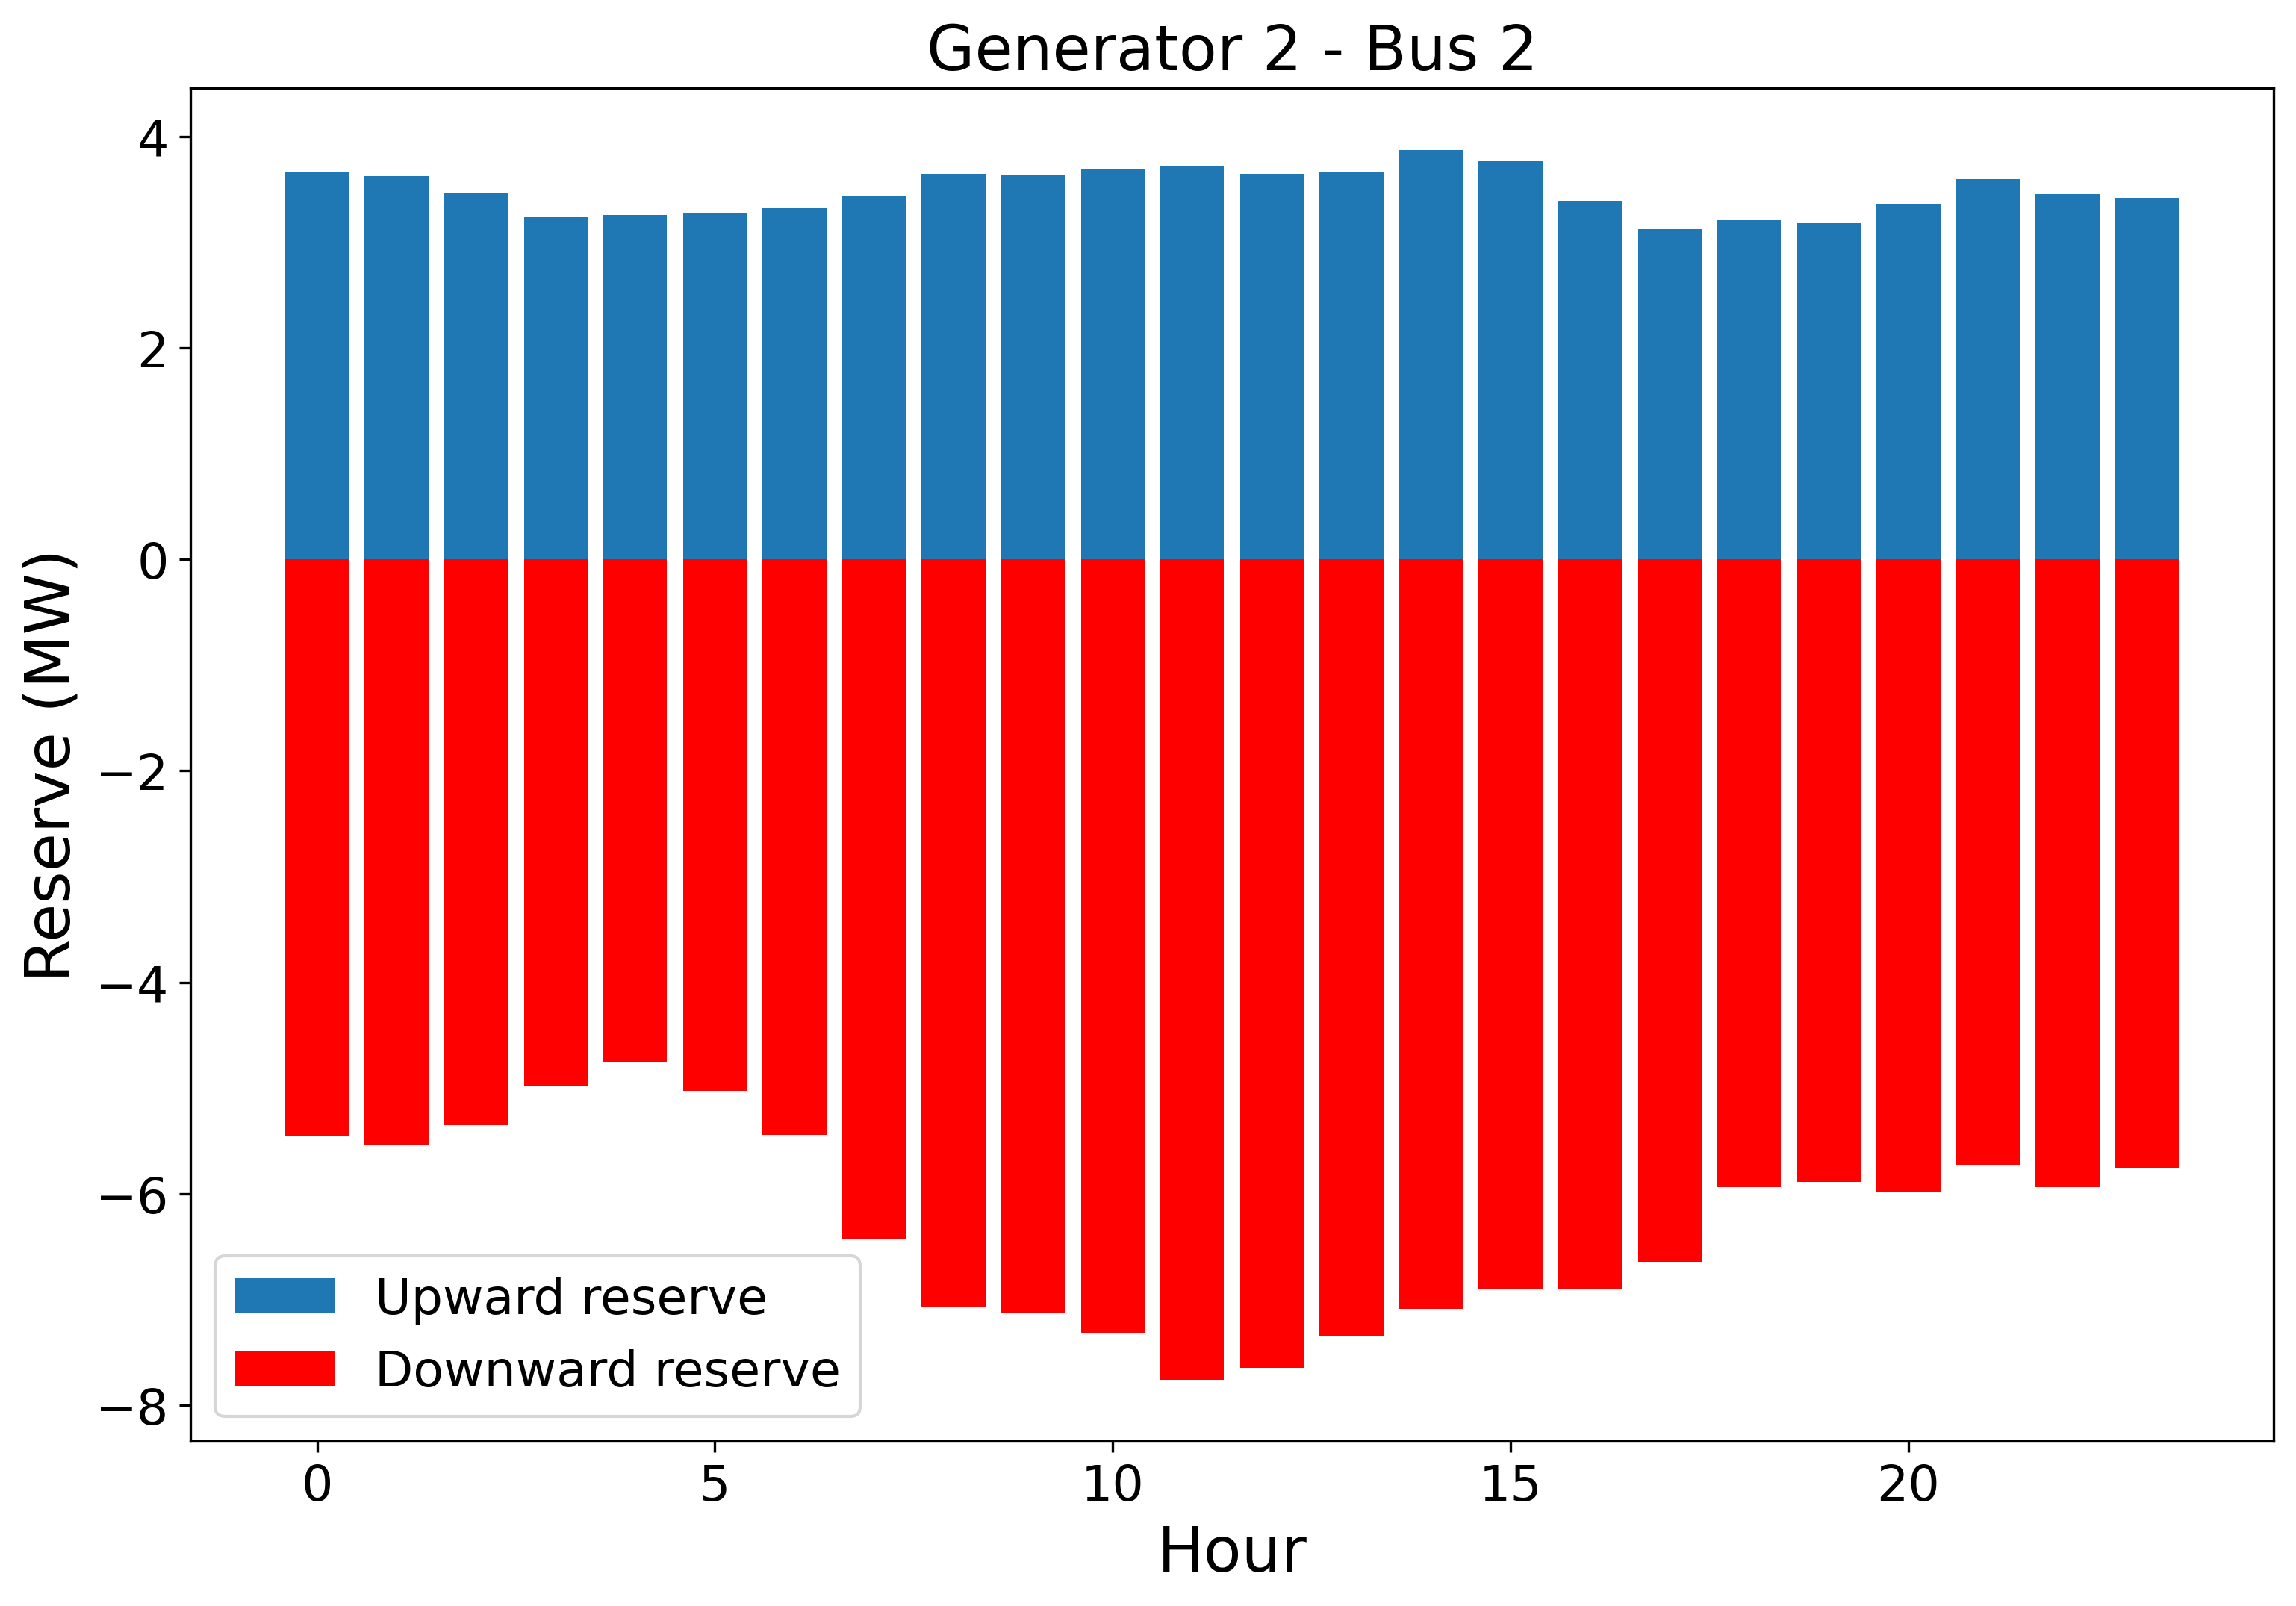

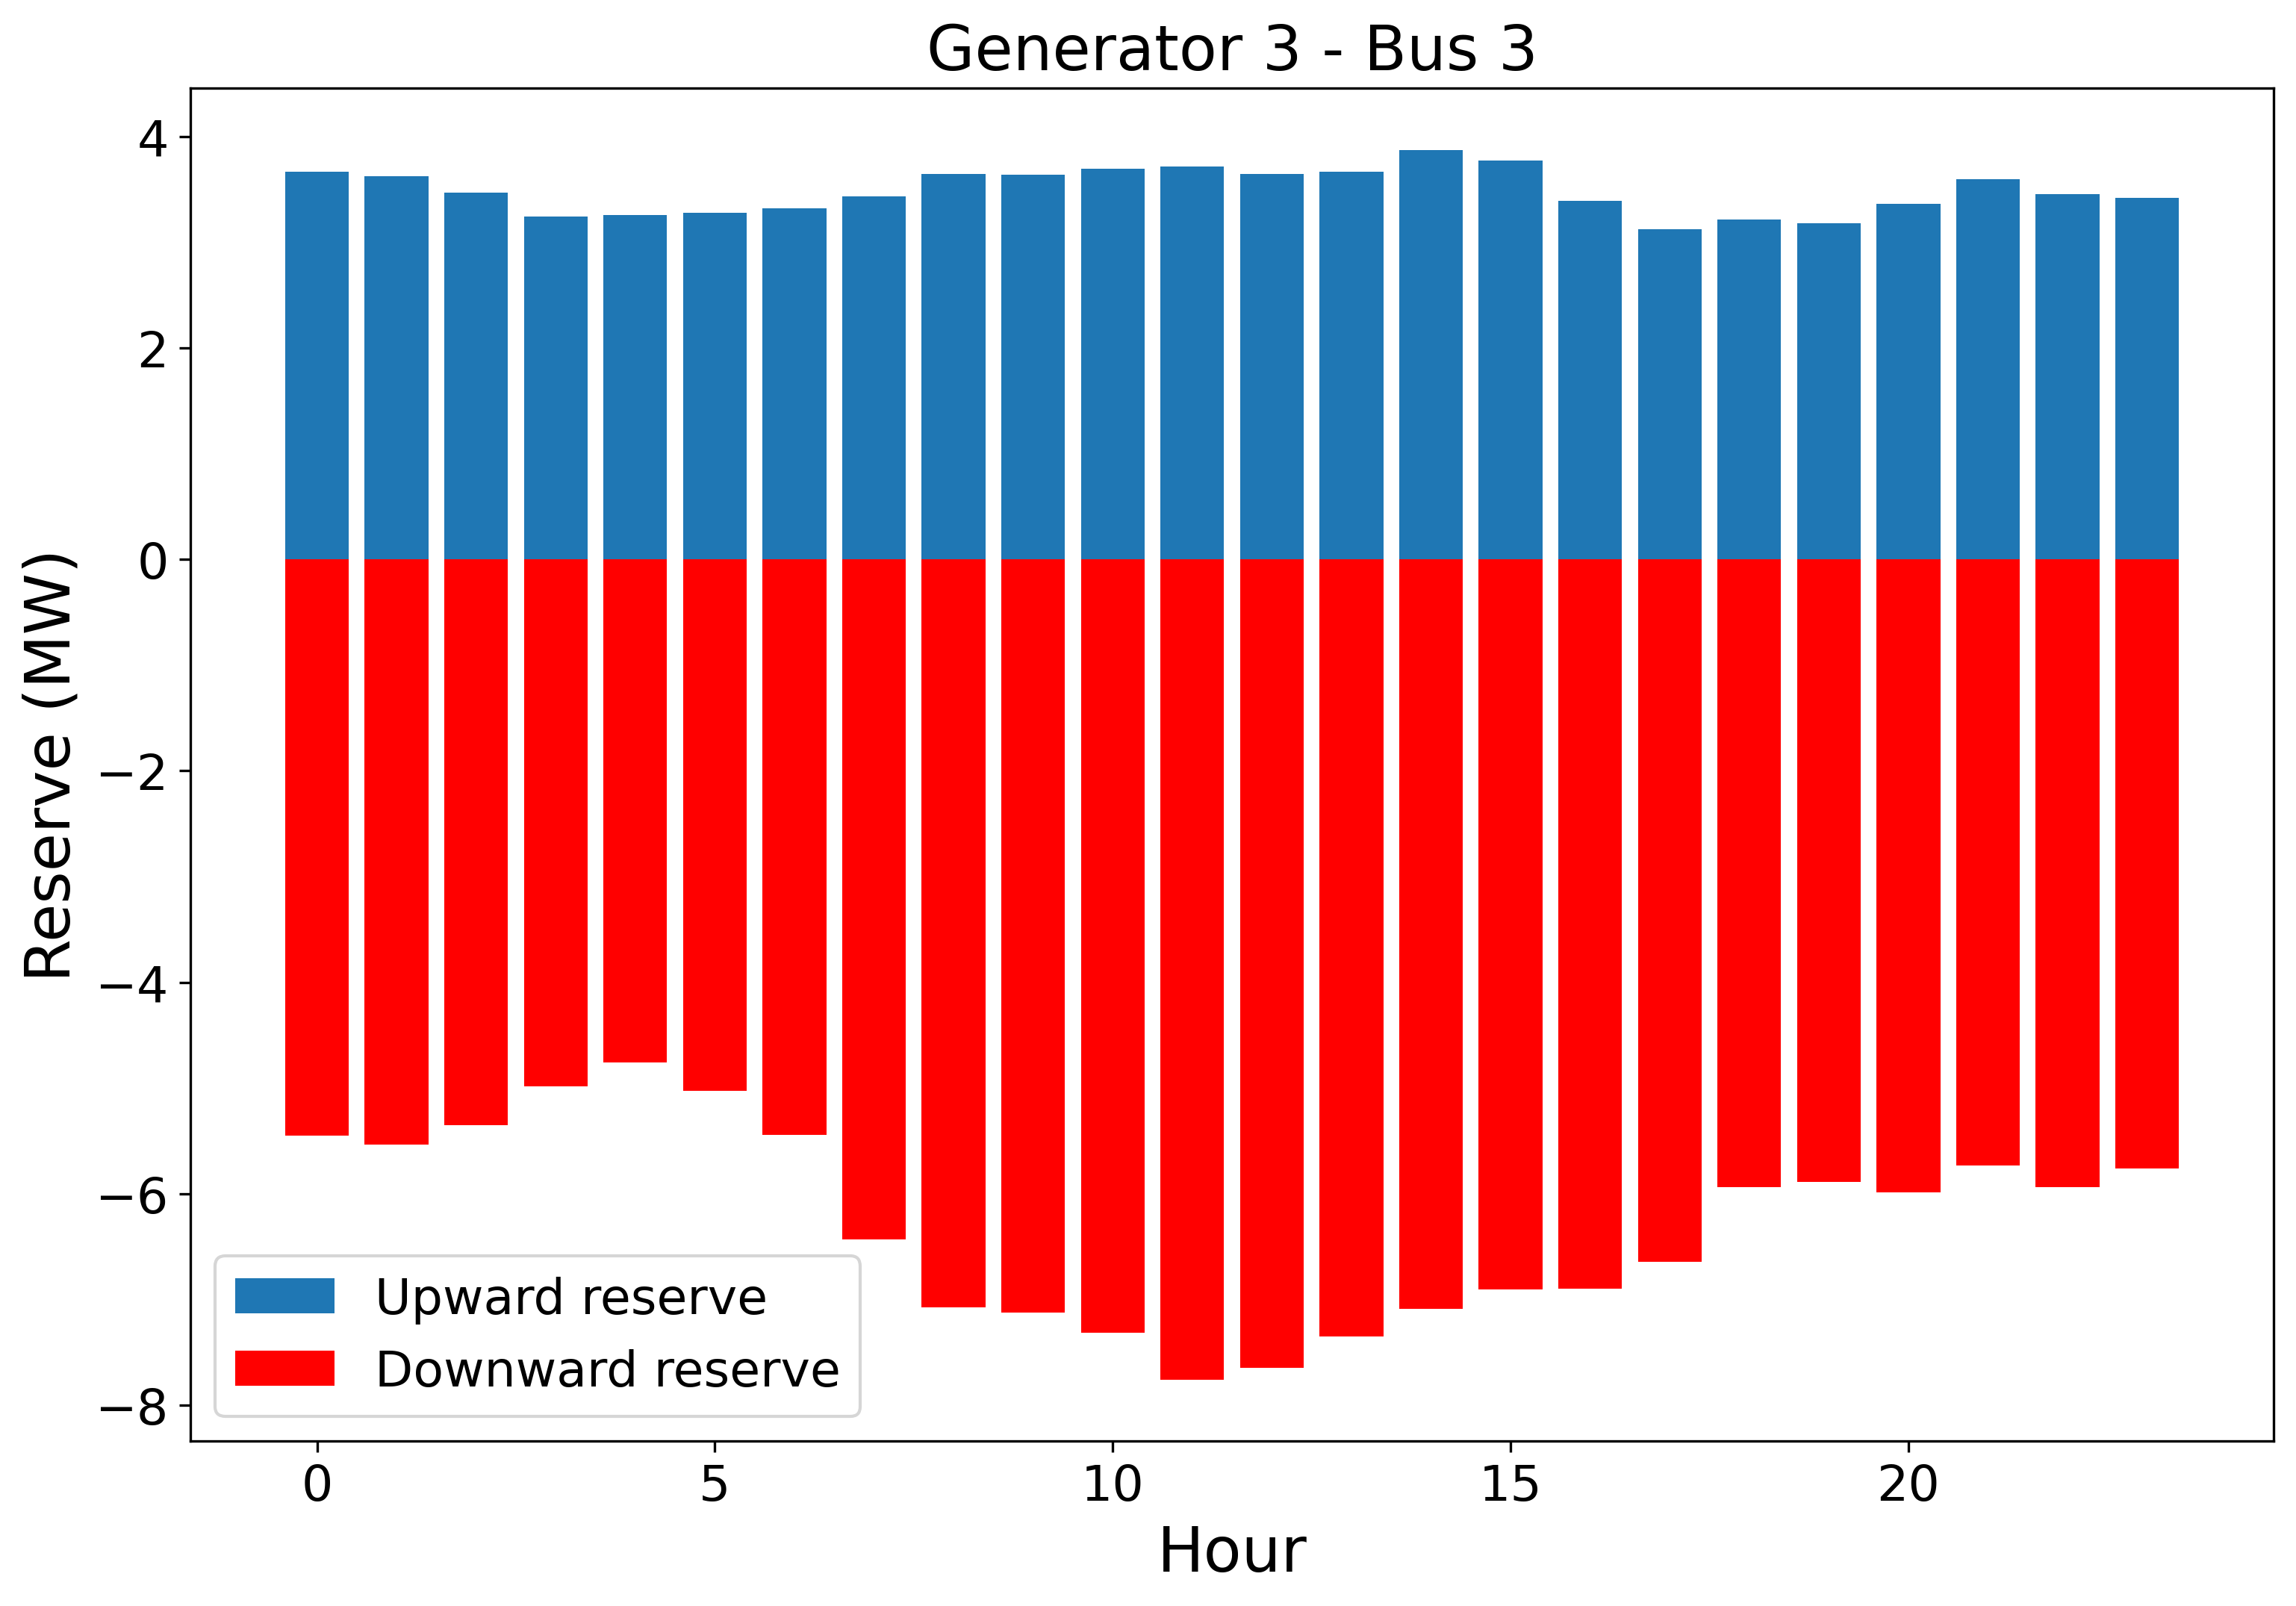

In [12]:
# Read RG up and down data
RG_up_all_hour = np.zeros((NG, nhours))
RG_down_all_hour = np.zeros((NG, nhours))

for h in range(nhours):
    model = models[h]
    RG_up_all = model.RG_up[:]()
    RG_down_all = model.RG_down[:]()
    RG_up_all = np.array(RG_up_all).reshape(NG)*baseMVA
    RG_down_all = np.array(RG_down_all).reshape(NG)*baseMVA

    for i in range(NG):
        RG_up_one = RG_up_all[i]
        RG_down_one = RG_down_all[i]
        RG_up_all_hour[i, h] = RG_up_one
        RG_down_all_hour[i, h] = RG_down_one

# Plot RG up and down data
for i in range(NG):
    # print("Generator: ", i)
    fig = plt.figure(figsize=(12,8), dpi=300)

    RG_up_plot = RG_up_all_hour[i, :]
    # print("RG up: ", RG_up_plot)
    plt.bar(range(nhours),RG_up_plot, label="Upward reserve")

    RG_down_plot = RG_down_all_hour[i, :]
    # print("RG down: ", RG_down_plot)
    plt.bar(range(nhours),-RG_down_plot, color='r', label="Downward reserve")

    plt.legend(fontsize=16)
    plt.title("Generator %d - Bus %d" %((i+1), gen_bus[i]), fontsize=20)
    plt.xlabel("Hour", fontsize=20)
    plt.ylabel("Reserve (MW)", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    fig_name = figdir+"RG_up_down_%i.png" %i
    fig.savefig(fig_name, dpi=300)
    

## Power mismatch plot

### Wind mismatch boxplot

In [13]:
# Calculate wind mismatch
Pmis_wind_hour = np.zeros((nhours, nsample))
for h in range(nhours):
    Pmis_wind = Pmis_winds[h]
    Pmis_wind = np.array(Pmis_wind).reshape(nsample)*baseMVA
    Pmis_wind_hour[h, :] = Pmis_wind

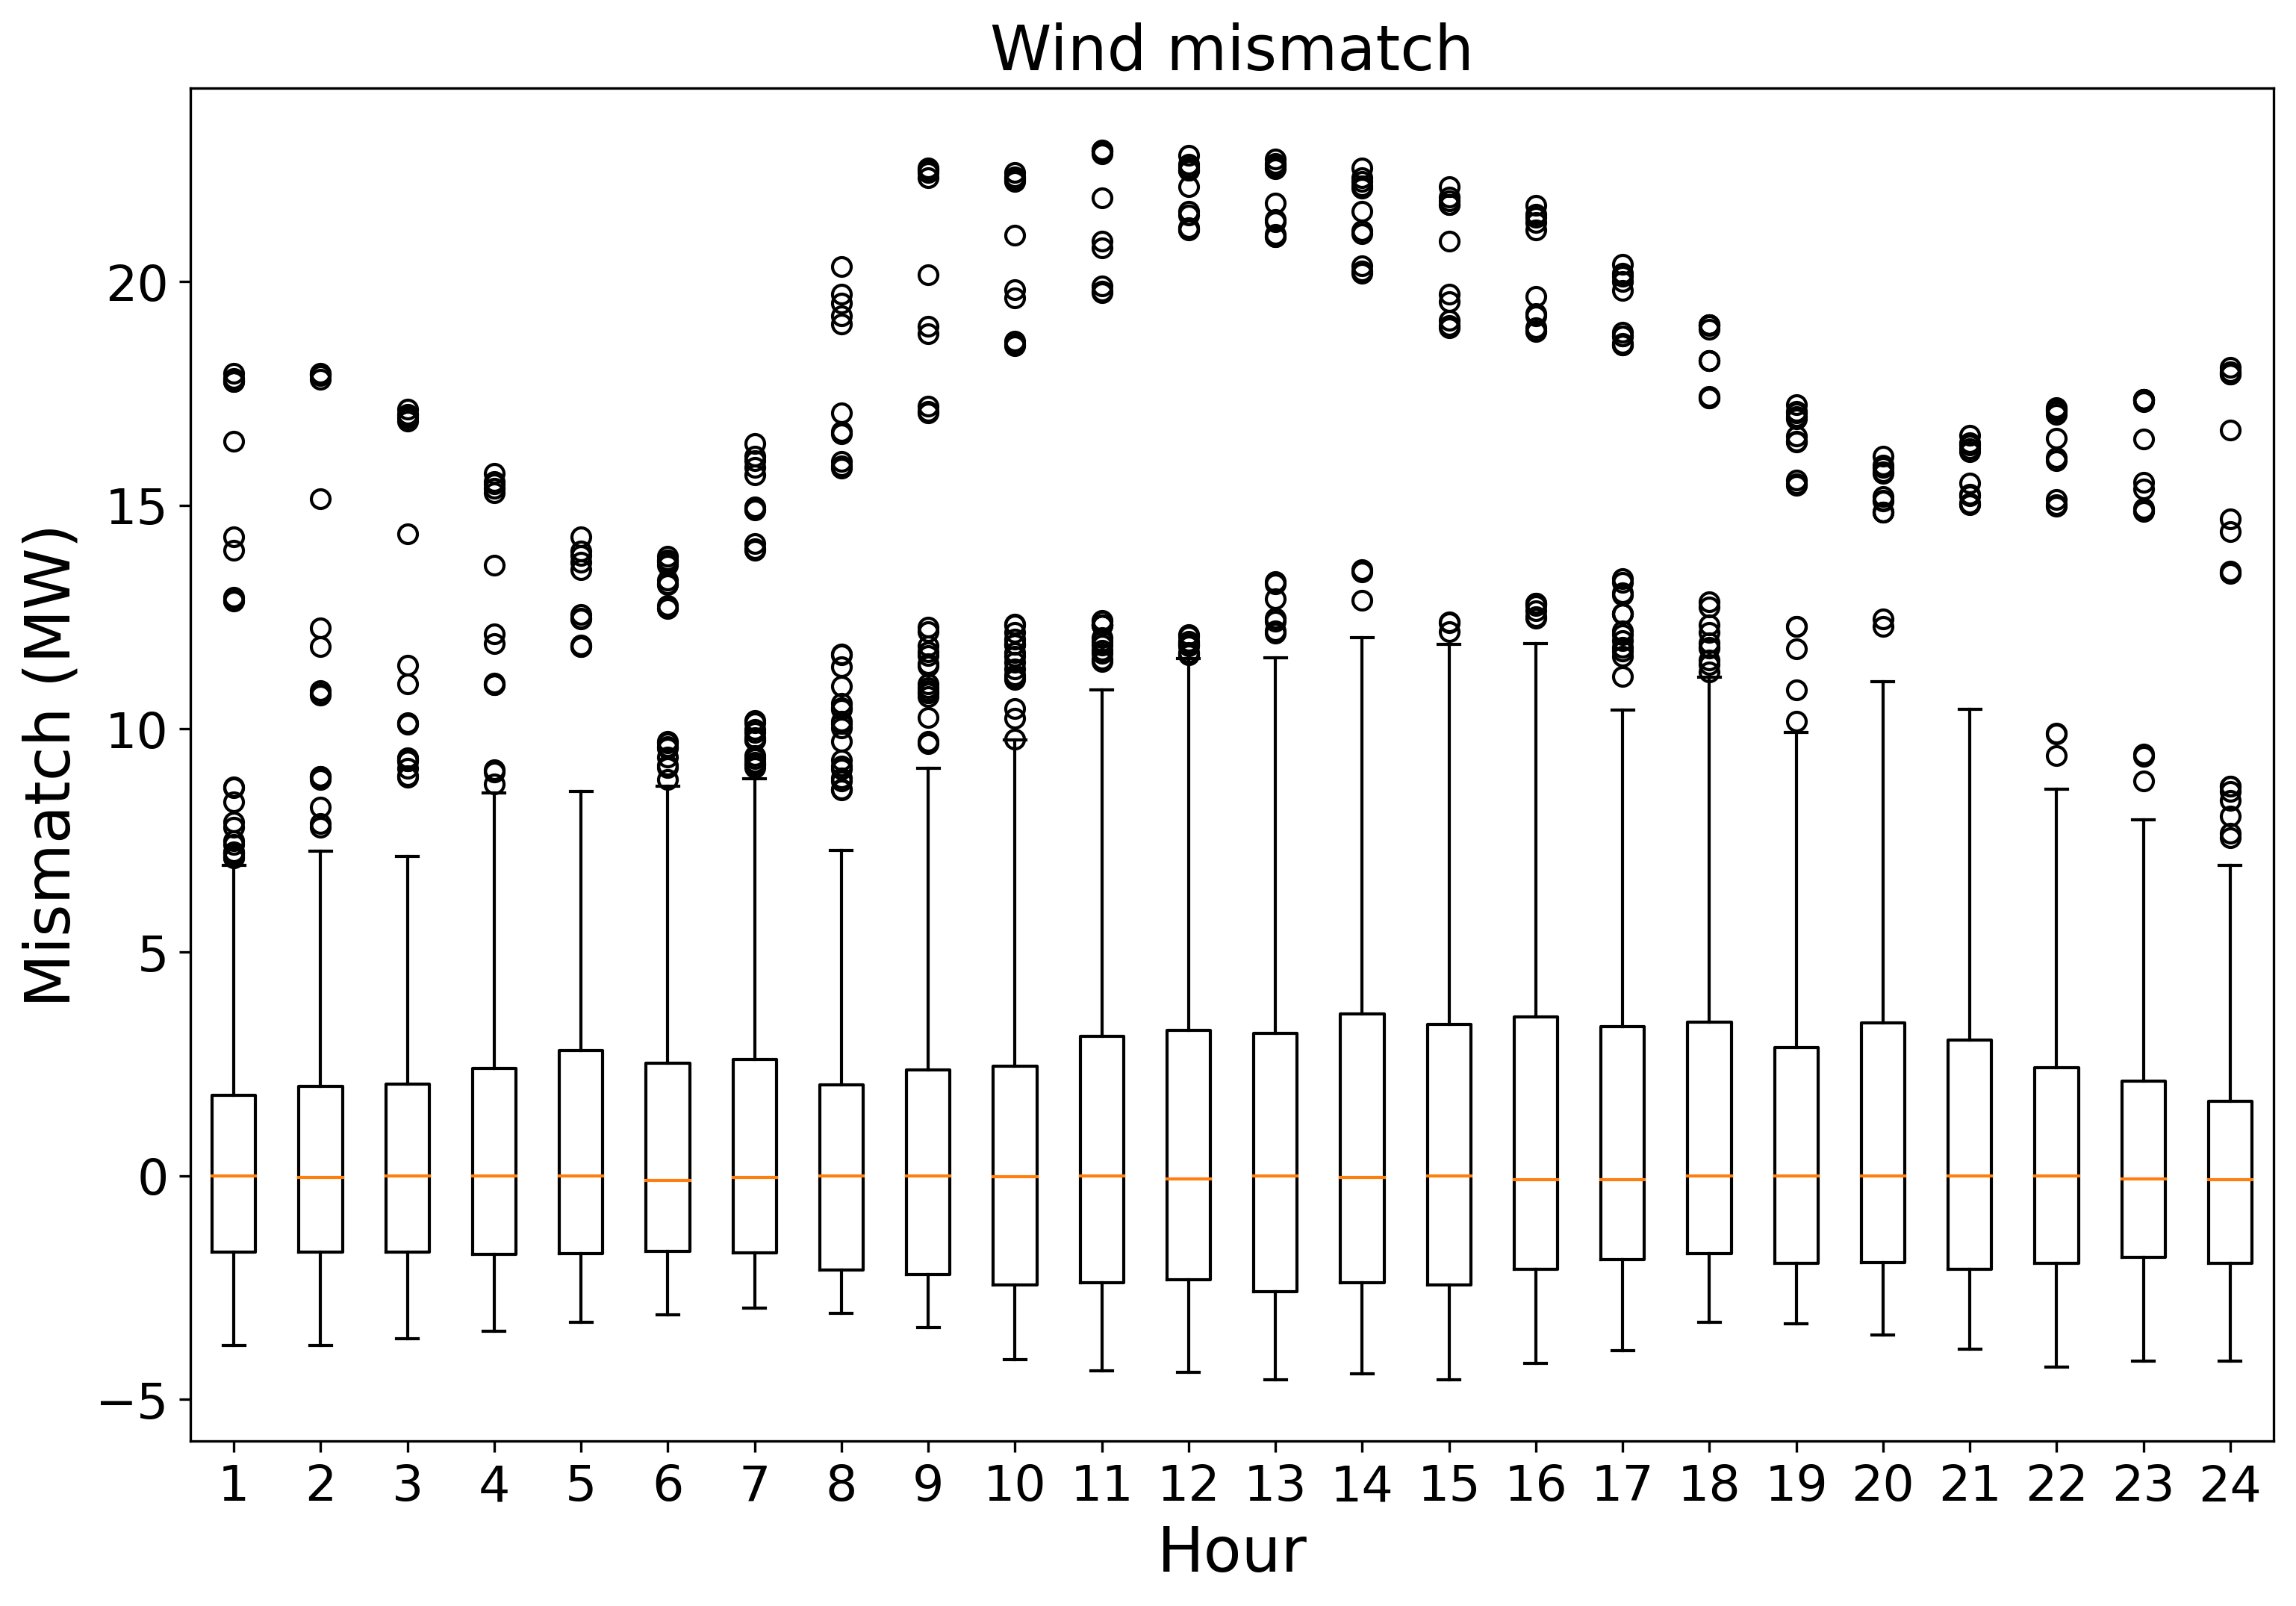

In [14]:
fig = plt.figure(figsize=(12,8), dpi=300)
Pmis_wind_plot = Pmis_wind_hour.tolist()
plt.boxplot(Pmis_wind_plot)
plt.title("Wind mismatch", fontsize=20)
plt.xlabel("Hour", fontsize=20)
plt.ylabel("Mismatch (MW)", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig_name = figdir+"Wind_mismatch.png"
fig.savefig(fig_name, dpi=300)
plt.show()
plt.show()

In [15]:
# Load power set point
PB_all_hour = np.zeros((NL, nhours, nsample))
for h in range(nhours):
    PB_all = PB_alls[h]
    PB_all = np.array(PB_all).reshape(NL, nsample)*baseMVA

    for i in range(NL):
        PB_one = PB_all[i, :]
        PB_all_hour[i, h, :] = PB_one

In [16]:
# Read PC data (controllable load)
PC_all_hour = np.zeros((NL, nhours))

for h in range(nhours):
    model = models[h]
    PC_all = model.PC[:]()
    PC_all = np.array(PC_all).reshape(NL)*baseMVA

    for i in range(NL):
        PC_one = PC_all[i]
        PC_all_hour[i, h] = PC_one

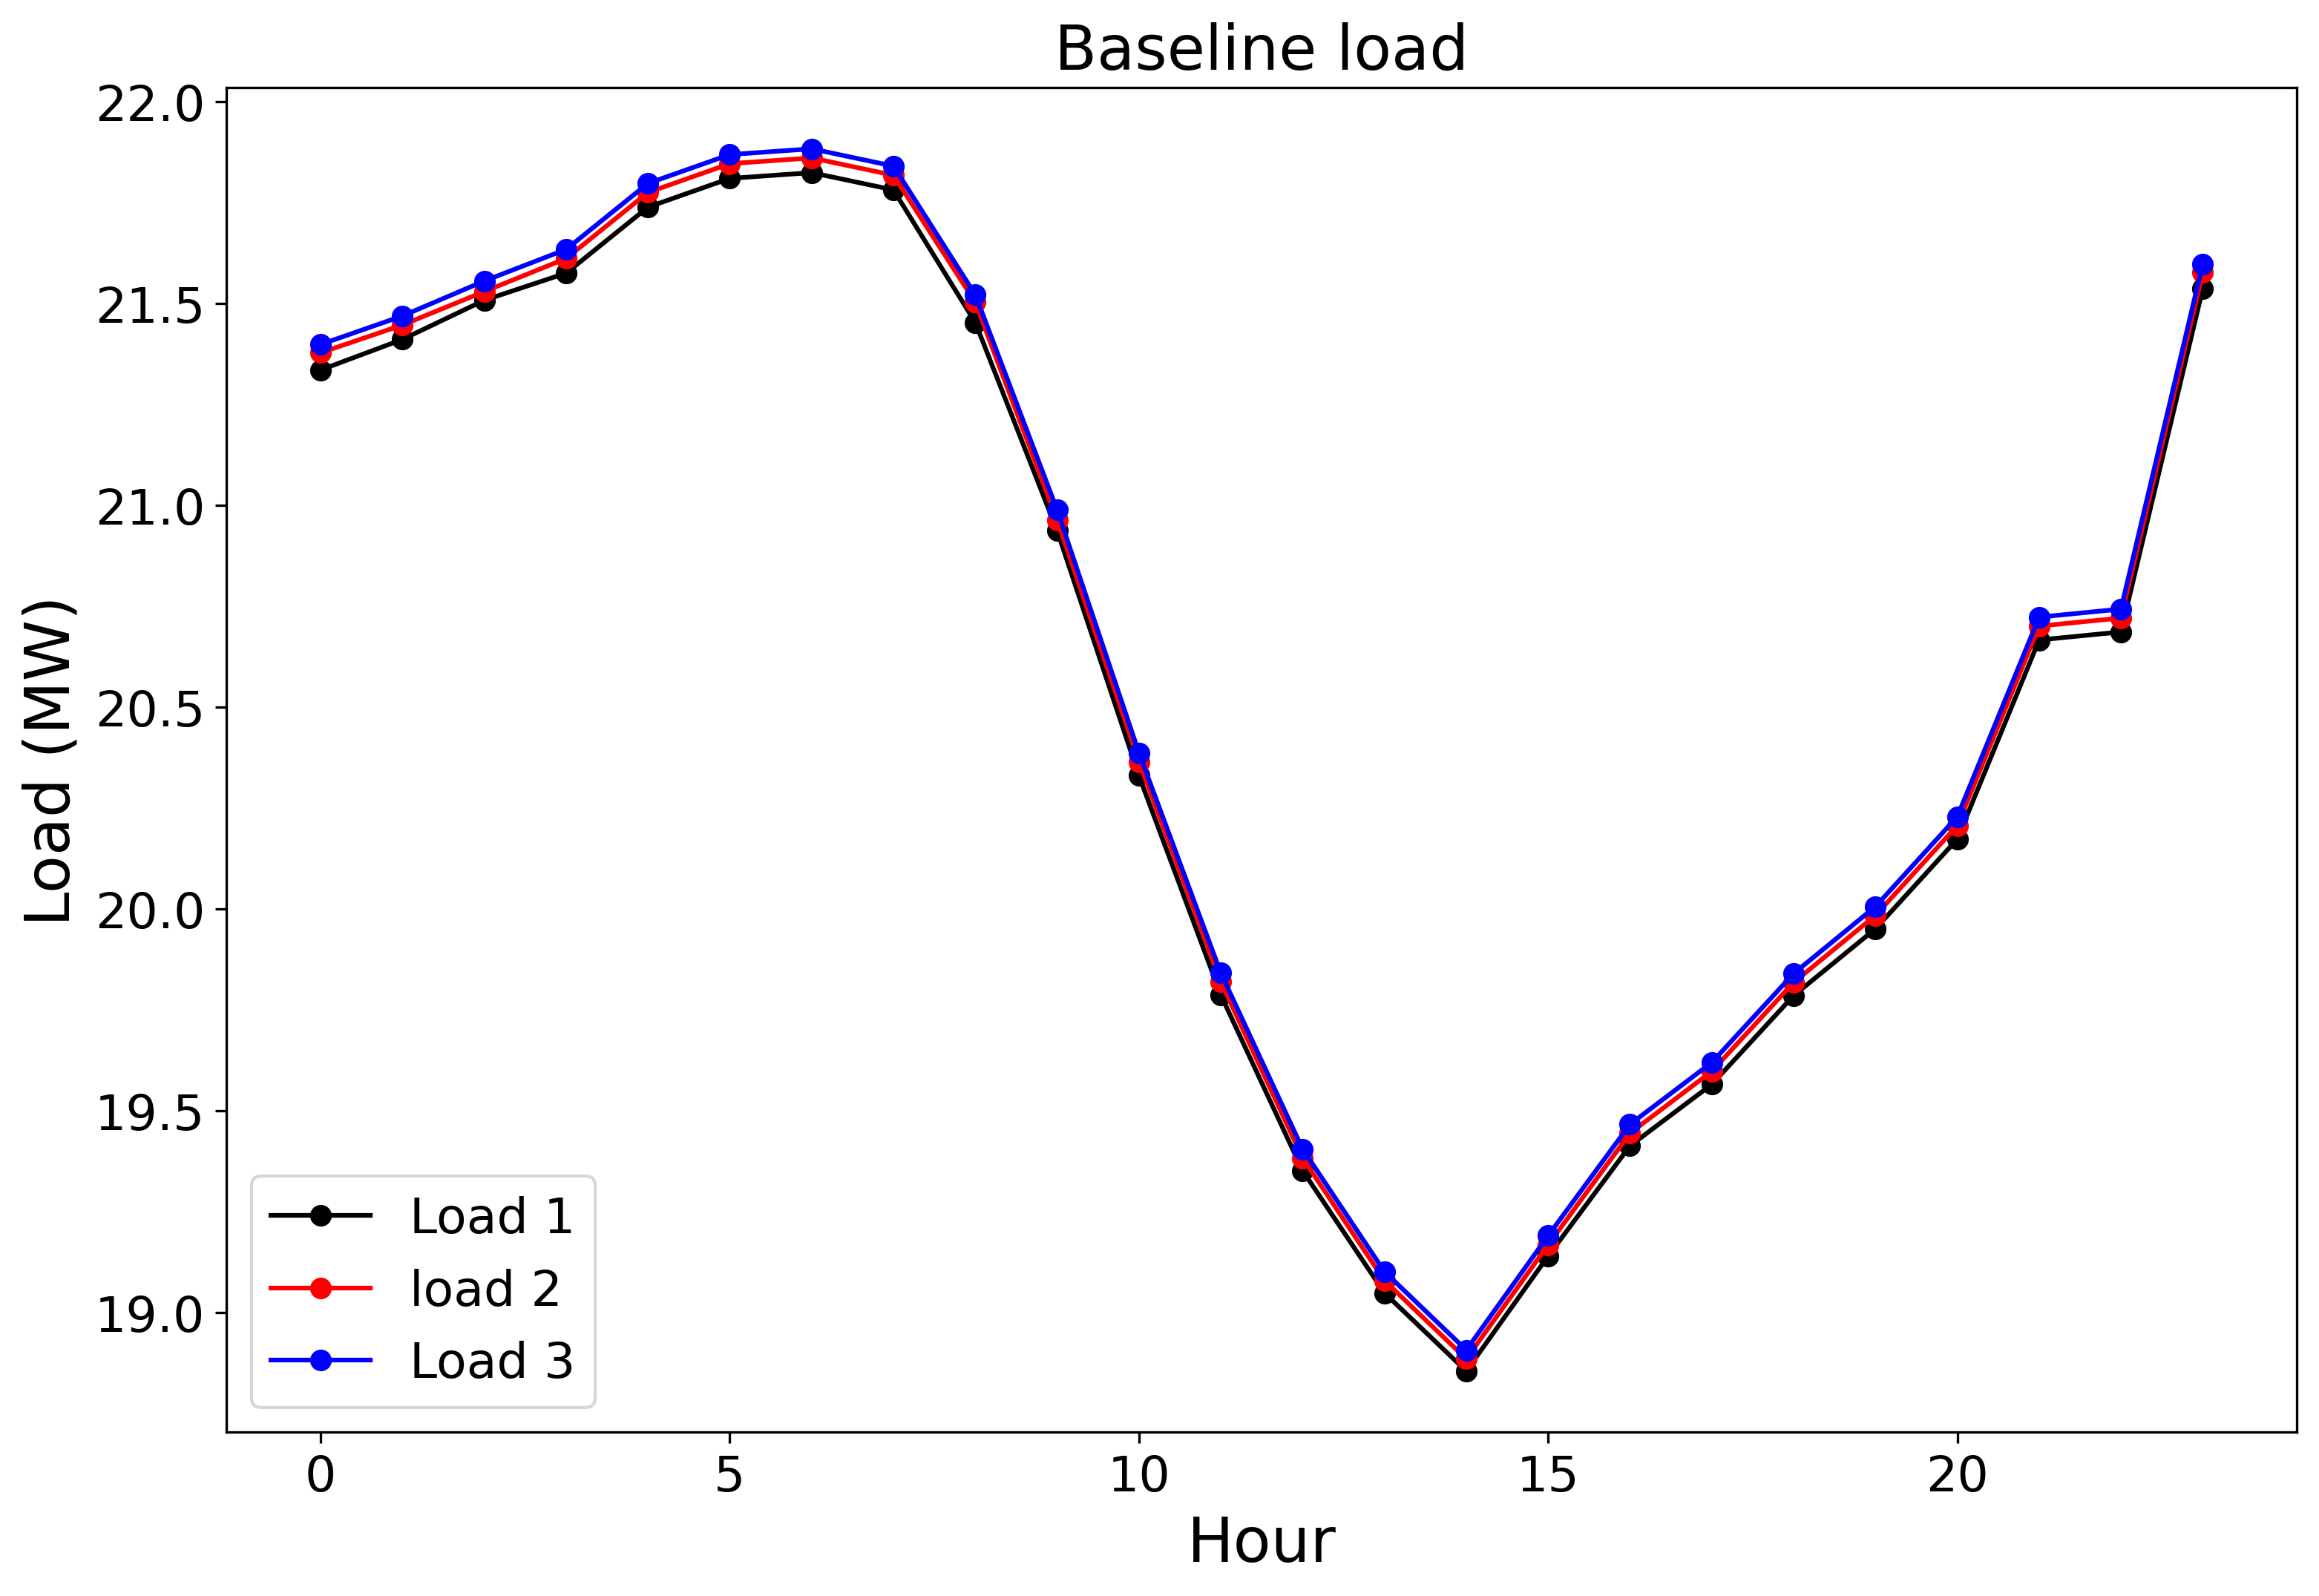

In [31]:
# Load set point
fig = plt.figure(figsize=(12,8), dpi=300)
plt.plot(PC_all_hour[0, :], linestyle="-", marker="o", color="black", label="Load 1")
plt.plot(PC_all_hour[1, :], linestyle="-", marker="o", color="red", label="load 2")
plt.plot(PC_all_hour[2, :], linestyle="-", marker="o", color="blue", label="Load 3")
plt.legend(fontsize=16)
plt.xlabel("Hour", fontsize=20)
plt.ylabel("Load (MW)", fontsize=20)
plt.title("Baseline load", fontsize=20)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig_name = figdir+"PC.png"
fig.savefig(fig_name, dpi=300)
plt.show()

In [17]:
# Calculate power mismatch
Pmis_all_hour = np.zeros((nhours,nsample))
# Calculate P mis
for h in range(nhours):
    for i in range(nsample):
        Pmis_all_hour[h,i] = Pmis_wind_hour[h,i] - np.sum(PC_all_hour[:, h]) + np.sum(PB_all_hour[:, h, i])

### Power mismatch boxplot

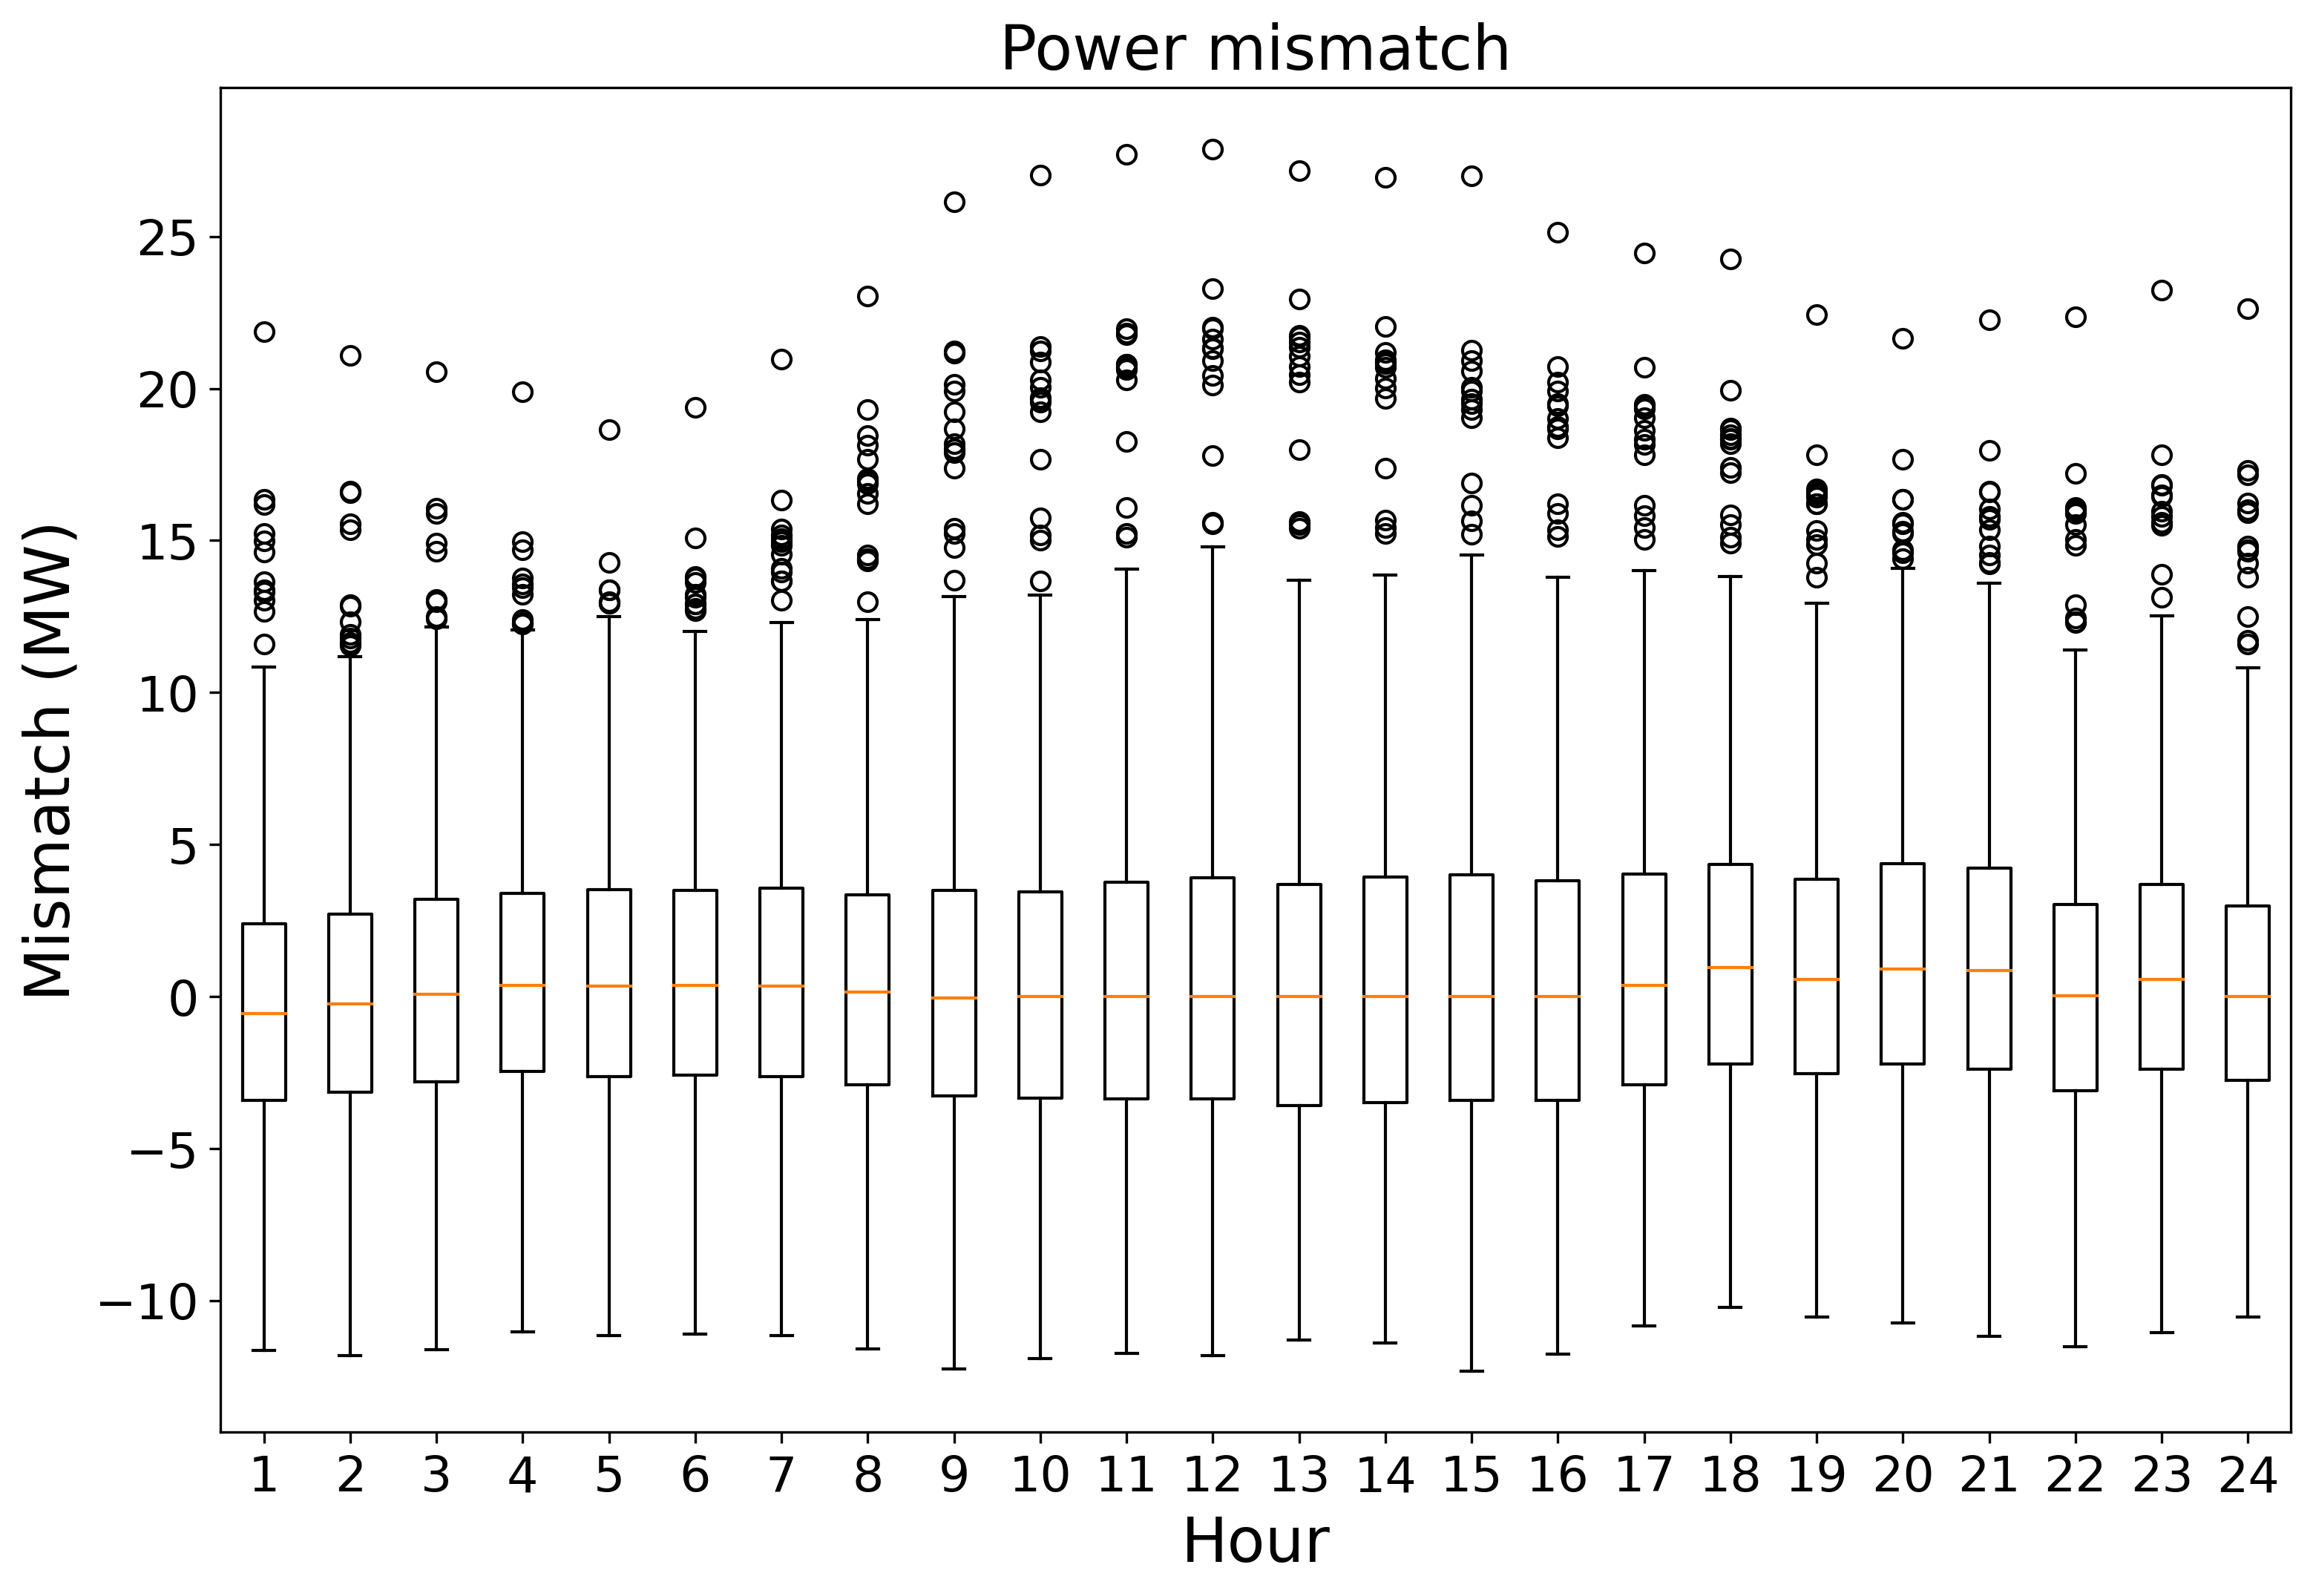

In [18]:
fig = plt.figure(figsize=(12,8), dpi=300)
Pmis_plot = Pmis_all_hour[:, :].tolist()
plt.boxplot(Pmis_plot)
plt.title("Power mismatch", fontsize=20)
plt.xlabel("Hour", fontsize=20)
plt.ylabel("Mismatch (MW)", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig_name = figdir+"Power_mismatch.png"
fig.savefig(fig_name, dpi=300)
plt.show()

## Power generation plot
### Power generation bar plot

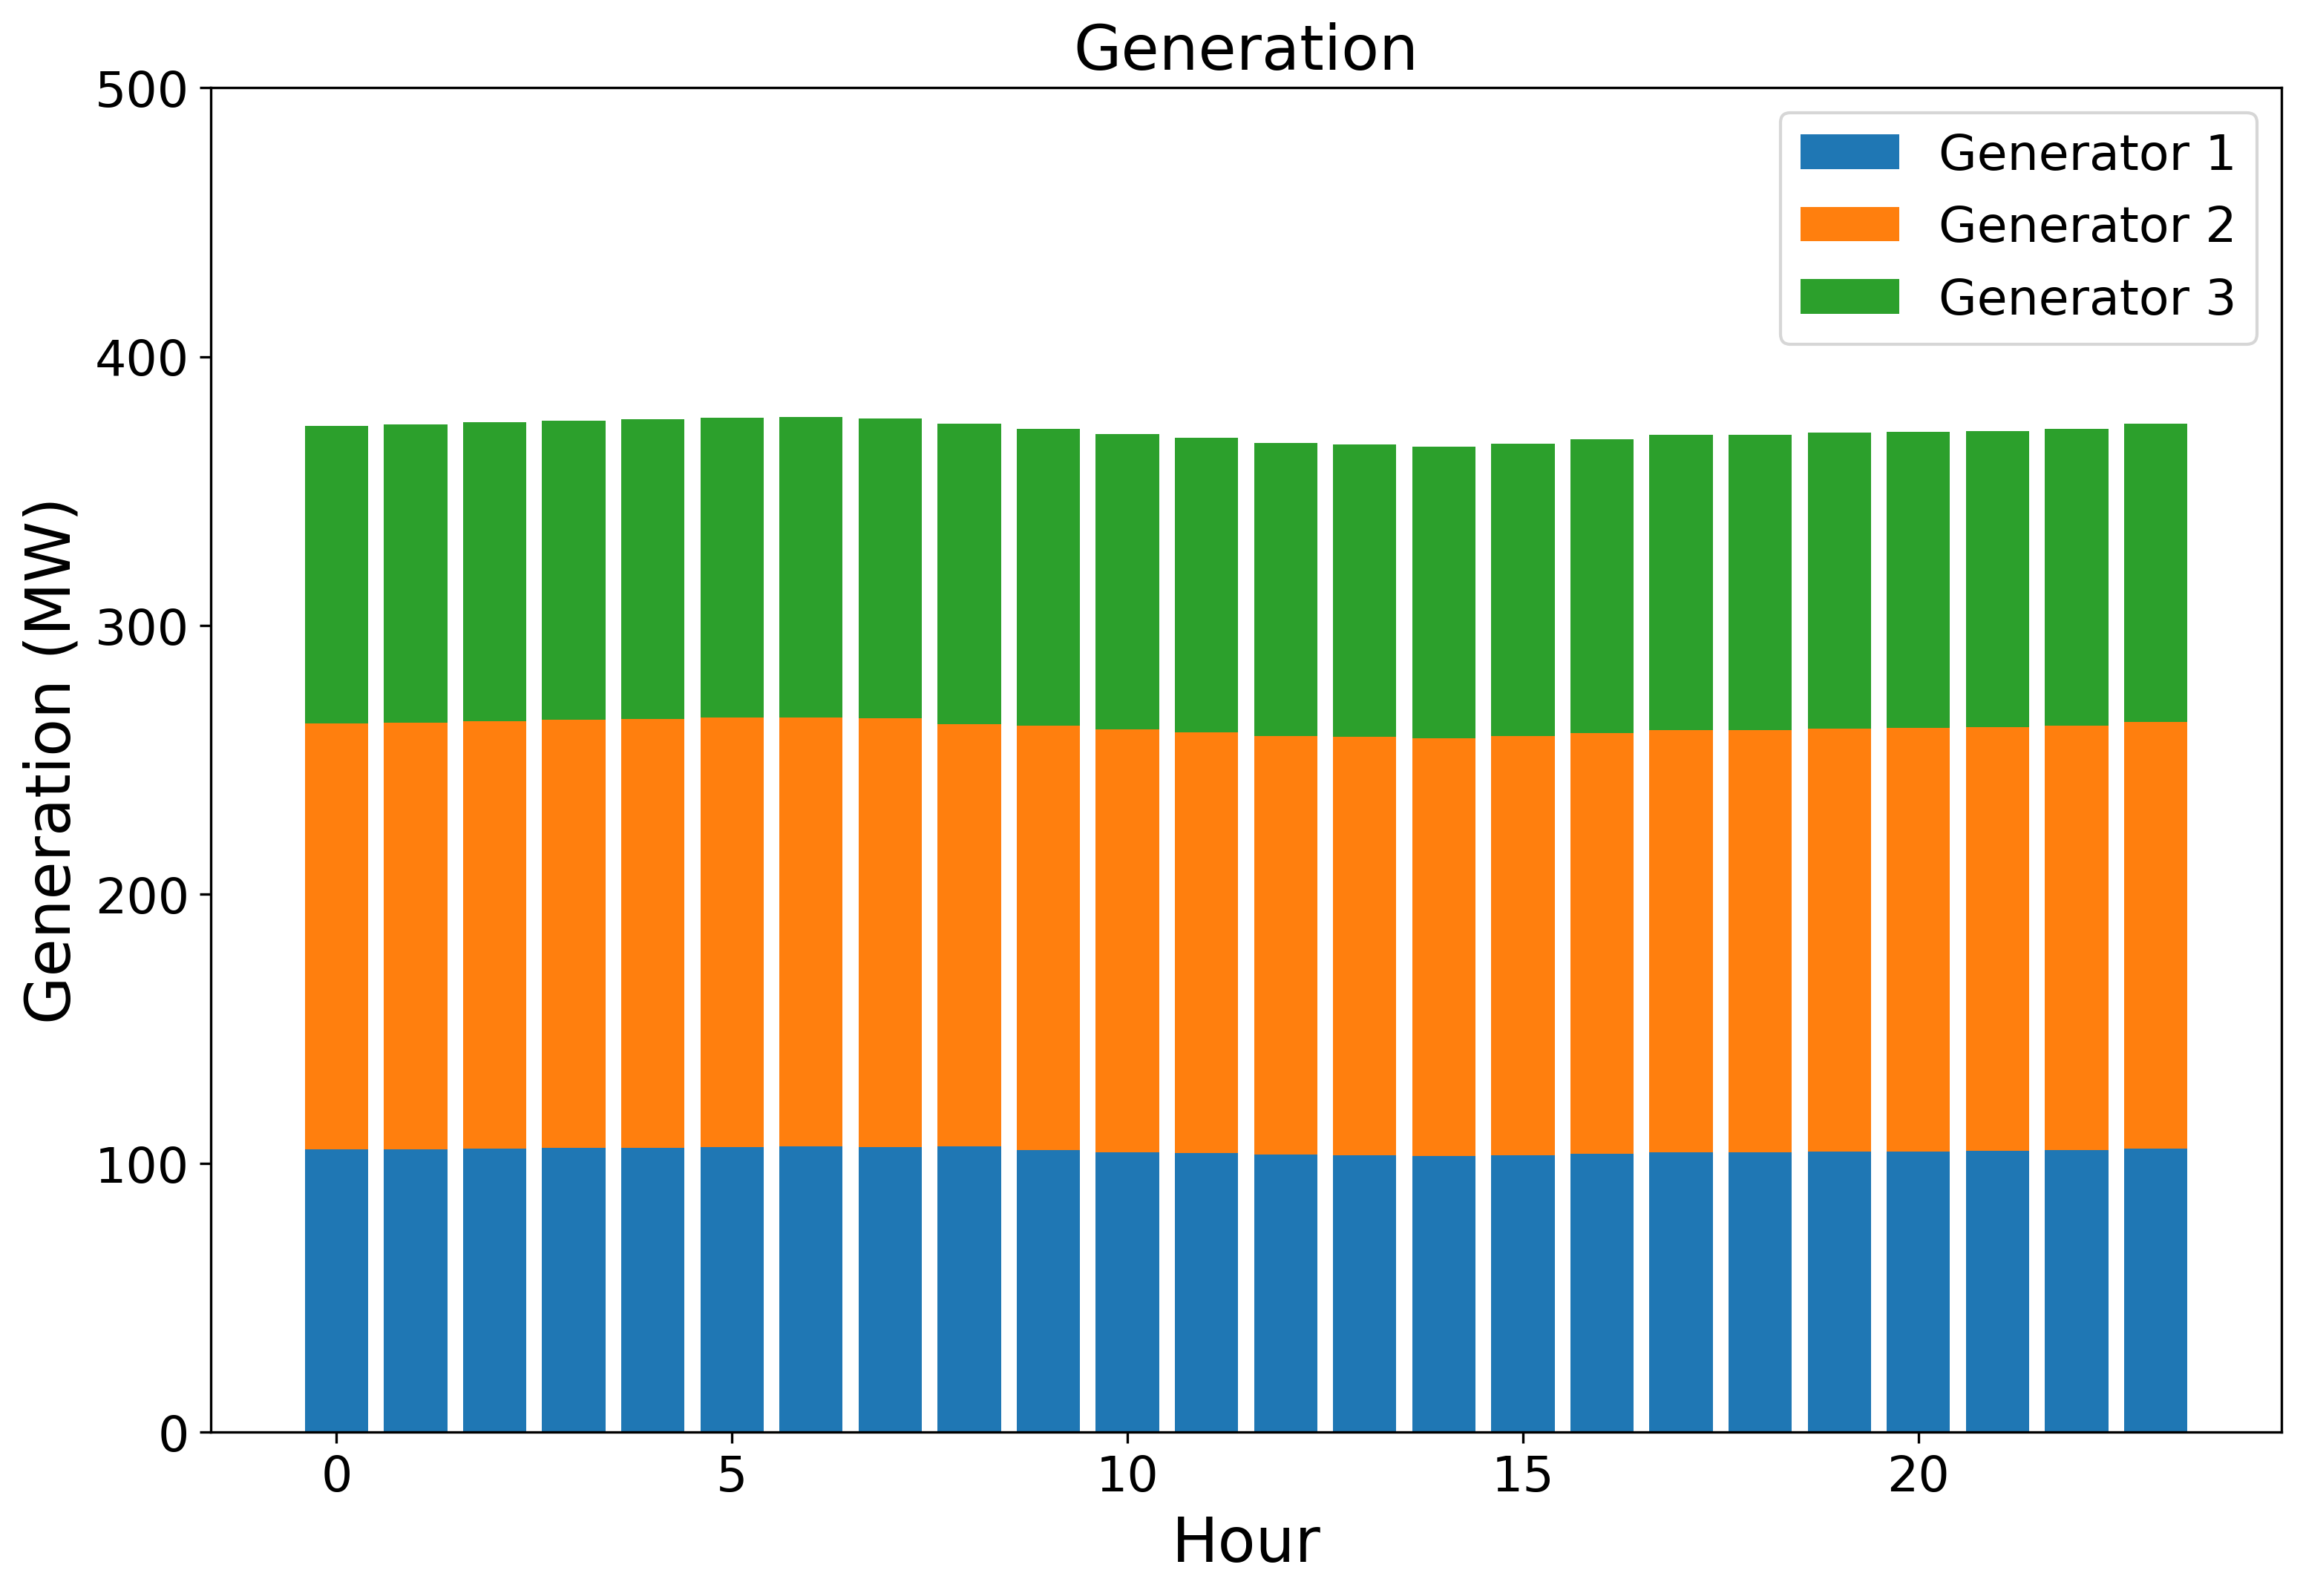

In [19]:
# Read PG data
PG_all_hour = np.zeros((NG, nhours))
PG_sum_hour = np.zeros(nhours)
PW_f_hour = np.zeros(nhours)

for h in range(nhours):
    model = models[h]
    PG_all = model.PG[:]()
    PG_all = np.array(PG_all).reshape(NG)*baseMVA

    for i in range(NG):
        PG_one = PG_all[i]
        PG_all_hour[i, h] = PG_one

    PG_sum_hour[h] = np.sum(PG_all_hour[:,h])

    # Wind power forecast
    # PW_f_hour[h] = np.median(PW_data[h, :])*baseMVA

fig = plt.figure(figsize=(12,8), dpi=300)

plt.bar(range(nhours), PG_all_hour[0], label="Generator 1")
plt.bar(range(nhours), PG_all_hour[1], bottom=PG_all_hour[0], label="Generator 2")
plt.bar(range(nhours), PG_all_hour[2], bottom=PG_all_hour[0]+PG_all_hour[1], label="Generator 3")
# plt.bar(range(nhours), PW_f_hour, bottom=PG_all_hour[0]+PG_all_hour[1]+PG_all_hour[2], label="Wind")

plt.xlabel("Hour", fontsize=20)
plt.ylabel("Generation (MW)", fontsize=20)
plt.ylim(0, 500)
plt.title("Generation", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
fig_name = figdir+"Generation.png"
fig.savefig(fig_name, dpi=300)
plt.show()

### Power generation line plot

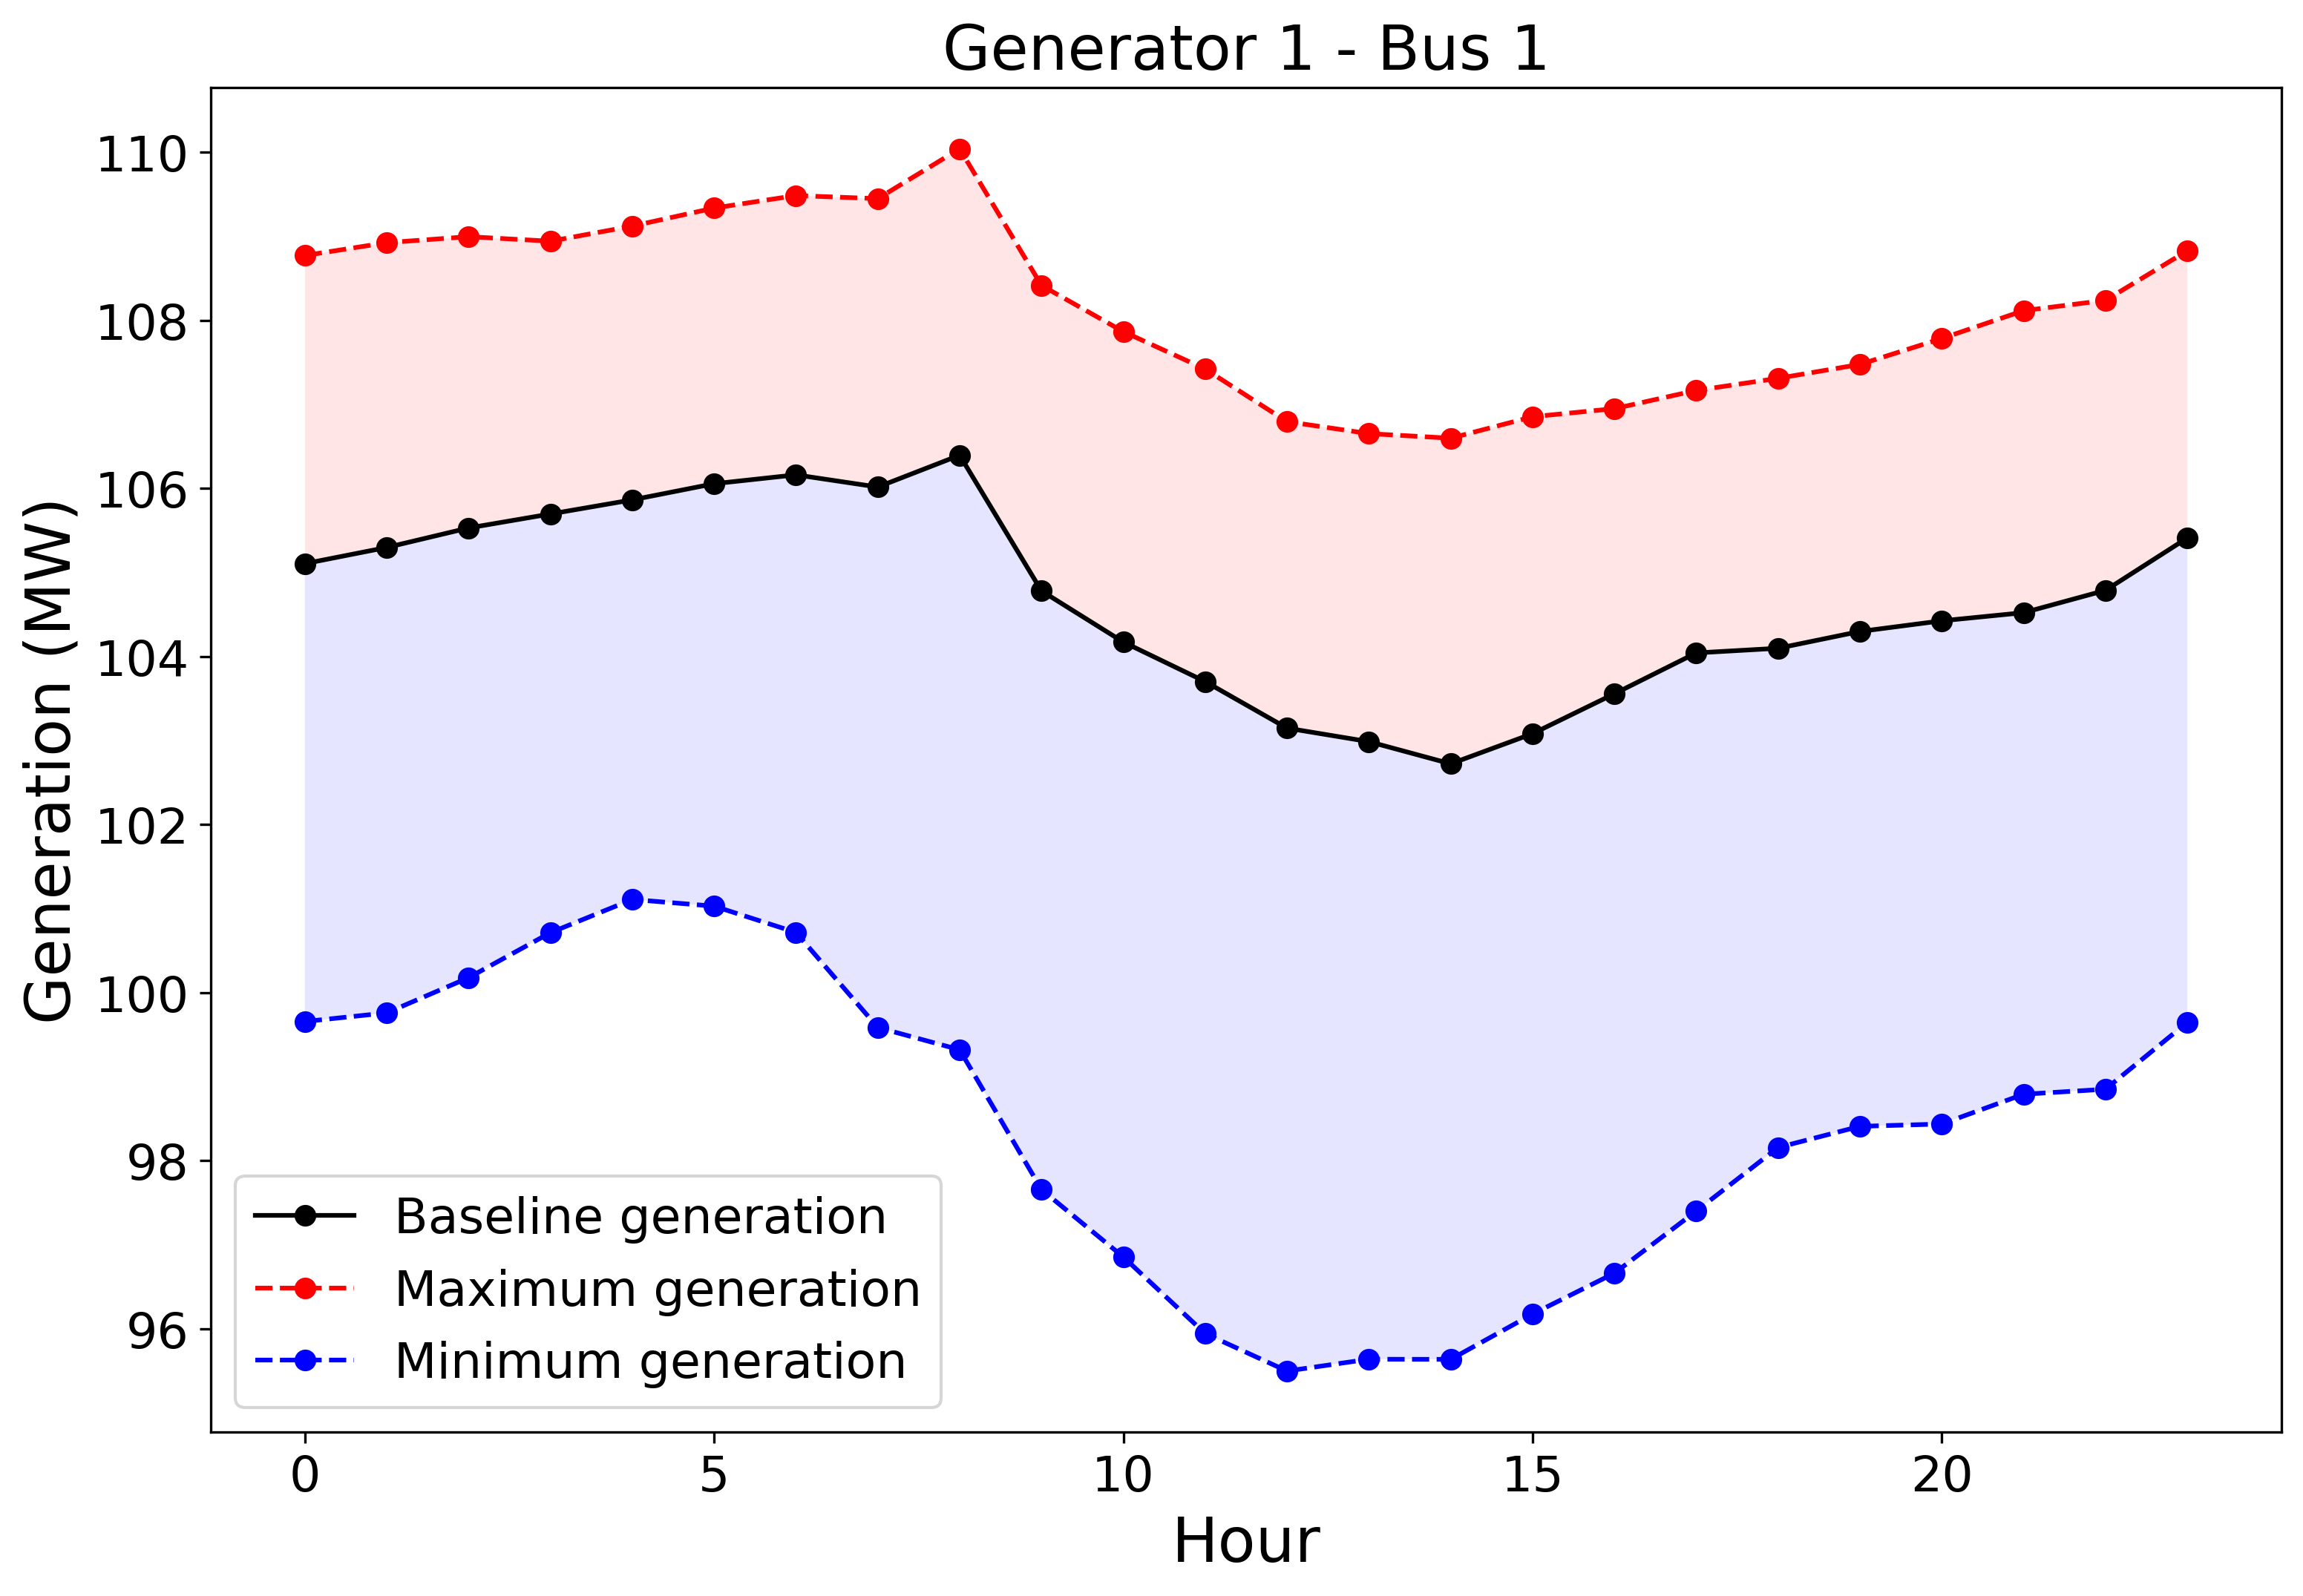

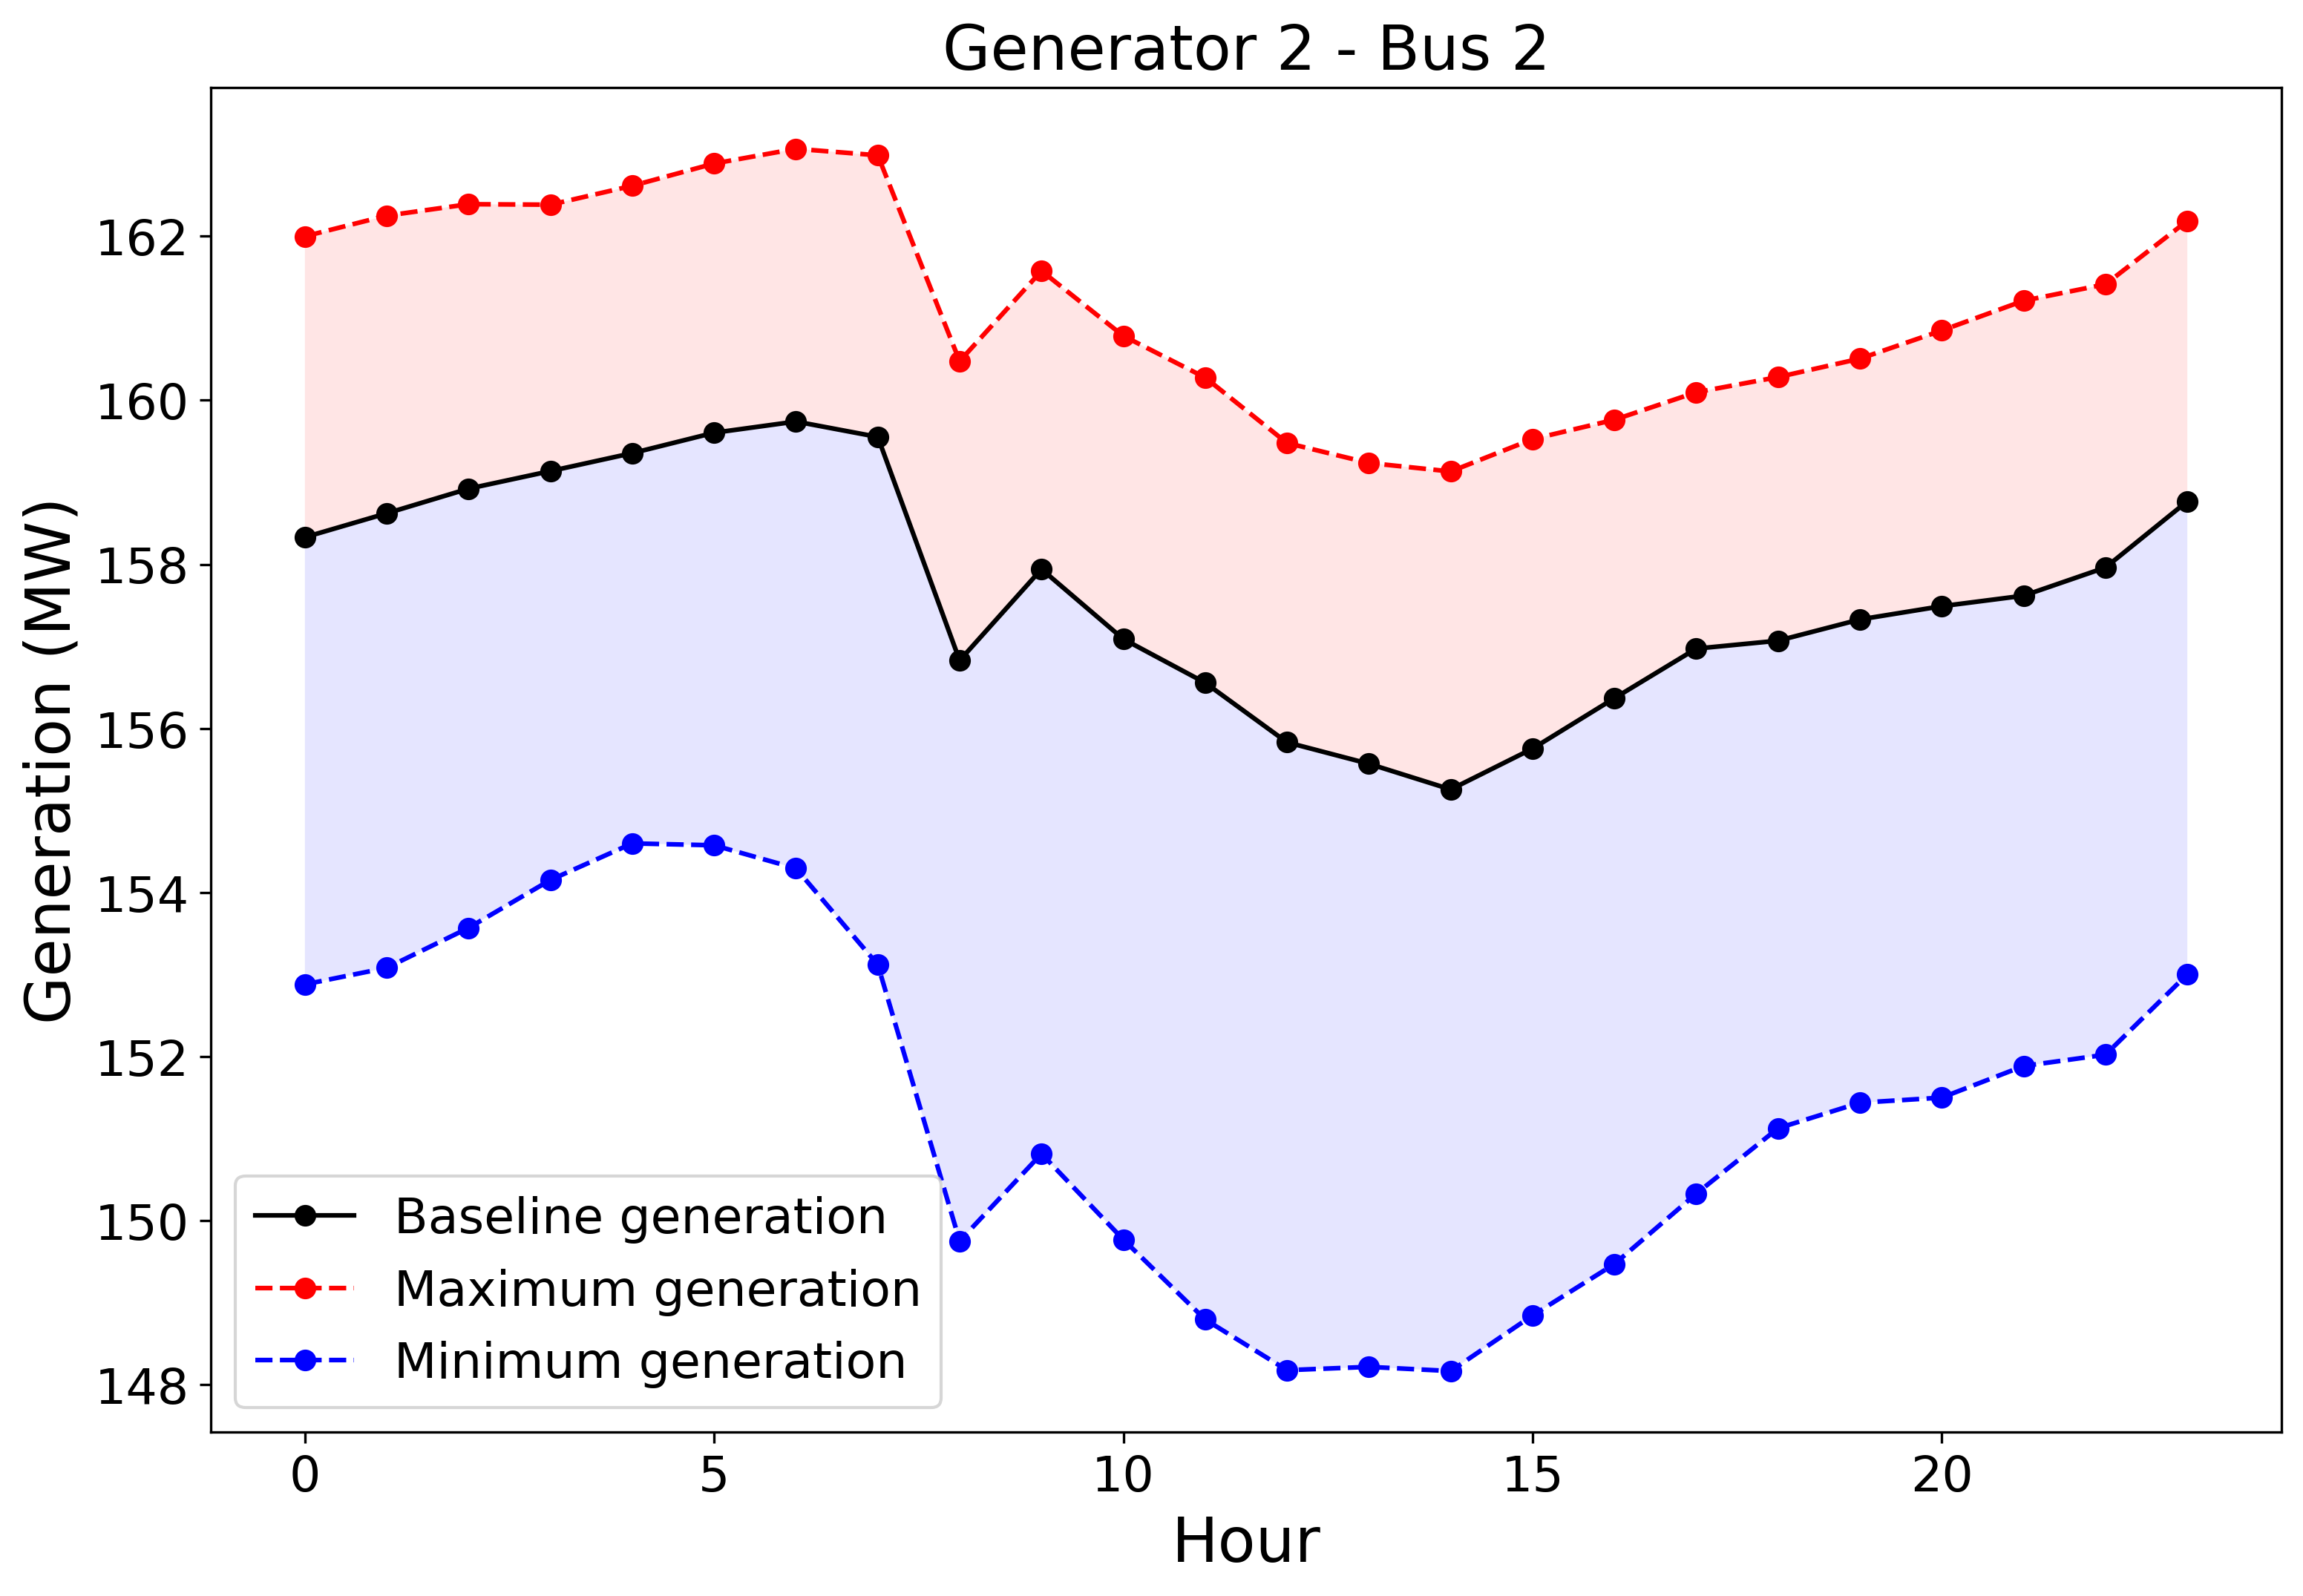

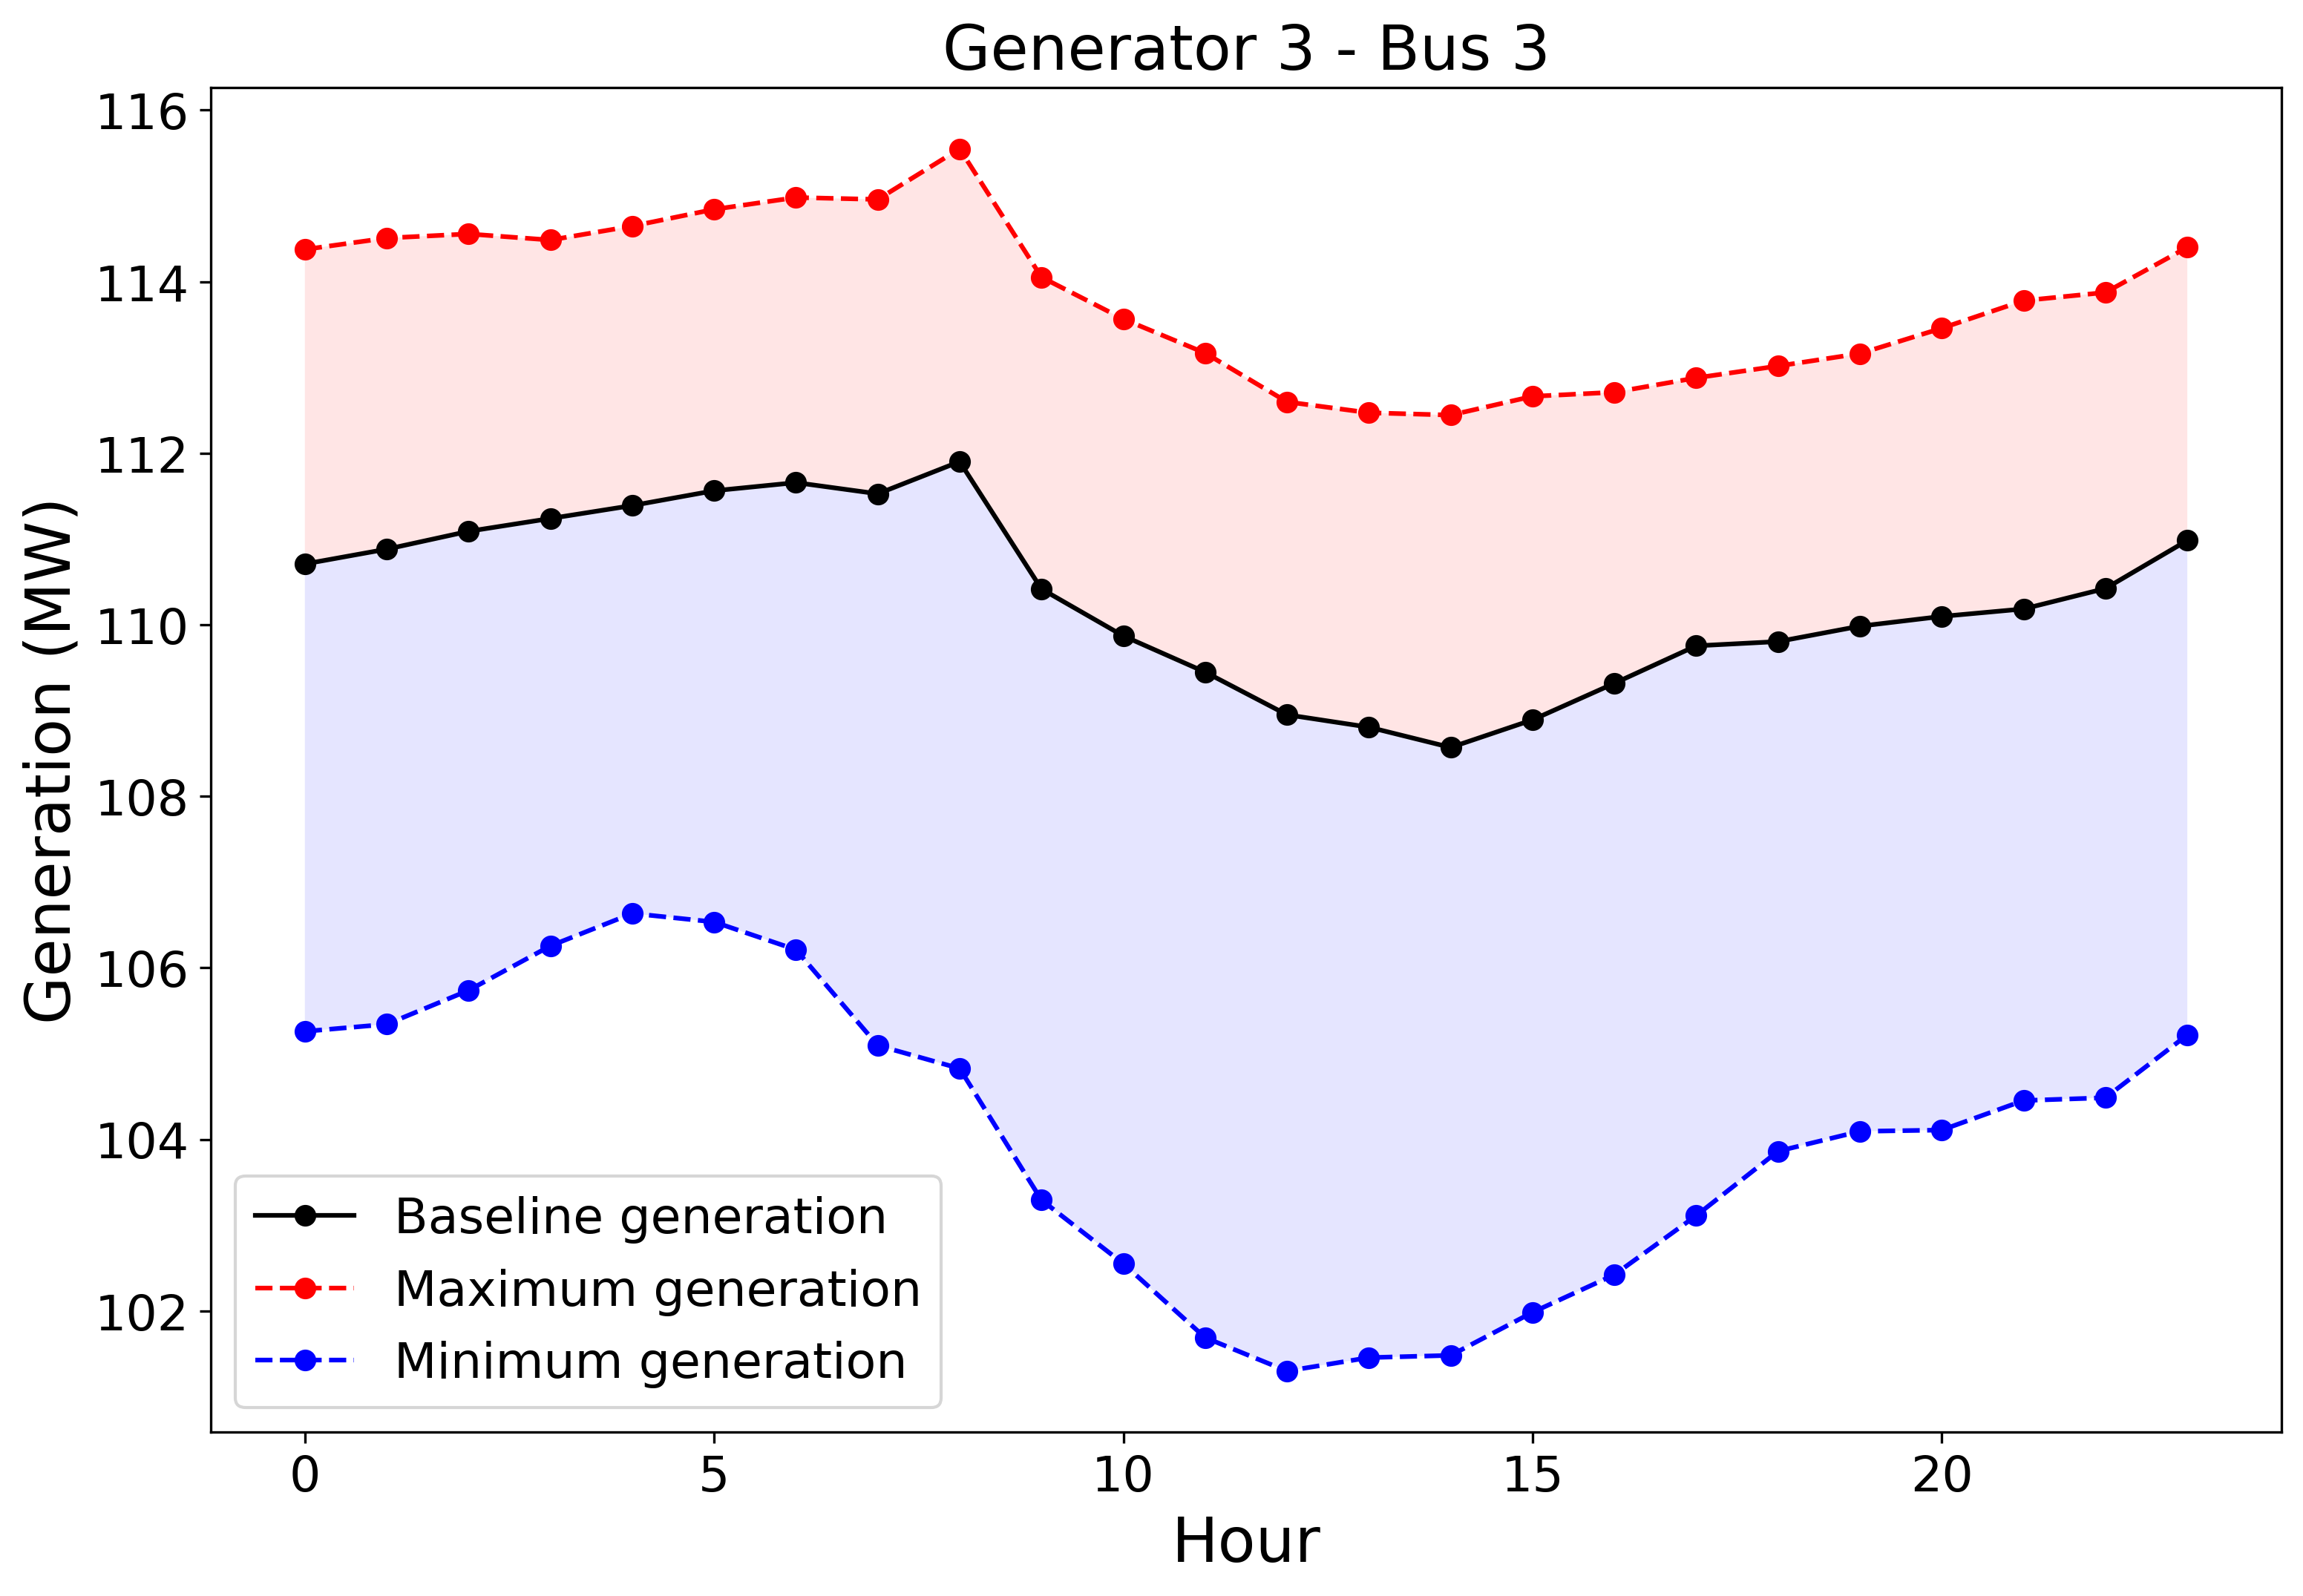

In [20]:
for i in range(NG):
    fig = plt.figure(figsize=(12,8), dpi=300)
    plt.plot(PG_all_hour[i], linestyle="-", marker="o", color="black", label="Baseline generation")
    plt.plot(PG_all_hour[i] + RG_up_all_hour[i, :], linestyle="--", marker="o", color="red", label="Maximum generation")
    plt.plot(PG_all_hour[i] - RG_down_all_hour[i, :], linestyle="--", marker="o", color="blue", label="Minimum generation")
    plt.fill_between(range(nhours), PG_all_hour[i], PG_all_hour[i] + RG_up_all_hour[i, :], facecolor="red", alpha=0.1)
    plt.fill_between(range(nhours), PG_all_hour[i], PG_all_hour[i] - RG_down_all_hour[i, :], facecolor="blue", alpha=0.1)
    plt.legend(fontsize=16)
    plt.xlabel("Hour", fontsize=20)
    plt.ylabel("Generation (MW)", fontsize=20)
    plt.title("Generator %d - Bus %d" %((i+1), gen_bus[i]), fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    fig_name = figdir+"PG_RG_up_down_%d" %i
    fig.savefig(fig_name, dpi=300)
    plt.show()

In [21]:
# Line flow

flow = np.zeros(NBr)
for i in range(NBr):
    for j in range(NB):
        flow[i] = flow[i] + Bf[i,j]*models[22].Va[j]()
    

flow*baseMVA

array([ 104.67211213,   42.76030086,  -67.92624517,  110.30597306,
         46.70766505,  -74.01327715, -157.84457244,   83.83133126,
        -61.91184723])

## Cost plots
### Generator cost curve

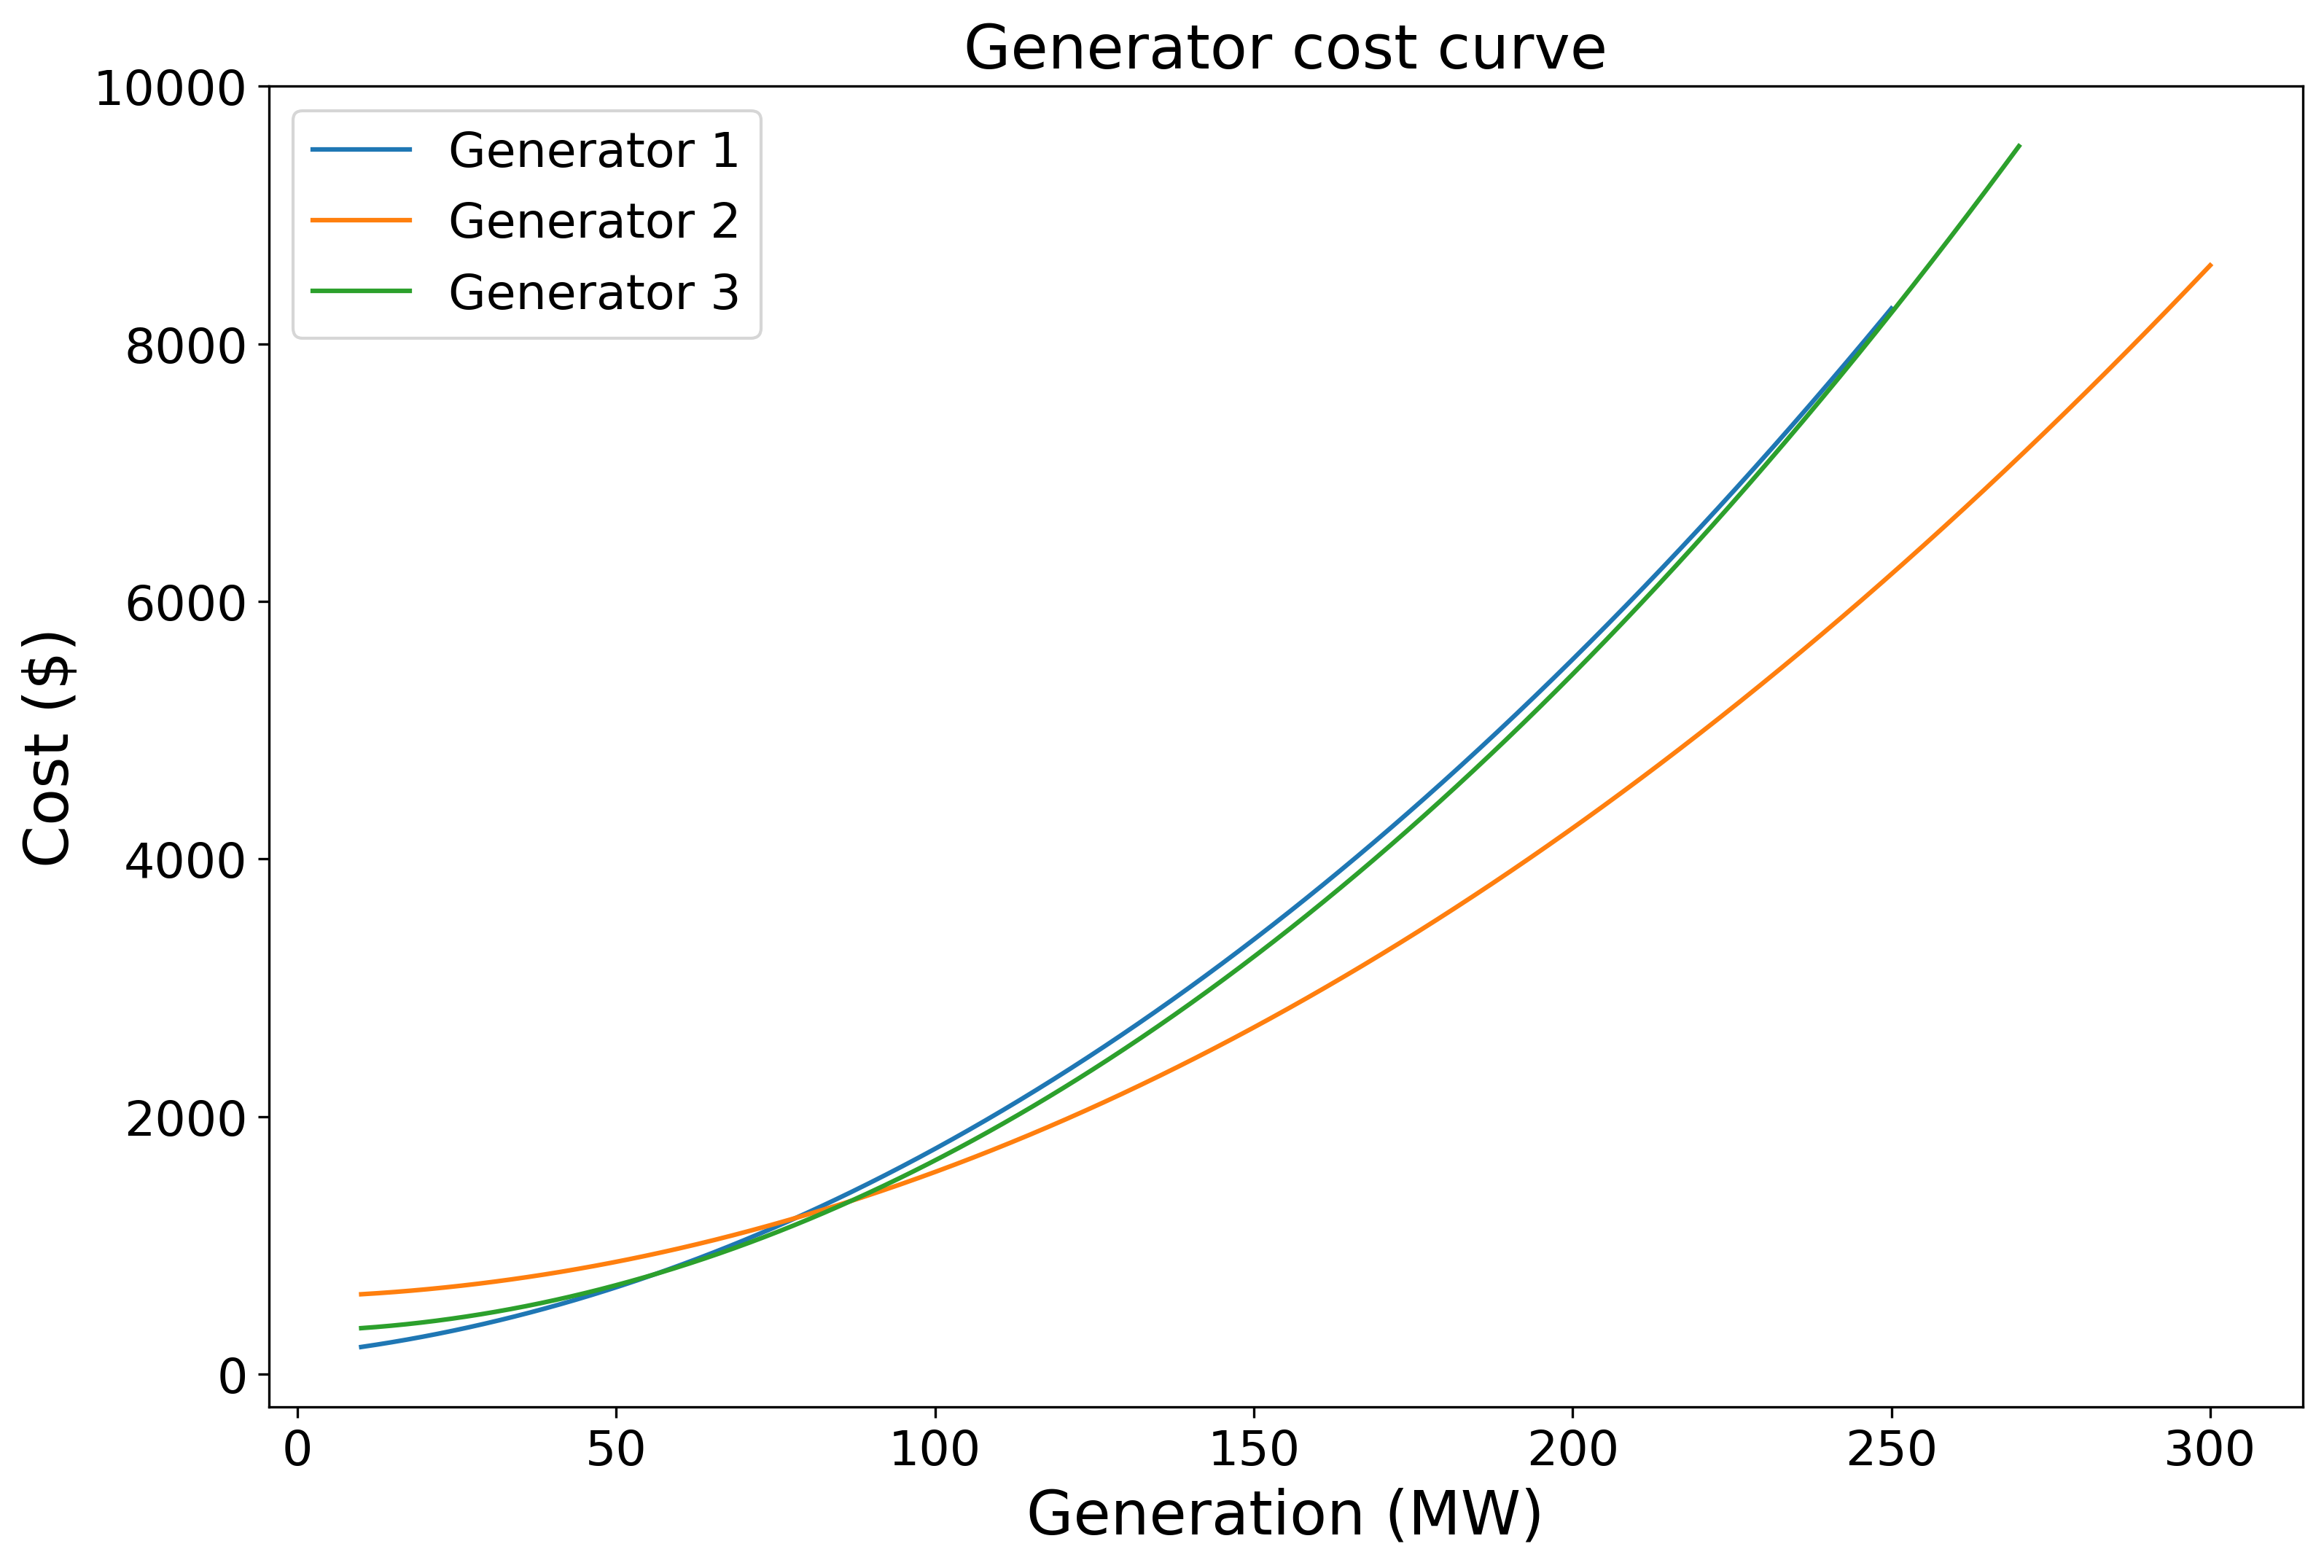

In [22]:
# Plot cost curve
fig = plt.figure(figsize=(12,8), dpi=300)

for i in range(NG):
    x = np.linspace(Pmin[i]*baseMVA, Pmax[i]*baseMVA, 1000)
    gencost = CG0[i] + CG1[i]/baseMVA * x +  CG2[i]/baseMVA**2 * x**2
    plt.plot(x, gencost, label="Generator %d" %(i+1))

plt.legend(fontsize=16)
plt.xlabel("Generation (MW)", fontsize=20)
plt.ylabel("Cost ($)", fontsize=20)
plt.title("Generator cost curve", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig_name = figdir+"Gen_cost_curve.png"
fig.savefig(fig_name, dpi=300)
plt.show()

### Generator marginal cost curve

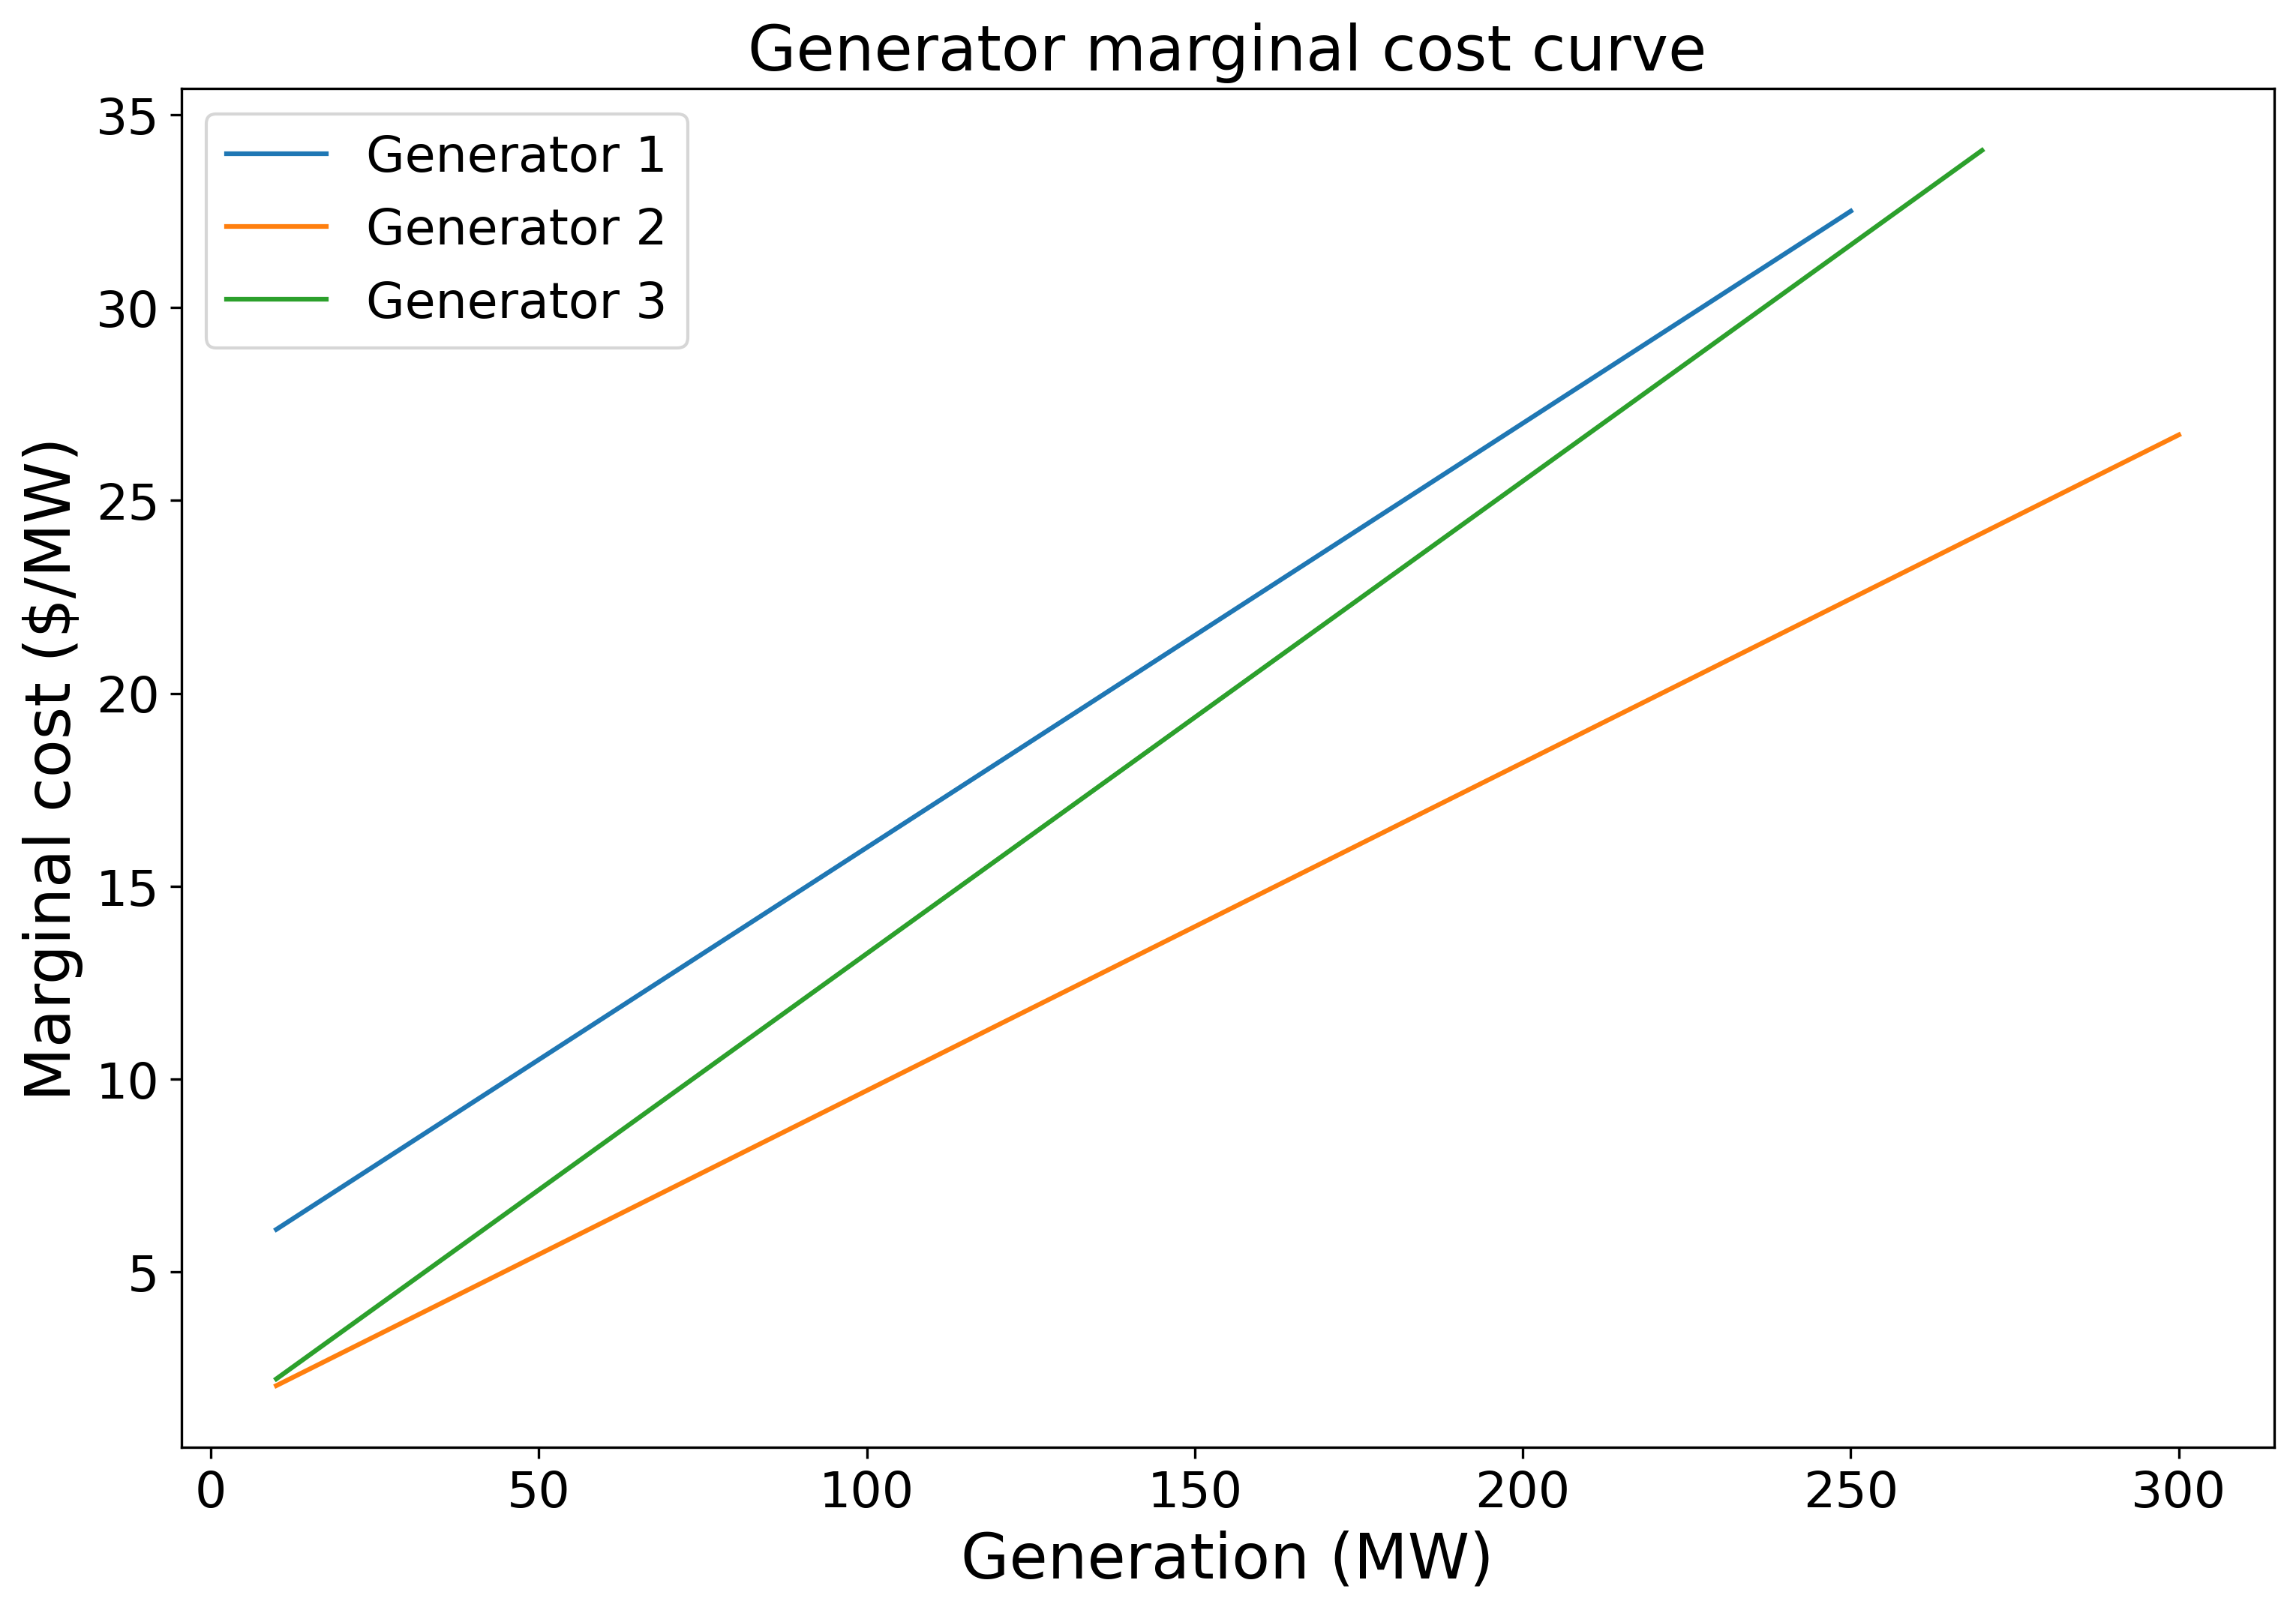

In [23]:
# Plot cost curve
fig = plt.figure(figsize=(12,8), dpi=300)

for i in range(NG):
    x = np.linspace(Pmin[i]*baseMVA, Pmax[i]*baseMVA, 1000)
    genmc = CG1[i]/baseMVA +  CG2[i]/baseMVA**2 * x
    plt.plot(x, genmc, label="Generator %d" %(i+1))

plt.legend(fontsize=16)
plt.xlabel("Generation (MW)", fontsize=20)
plt.ylabel("Marginal cost ($/MW)", fontsize=20)
plt.title("Generator marginal cost curve", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
fig_name = figdir+"Gen_marginal_cost_curve.png"
fig.savefig(fig_name, dpi=300)
plt.show()

In [24]:
# Calculate different costs

gen_cost_hour = np.zeros((NG,nhours))
gen_r_cost_hour = np.zeros((NG,nhours))
total_cost_hour = np.zeros(nhours)

for h in range(nhours):
    gen_cost,gen_r_cost,total_cost = cost(models[h],CG0,CG1,CG2,CRG_up,CRG_down,CRL_up,CRL_down,NG,NL)
    gen_cost_hour[:,h] = gen_cost
    gen_r_cost_hour[:,h] = gen_r_cost
    total_cost_hour[h] = total_cost

### Generation cost bar plot

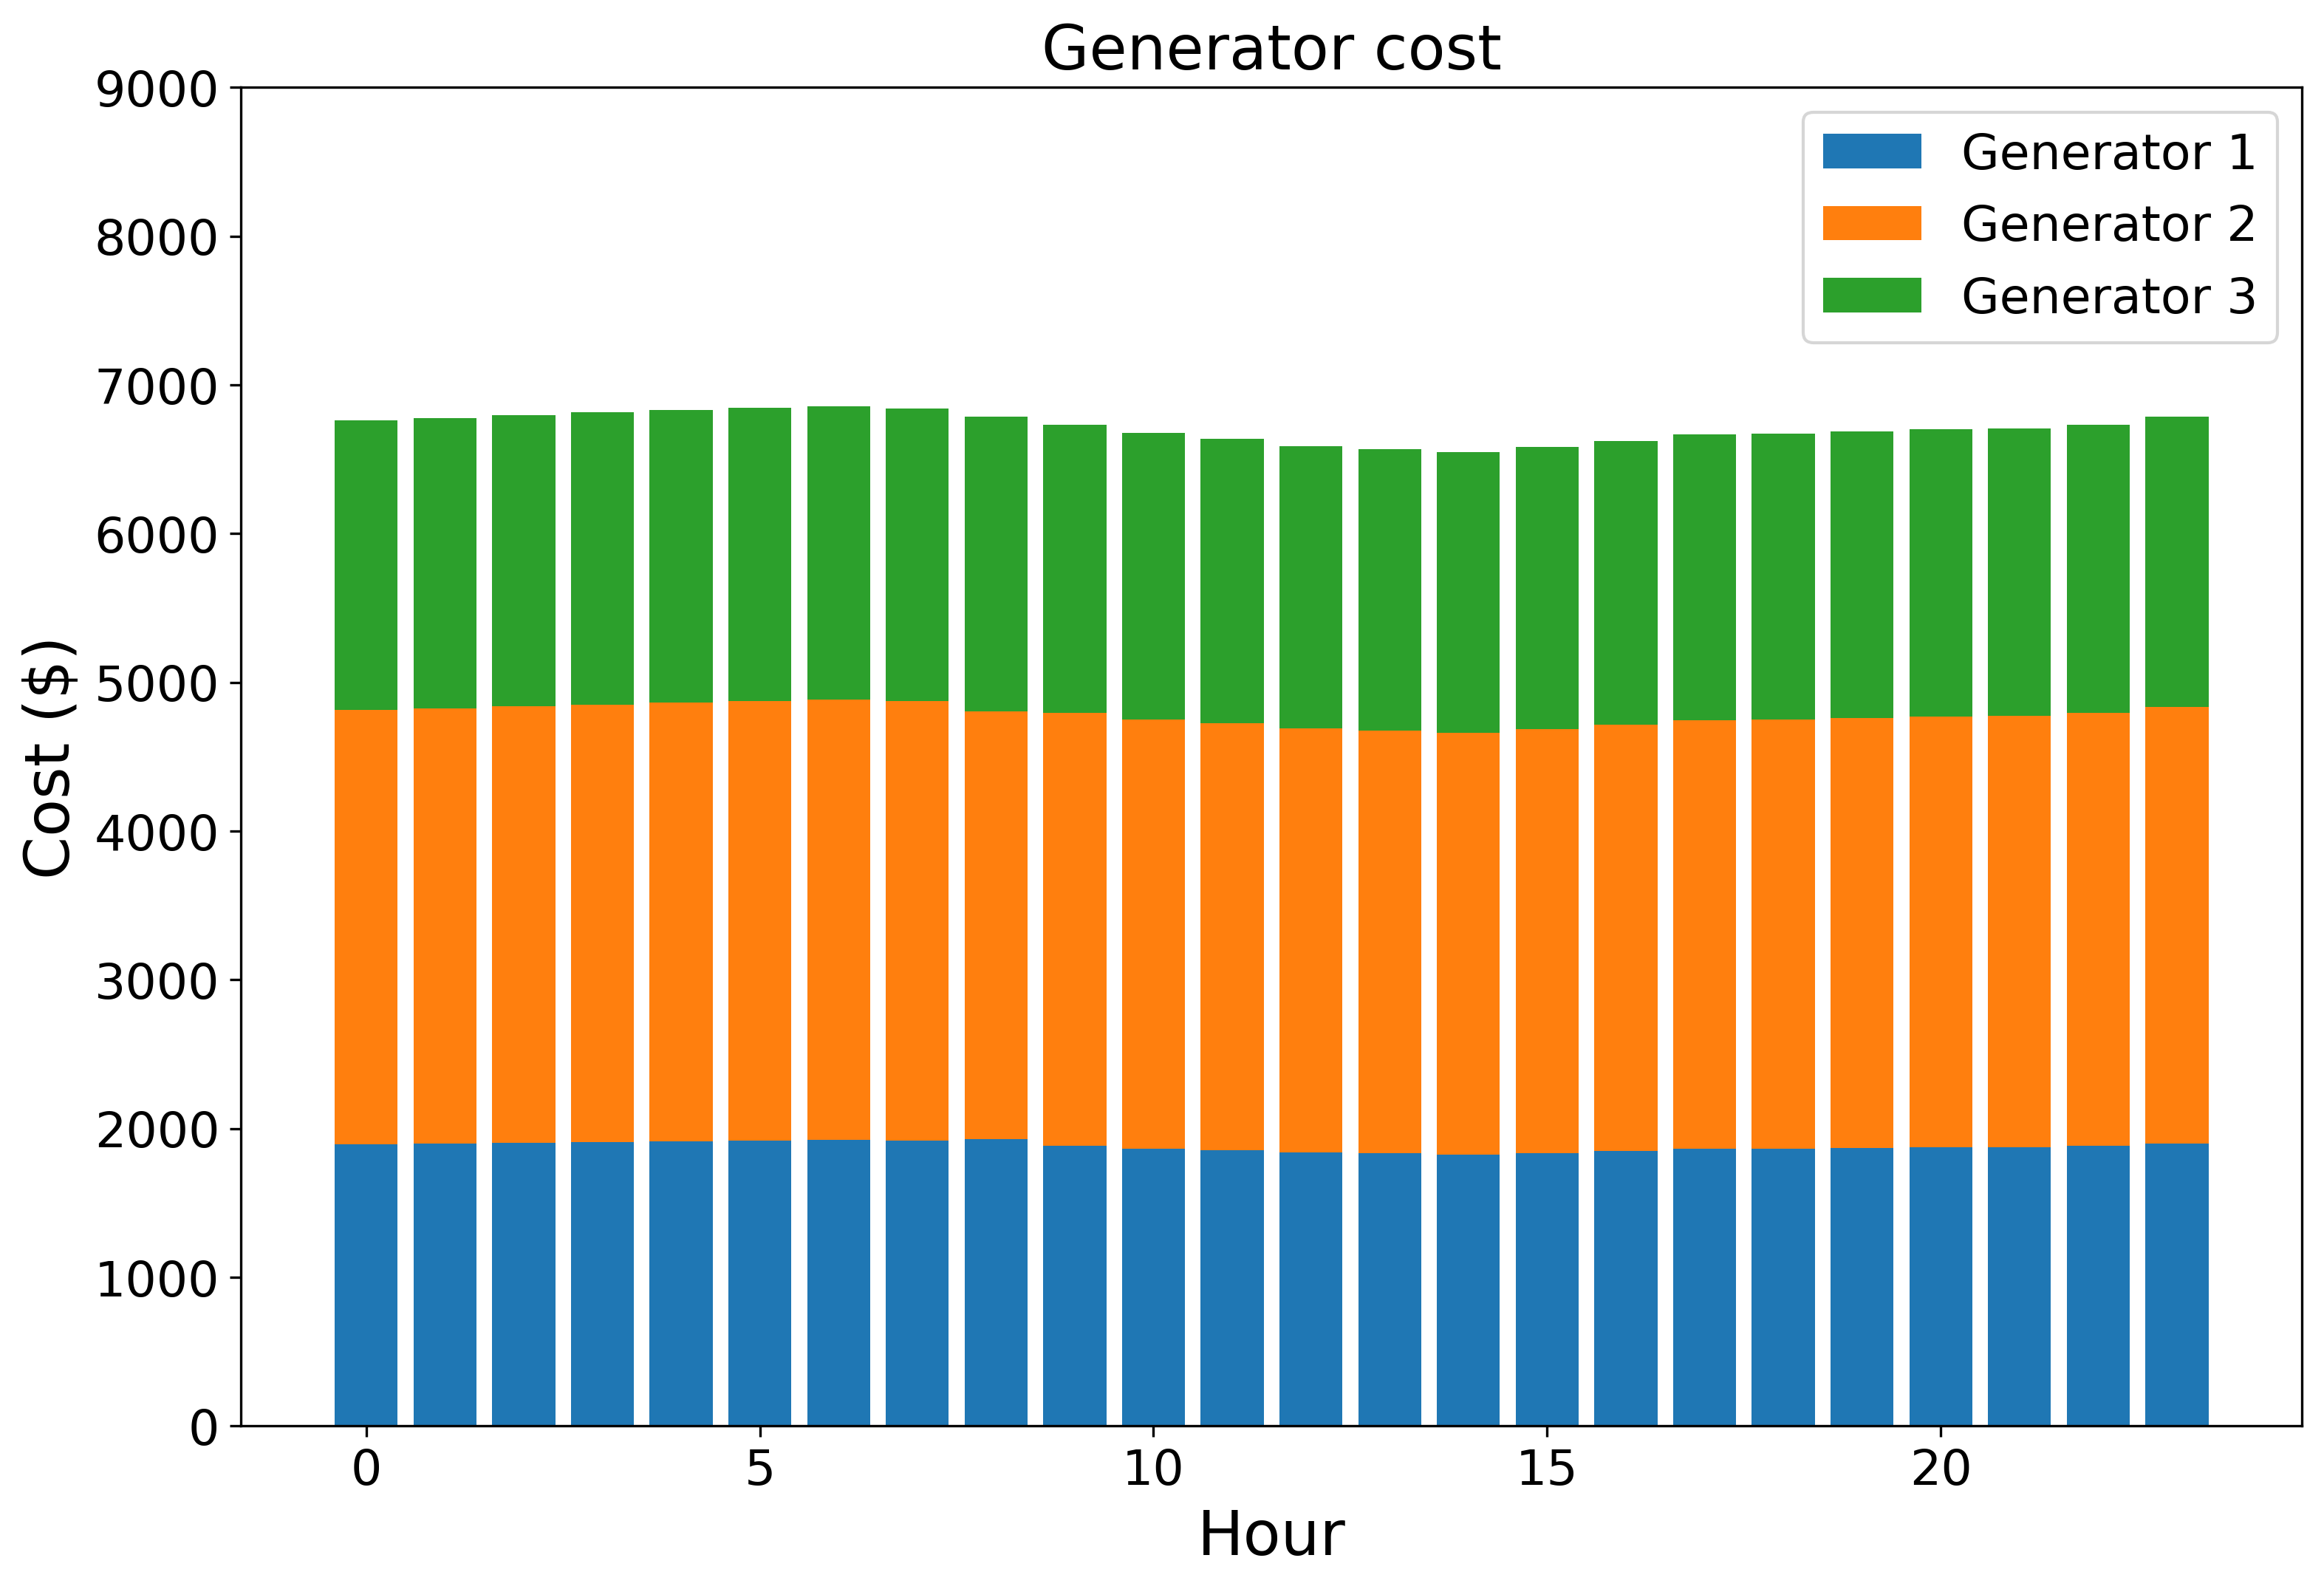

In [25]:
fig = plt.figure(figsize=(12,8), dpi=300)

plt.bar(range(nhours), gen_cost_hour[0, :], label="Generator 1")
plt.bar(range(nhours), gen_cost_hour[1, :], bottom=gen_cost_hour[0, :], label="Generator 2")
plt.bar(range(nhours), gen_cost_hour[2, :], bottom=gen_cost_hour[1, :]+gen_cost_hour[0, :], label="Generator 3")

plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0, 9000)
plt.xlabel("Hour", fontsize=20)
plt.ylabel("Cost ($)", fontsize=20)
plt.title("Generator cost", fontsize=20)
fig.savefig(figdir+"gen_cost.png", dpi=300)

plt.show()

### Generation reserve bar plot

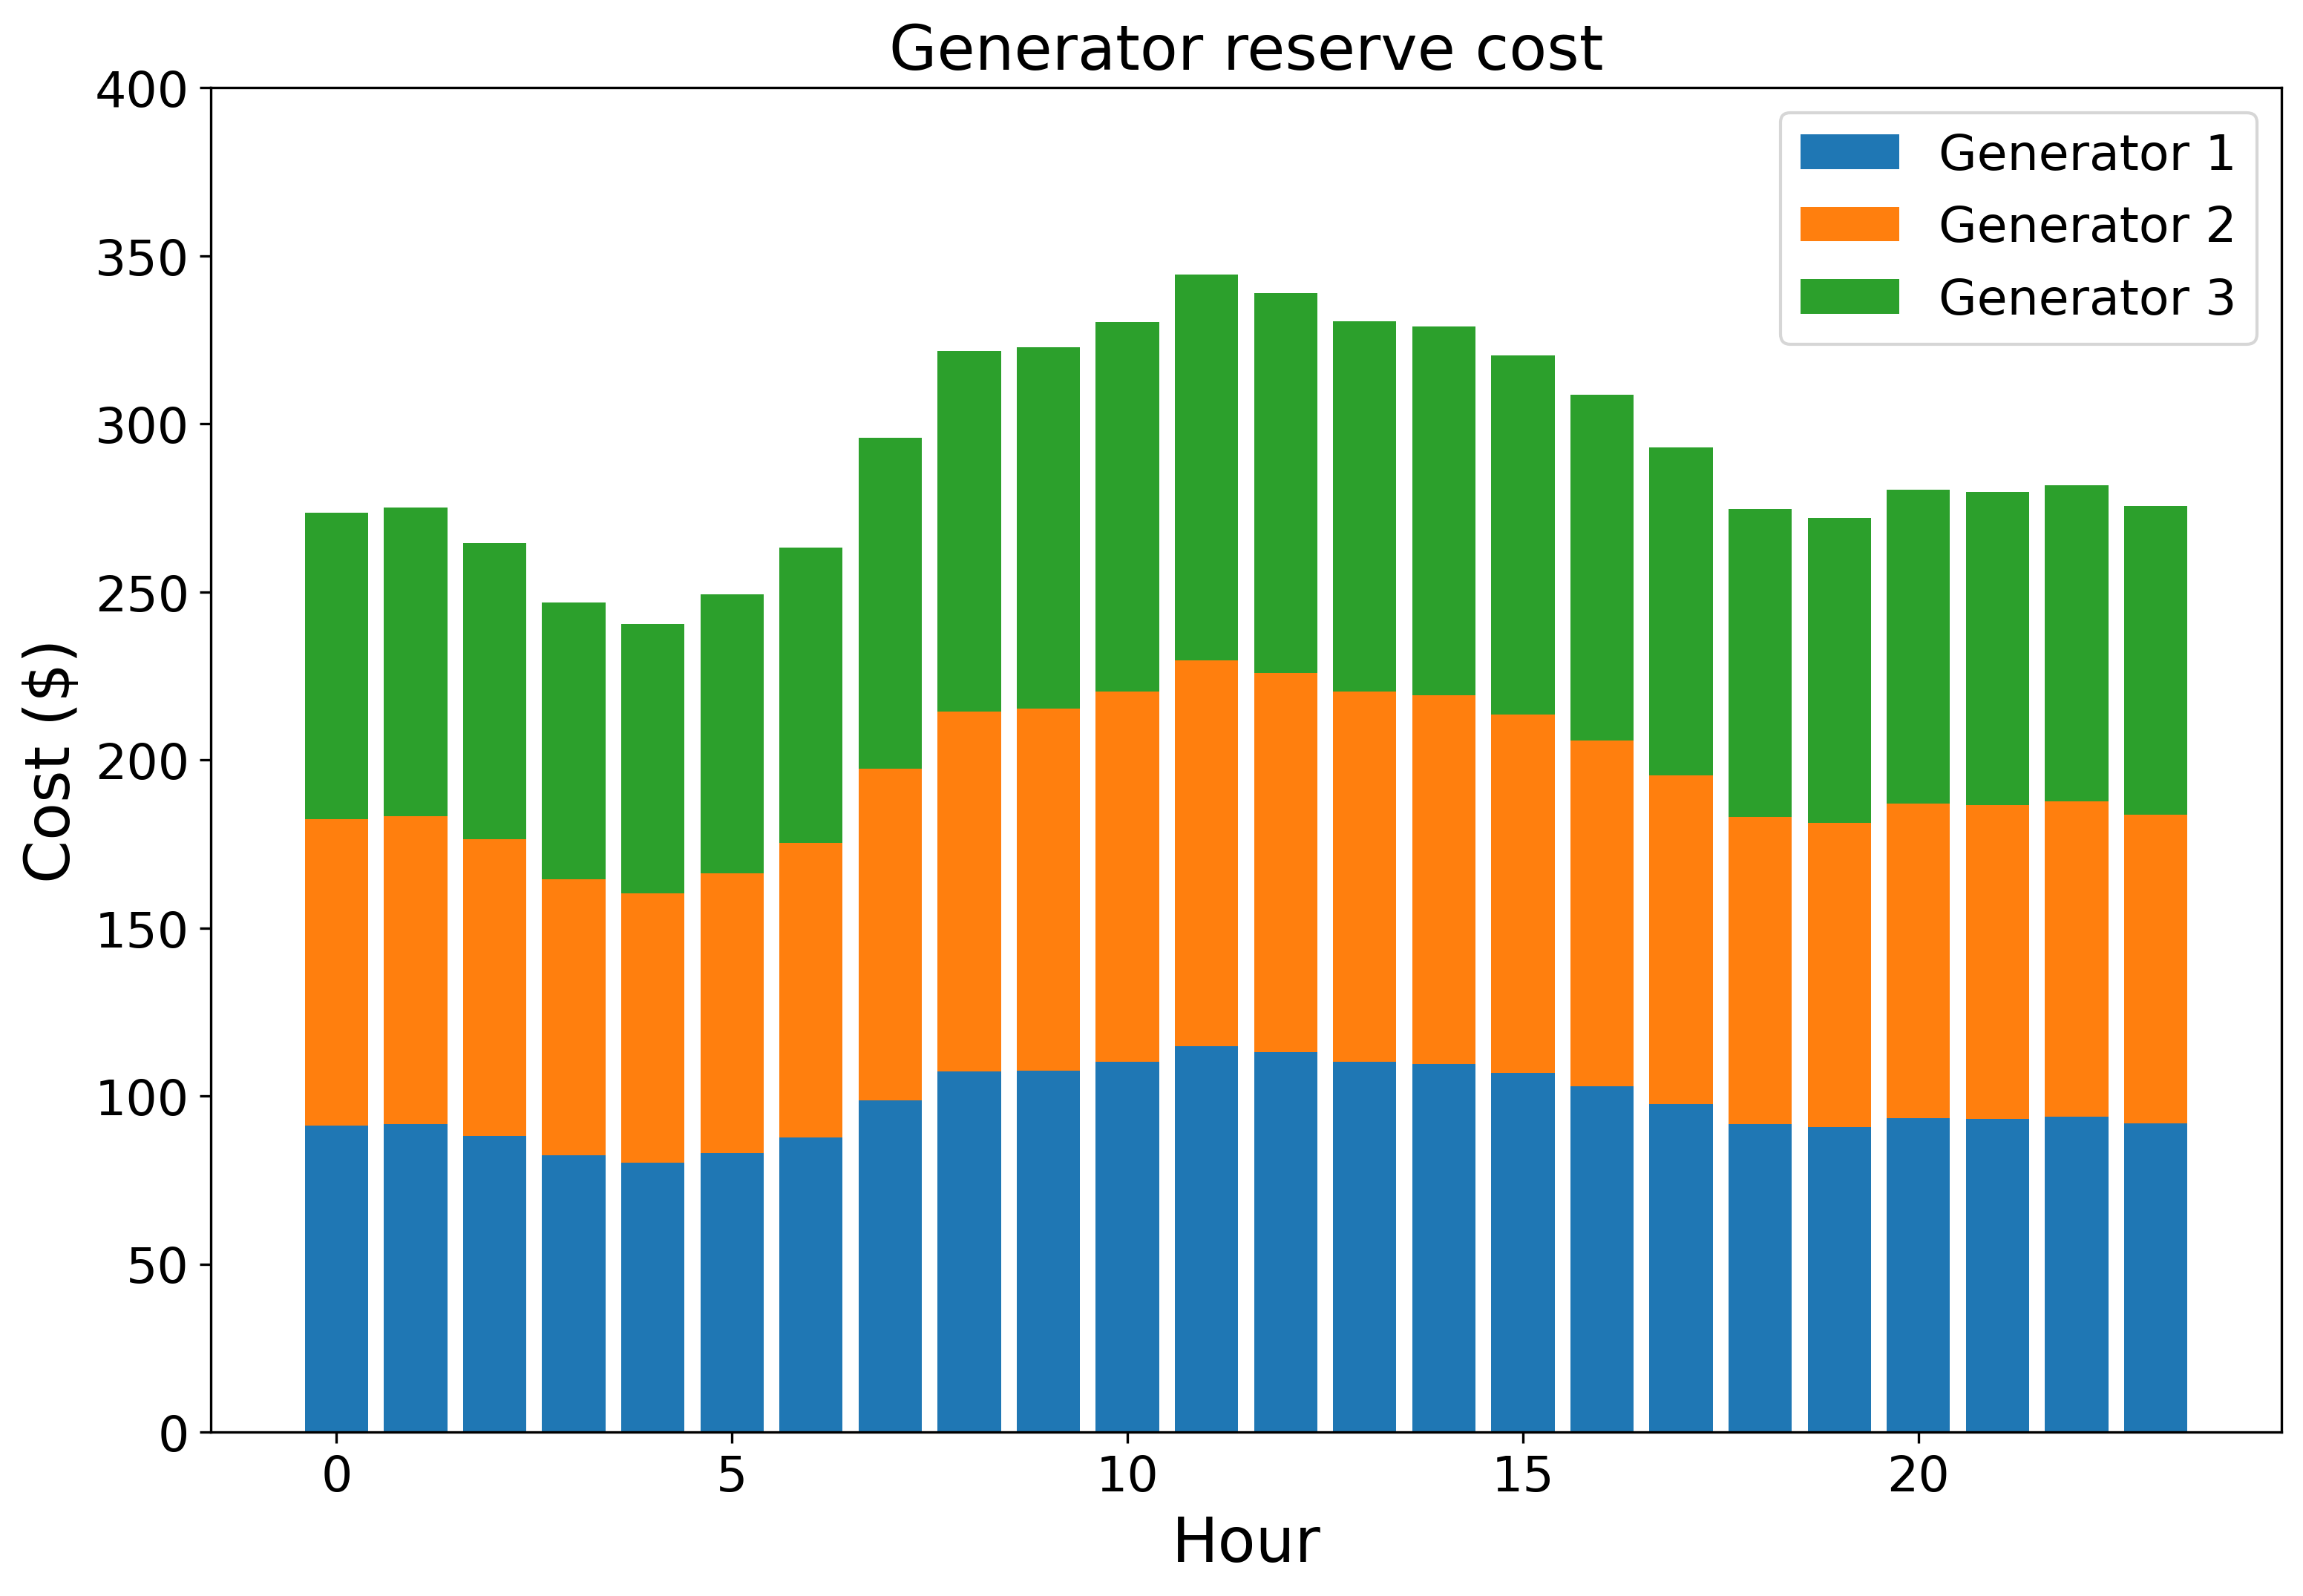

In [26]:
fig = plt.figure(figsize=(12,8), dpi=300)

plt.bar(range(nhours), gen_r_cost_hour[0, :], label="Generator 1")
plt.bar(range(nhours), gen_r_cost_hour[1, :], bottom=gen_r_cost_hour[0, :], label="Generator 2")
plt.bar(range(nhours), gen_r_cost_hour[2, :], bottom=gen_r_cost_hour[1, :]+gen_r_cost_hour[0, :], label="Generator 3")

plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0, 400)
plt.xlabel("Hour", fontsize=20)
plt.ylabel("Cost ($)", fontsize=20)
plt.title("Generator reserve cost", fontsize=20)
fig.savefig(figdir+"gen_reserve_cost.png", dpi=300)

plt.show()

### Total cost contribution bar plot

Wind cost = 
 [100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
Total generation cost = 
 [6758.6433576  6777.10095315 6797.97839544 6812.95836764 6828.15793243
 6845.5151415  6855.07351093 6841.93681138 6786.79935169 6730.40522643
 6674.23407955 6634.53075298 6585.19711895 6569.50716438 6547.05235458
 6579.61304111 6621.63302787 6664.14528515 6669.76042656 6687.60622941
 6698.84220422 6707.56723372 6731.30574674 6787.28308656]
Total generation reserve cost = 
 [273.48410989 274.99204152 264.56883248 246.87202247 240.41448454
 249.24286422 263.07642009 295.9183166  321.66557292 322.77619565
 330.37180649 344.35783121 338.95594608 330.46213659 328.86958832
 320.36535279 308.66083086 292.99757521 274.62180474 272.02389224
 280.44309422 279.76913982 281.65080163 275.46692216]
Total cost = 
 [7132.12746749 7152.09299467 7162.54722791 7159.8303901  7168.57241697
 7194.75800572 7218.14993101 7237.85512798 7208.46492461 

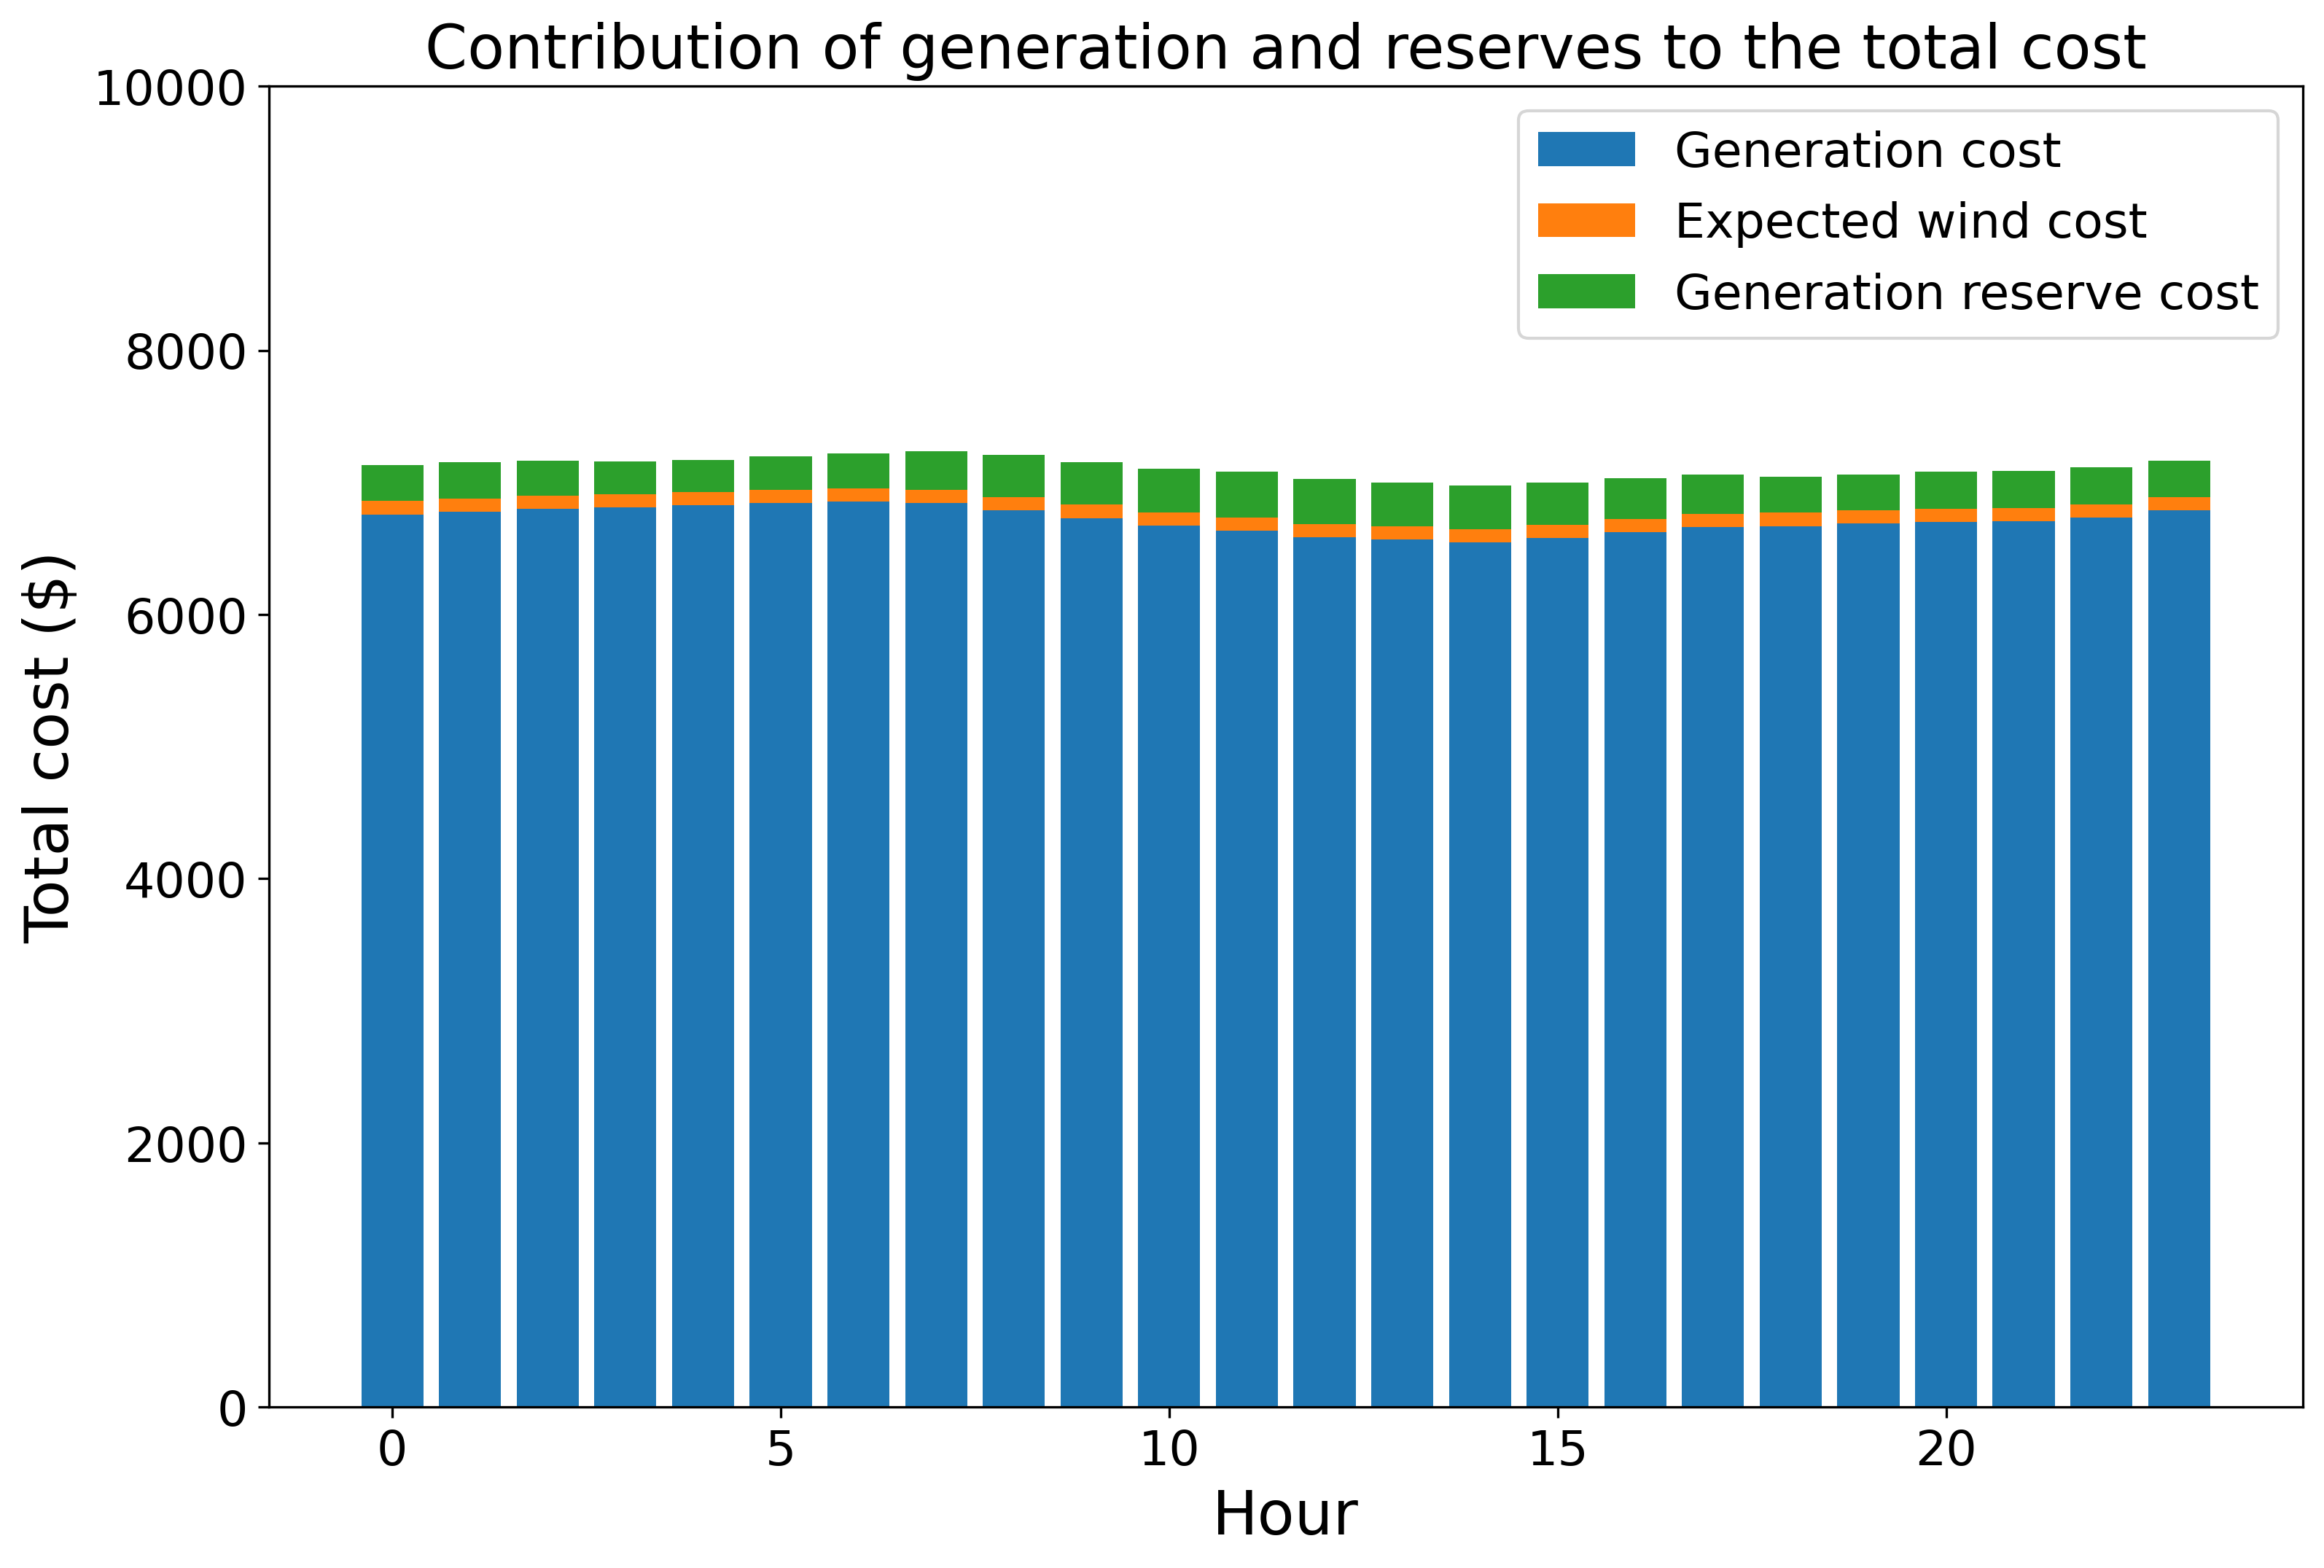

In [27]:
wind_cost = CW0 + CW1*PW_f_hour
total_gen_cost = gen_cost_hour[2, :]+gen_cost_hour[1, :]+gen_cost_hour[0, :]
total_gen_r_cost = gen_r_cost_hour[2, :]+gen_r_cost_hour[1, :]+gen_r_cost_hour[0, :]

print("Wind cost = \n", wind_cost)
print("Total generation cost = \n", total_gen_cost)
print("Total generation reserve cost = \n", total_gen_r_cost)
print("Total cost = \n", total_gen_cost + total_gen_r_cost + wind_cost)

fig = plt.figure(figsize=(12,8), dpi=300)
plt.bar(range(nhours),total_gen_cost, label="Generation cost")
plt.bar(range(nhours),wind_cost, bottom=total_gen_cost, label="Expected wind cost")
plt.bar(range(nhours),total_gen_r_cost, bottom=total_gen_cost+wind_cost, label="Generation reserve cost")

plt.xlabel("Hour", fontsize=20)
plt.ylabel("Total cost ($)", fontsize=20)
plt.title("Contribution of generation and reserves to the total cost", fontsize=20)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,10000)
fig_name = figdir+"cost_contribution.png"
fig.savefig(fig_name, dpi=300)
plt.show()